In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pandas import DataFrame
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import math

## Data Processing

In [2]:
country_info_path = "../data/country_info.csv"
artists_similarity_path = "../data/jaccard_normalized_artists_similarity.csv"
genres_similarity_path = "../data/jaccard_normalized_genres_similarity.csv"
votes_path = "../data/votes.csv"

country_info_df = pd.read_csv(country_info_path)

artists_similarity_df = pd.read_csv(artists_similarity_path)
artists_similarity_array = np.array(artists_similarity_df)
artists_similarity_matrix = artists_similarity_array[:, 1:].tolist()

genres_similarity_df = pd.read_csv(genres_similarity_path)
genres_similarity_array = np.array(genres_similarity_df)
genres_similarity_matrix = genres_similarity_array[:, 1:].tolist()

country_code_list = genres_similarity_df['country'].tolist()
map_code_to_idx = {code: idx for idx, code in enumerate(country_code_list)}
country_num = len(country_code_list)

votes_df = pd.read_csv(votes_path)
votes_array = np.array(votes_df) 
votes_list = votes_array.tolist()  

votes_matrix_total = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_jury = [[0 for i in range(country_num)] for j in range(country_num)]
votes_matrix_tele = [[0 for i in range(country_num)] for j in range(country_num)]

for vote in votes_list:
    # if vote[0] != 2023 or vote[1] != 'final':  # only consider 2023, final and total points
    # continue
    from_country_code, to_country_code, total_points = vote[2], vote[3], vote[-3]
    if from_country_code not in country_code_list or to_country_code not in country_code_list:
        continue
    votes_matrix_total[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += total_points
    if not math.isnan(vote[-2]):
        votes_matrix_tele[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-2]
    if not math.isnan(vote[-1]):
        votes_matrix_jury[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += vote[-1]

## Clustering

Same as clustering_distance.ipynb

In [3]:
def clustering_one_and_visualize_by_pca(D, V, num_clusters, method='KMeans'):
    # Preprocess data: Impute missing values and normalize
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    D_imputed = imputer.fit_transform(D)
    V_imputed = imputer.transform(V)  # Use the same transformation for V
    
    D_scaled = scaler.fit_transform(D_imputed)
    V_scaled = scaler.transform(V_imputed)  # Use the same transformation for V

    # Clustering
    if method == 'KMeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=42)
    elif method == 'SpectralClustering':
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=42, assign_labels="discretize")
    
    labels = clustering.fit_predict(D_scaled)  # Only fit on D

    # Random labels for comparison
    random_labels = np.random.randint(num_clusters, size=len(D))

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    D_pca = pca.fit_transform(D_scaled)
    V_pca = pca.transform(V_scaled)  # Use the same PCA transformation for V

    # Visualization of original clustering
    plt.figure(figsize=(24, 12))

    plt.subplot(2, 2, 1)
    for cluster in range(num_clusters):
        cluster_points = D_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Taste Matrix (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 2)
    for cluster in range(num_clusters):
        cluster_points = V_pca[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Voting Matrix (Original Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    # Visualization of random clustering
    plt.subplot(2, 2, 3)
    for cluster in range(num_clusters):
        cluster_points = D_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Taste Matrix (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.subplot(2, 2, 4)
    for cluster in range(num_clusters):
        cluster_points = V_pca[random_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('PCA Visualization of Voting Matrix (Random Clustering)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluation
    silhouette_score_D = silhouette_score(D_scaled, labels)
    silhouette_score_V = silhouette_score(V_scaled, labels)
    silhouette_score_D_random = silhouette_score(D_scaled, random_labels)
    silhouette_score_V_random = silhouette_score(V_scaled, random_labels)

    print(f"The silhouette score for Taste Matrix (Original) is: {silhouette_score_D}")
    print(f"The silhouette score for Voting Matrix (Original) is: {silhouette_score_V}")
    print(f"The silhouette score for Taste Matrix (Random) is: {silhouette_score_D_random}")
    print(f"The silhouette score for Voting Matrix (Random) is: {silhouette_score_V_random}")

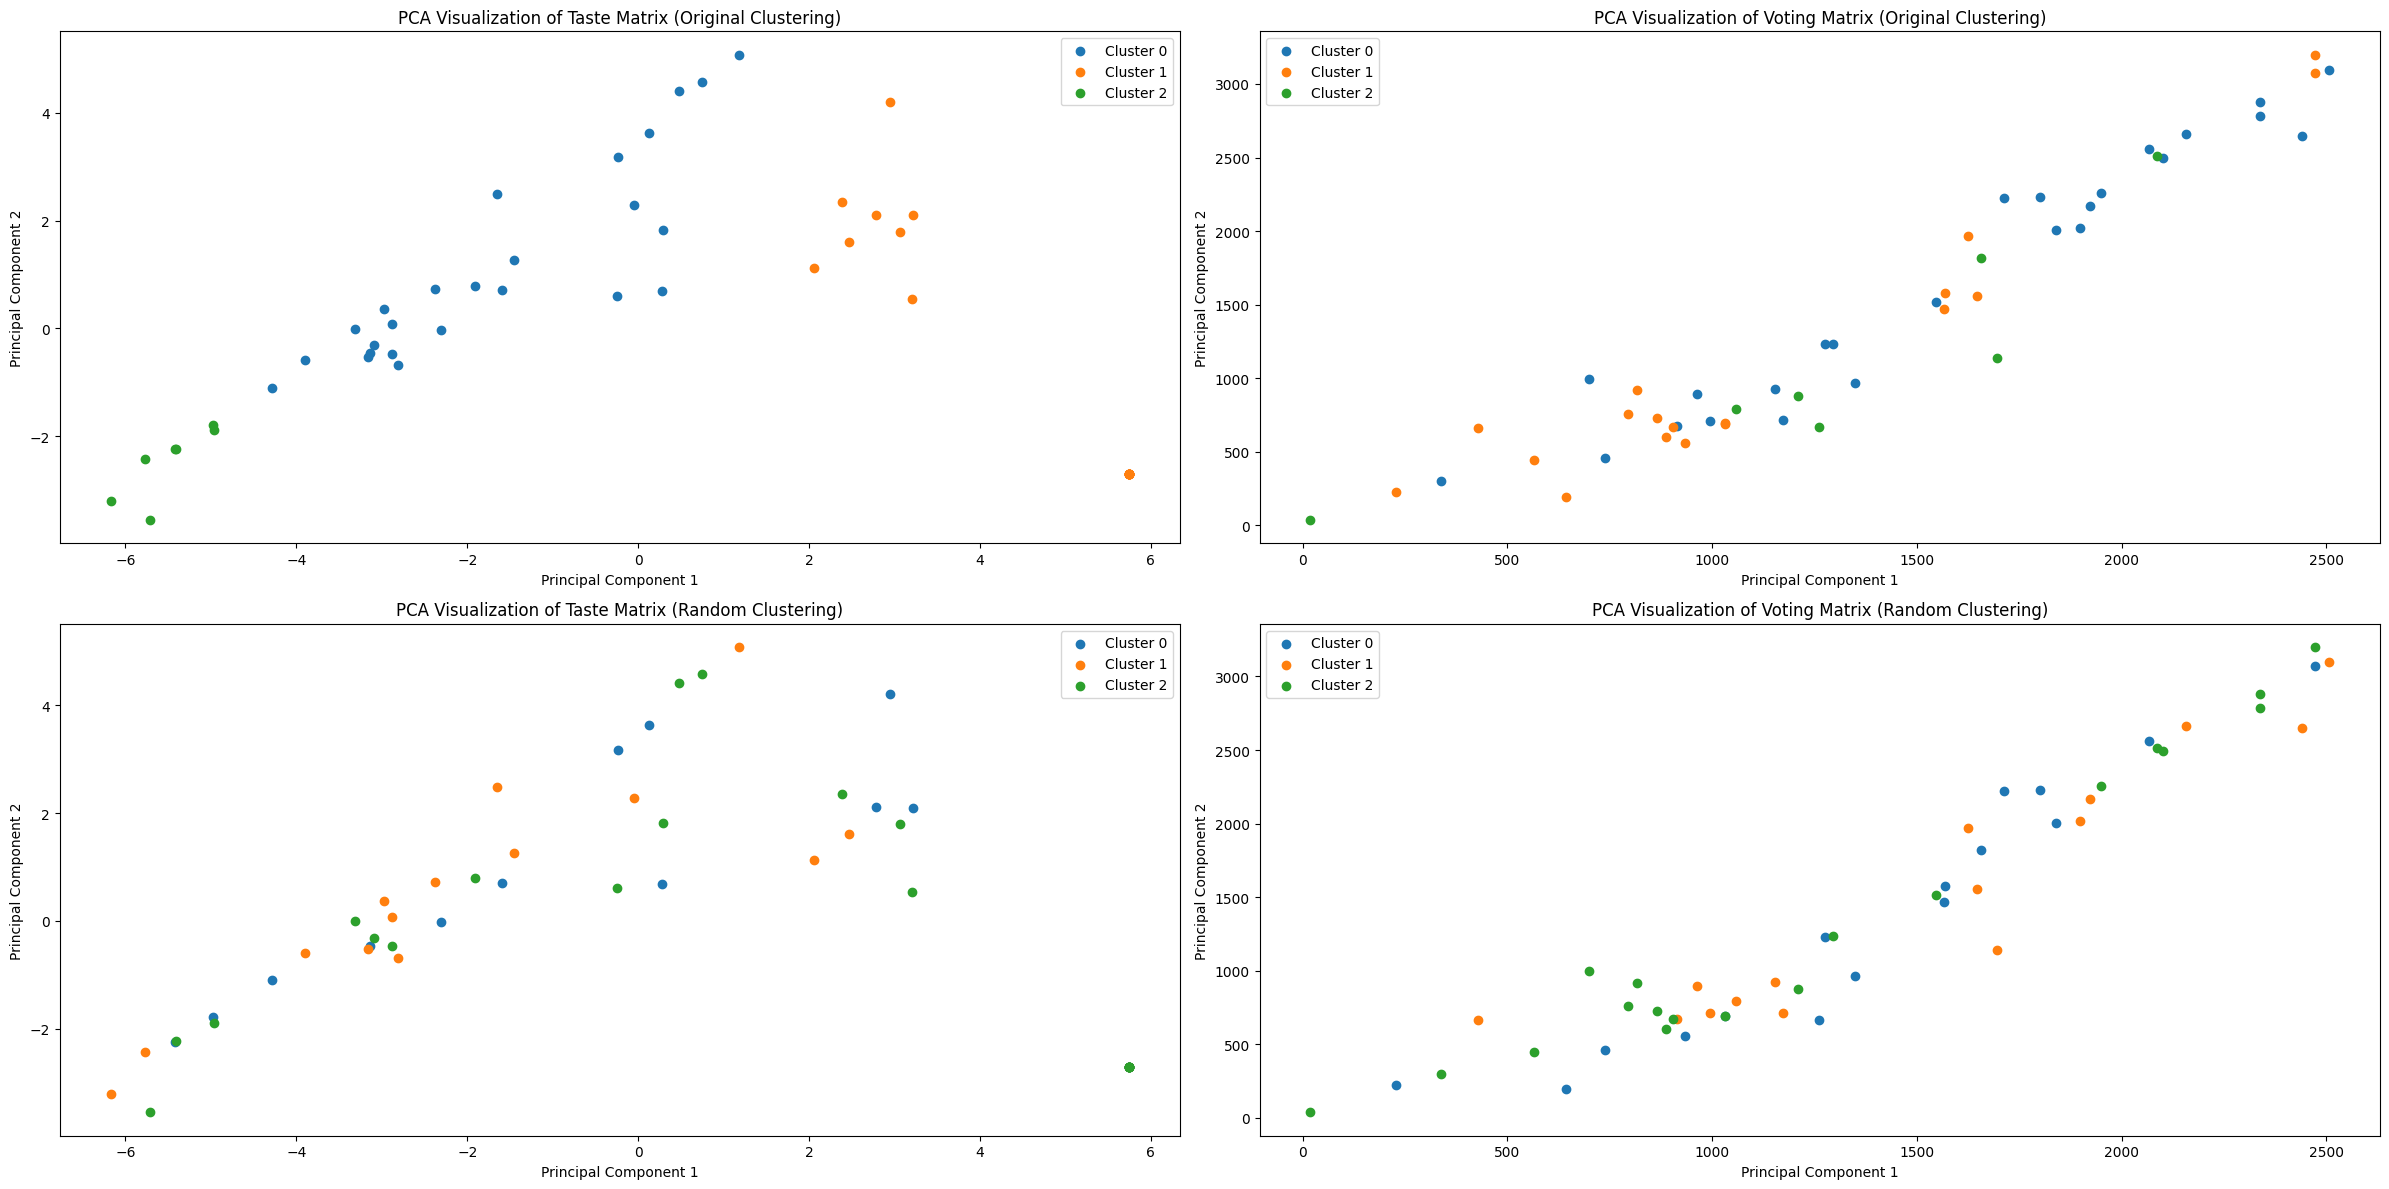

The silhouette score for Taste Matrix (Original) is: 0.21094828288866002
The silhouette score for Voting Matrix (Original) is: -0.025146430745463313
The silhouette score for Taste Matrix (Random) is: -0.03606348197234866
The silhouette score for Voting Matrix (Random) is: -0.02894051433047775


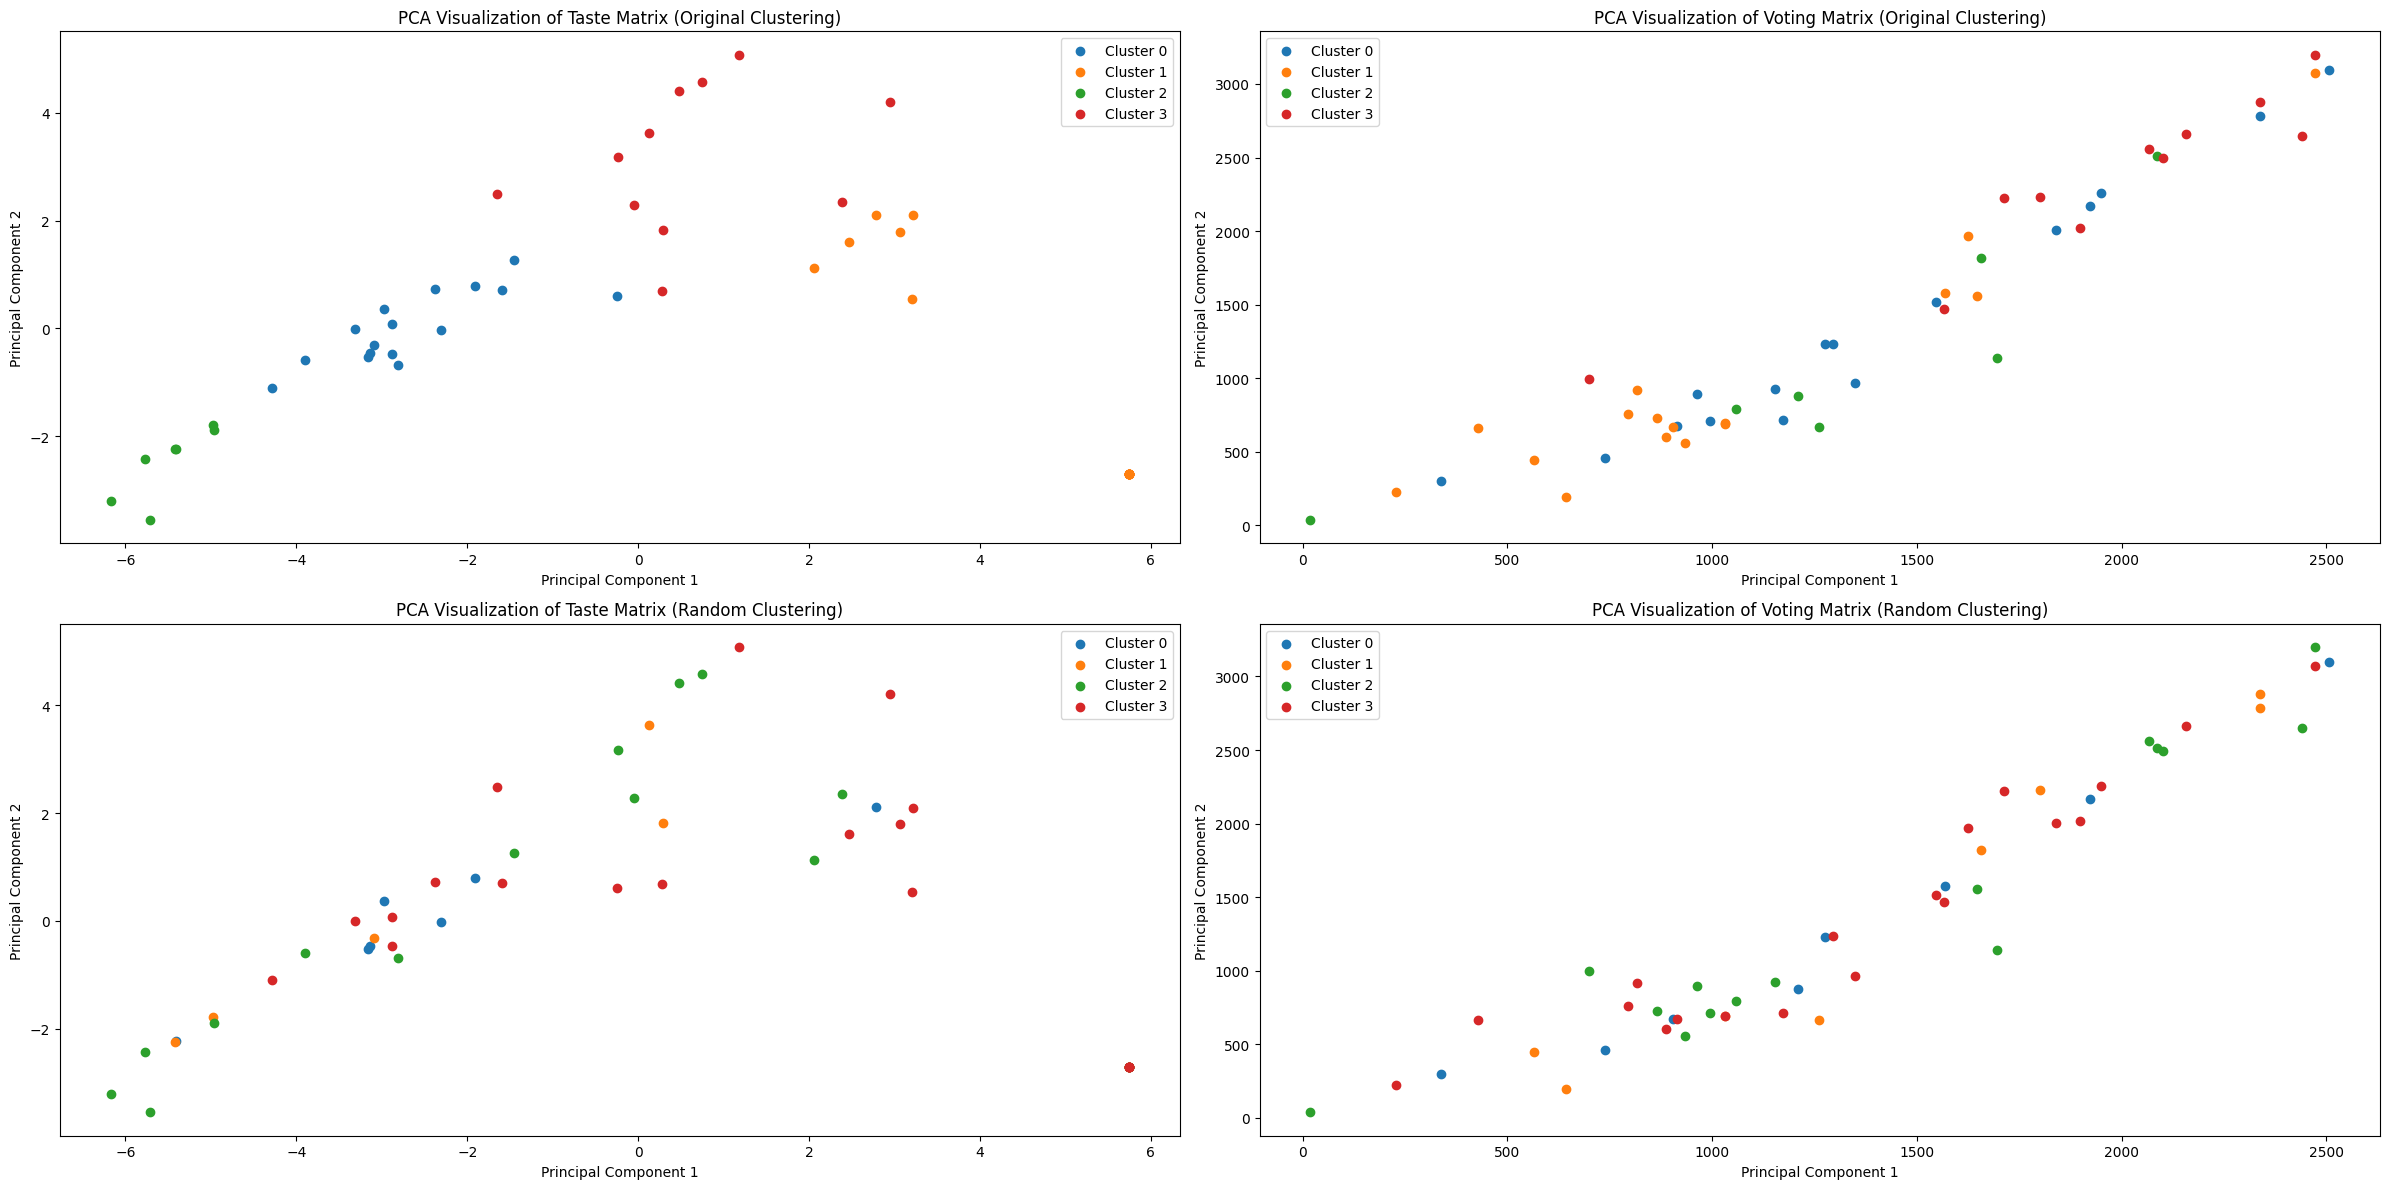

The silhouette score for Taste Matrix (Original) is: 0.20535540597417973
The silhouette score for Voting Matrix (Original) is: -0.02120503010800269
The silhouette score for Taste Matrix (Random) is: -0.05382092055754936
The silhouette score for Voting Matrix (Random) is: -0.04766371058112161


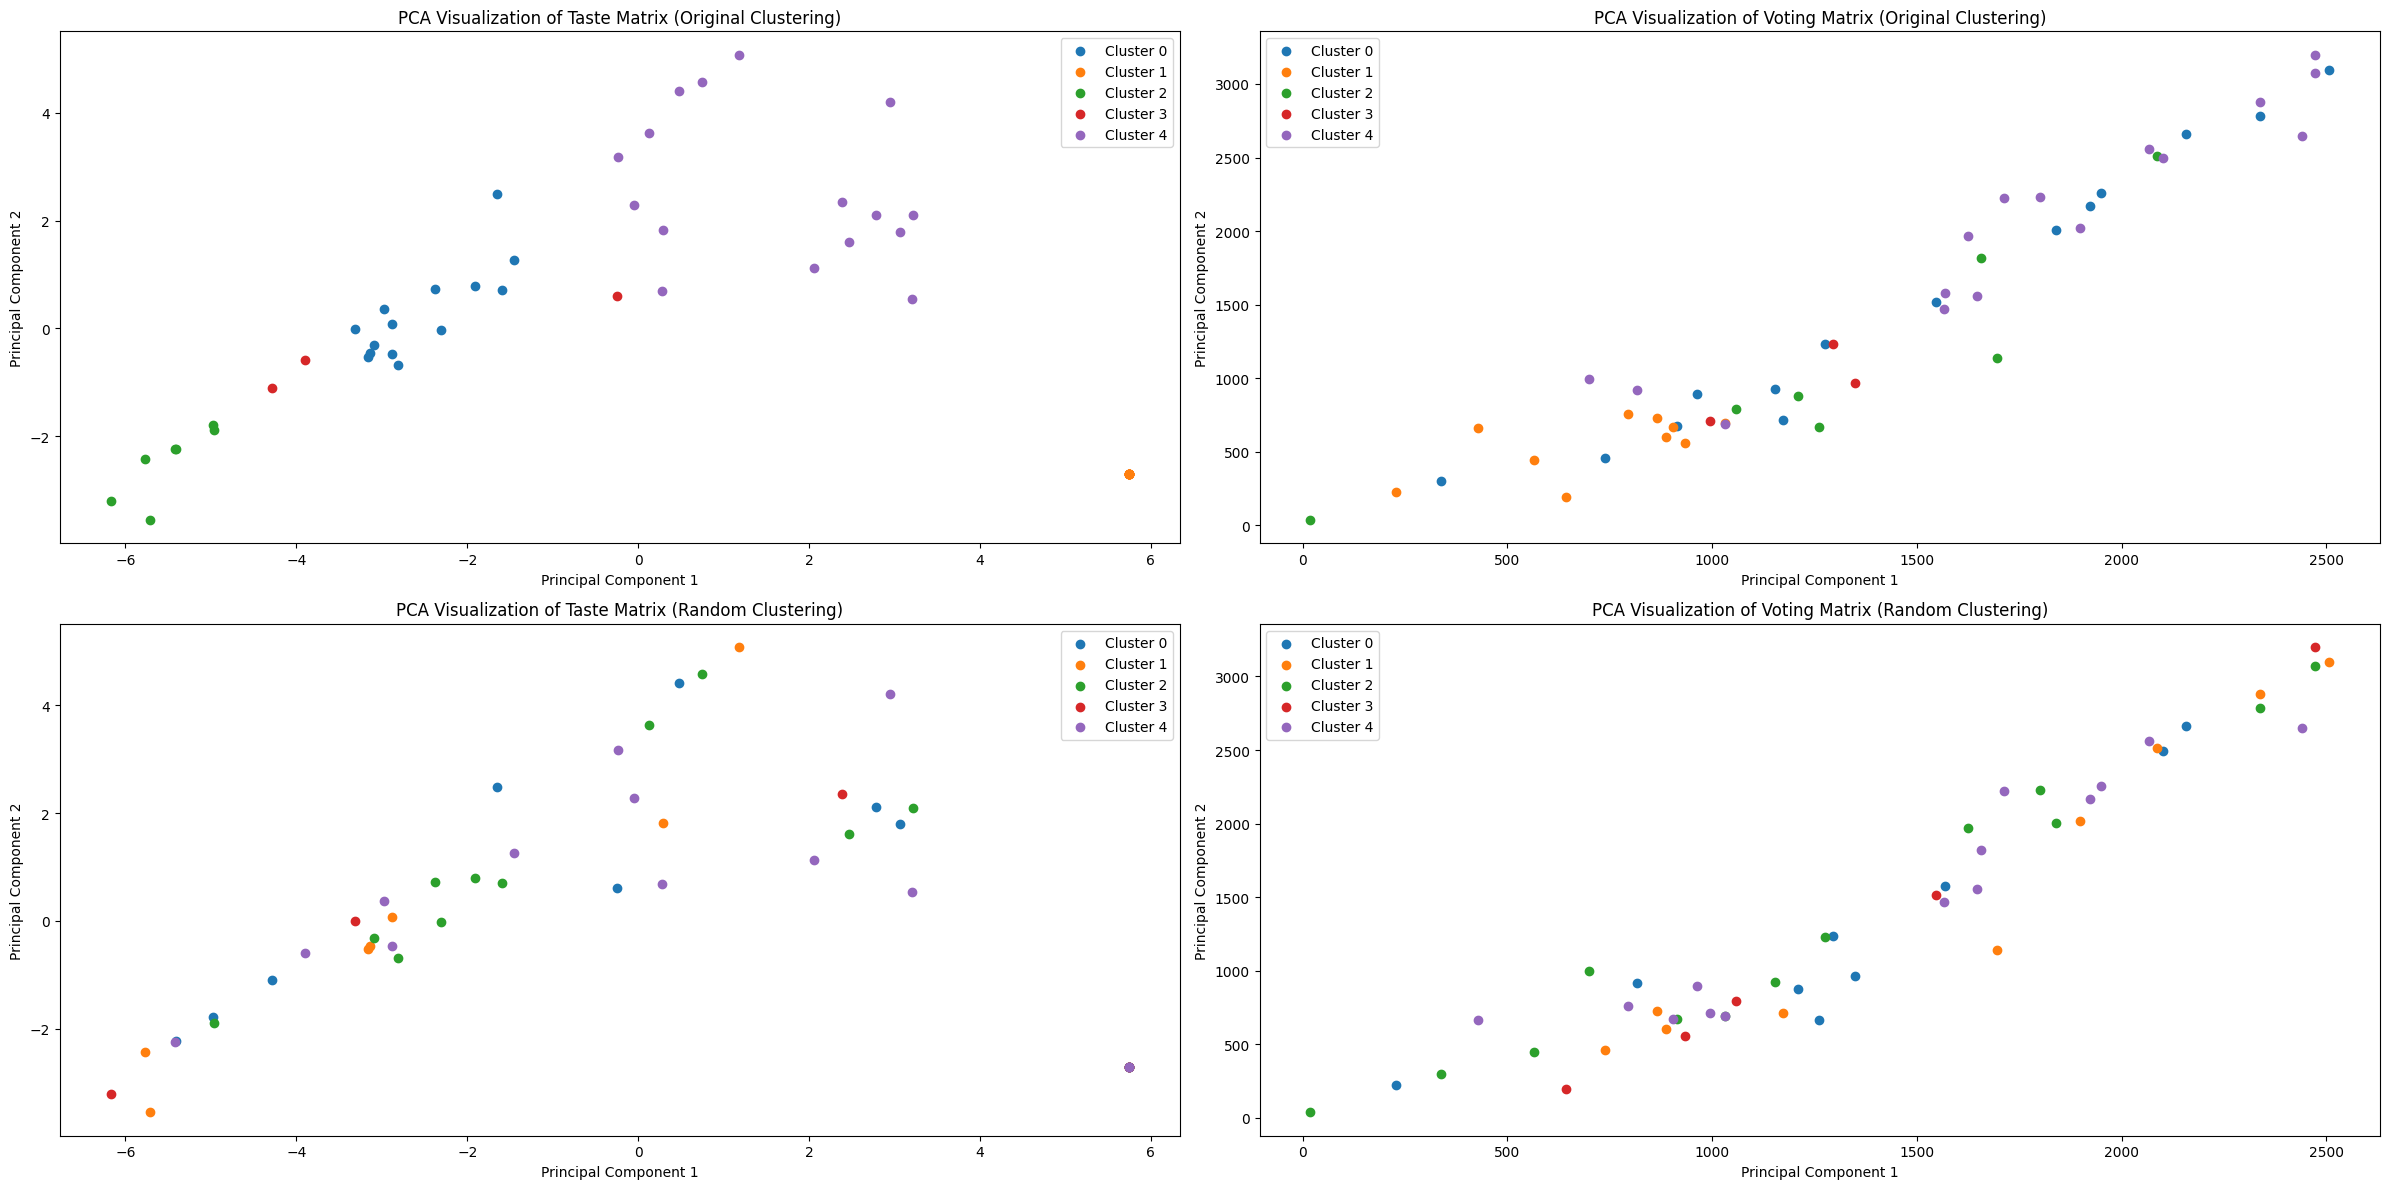

The silhouette score for Taste Matrix (Original) is: 0.28333725746742755
The silhouette score for Voting Matrix (Original) is: -0.09205342804963382
The silhouette score for Taste Matrix (Random) is: -0.0765701594858084
The silhouette score for Voting Matrix (Random) is: -0.09770641819714848


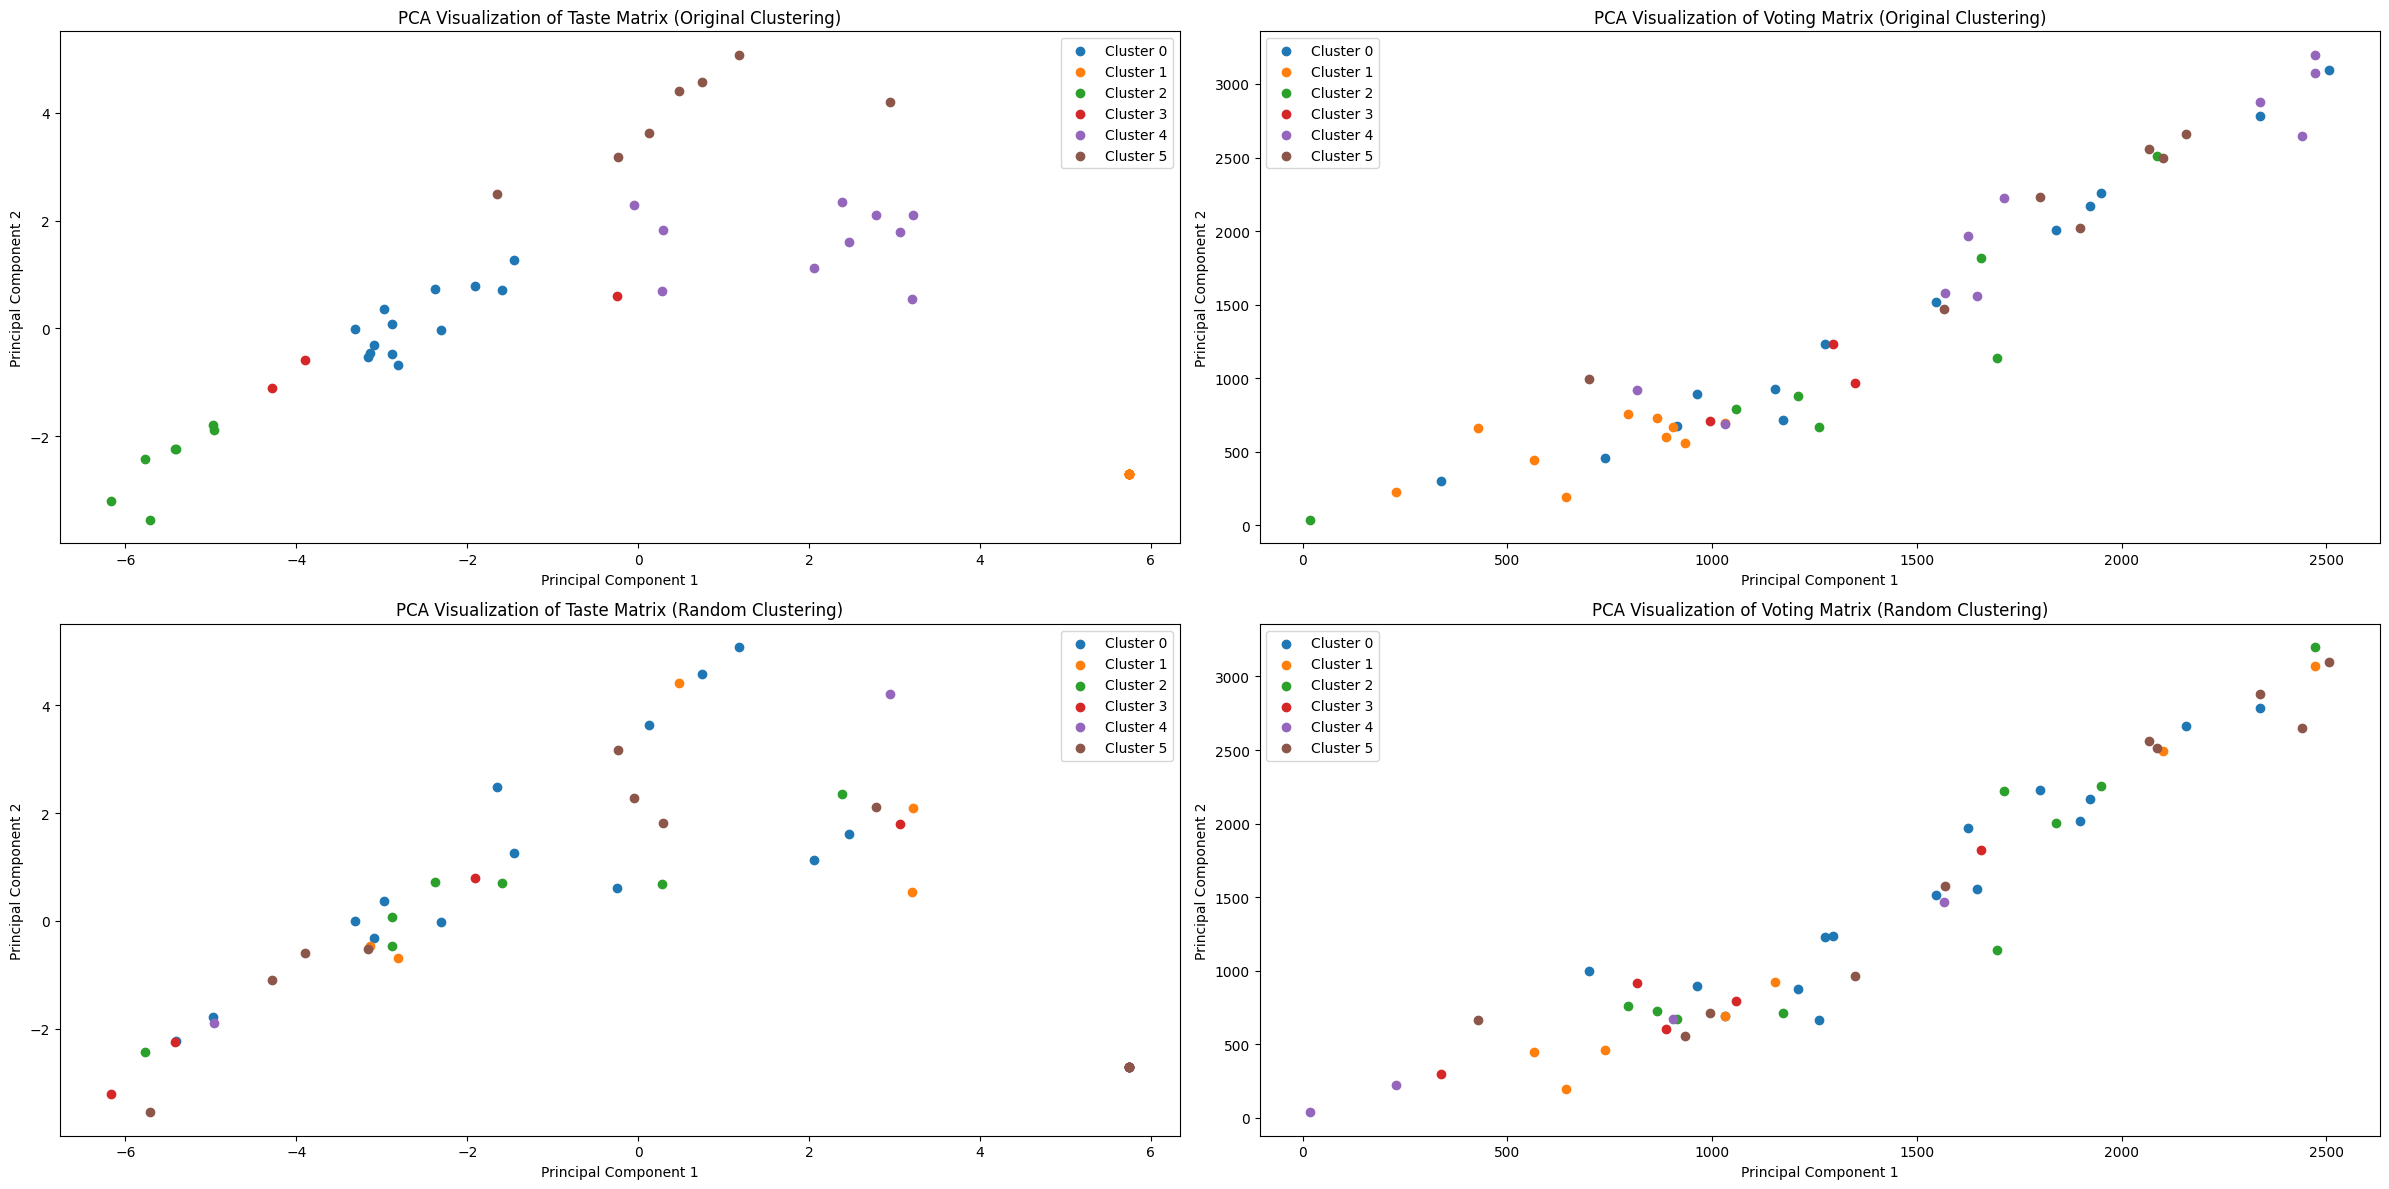

The silhouette score for Taste Matrix (Original) is: 0.29892921037985626
The silhouette score for Voting Matrix (Original) is: -0.09529556279791418
The silhouette score for Taste Matrix (Random) is: -0.11734680493582114
The silhouette score for Voting Matrix (Random) is: -0.14201727238753983


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


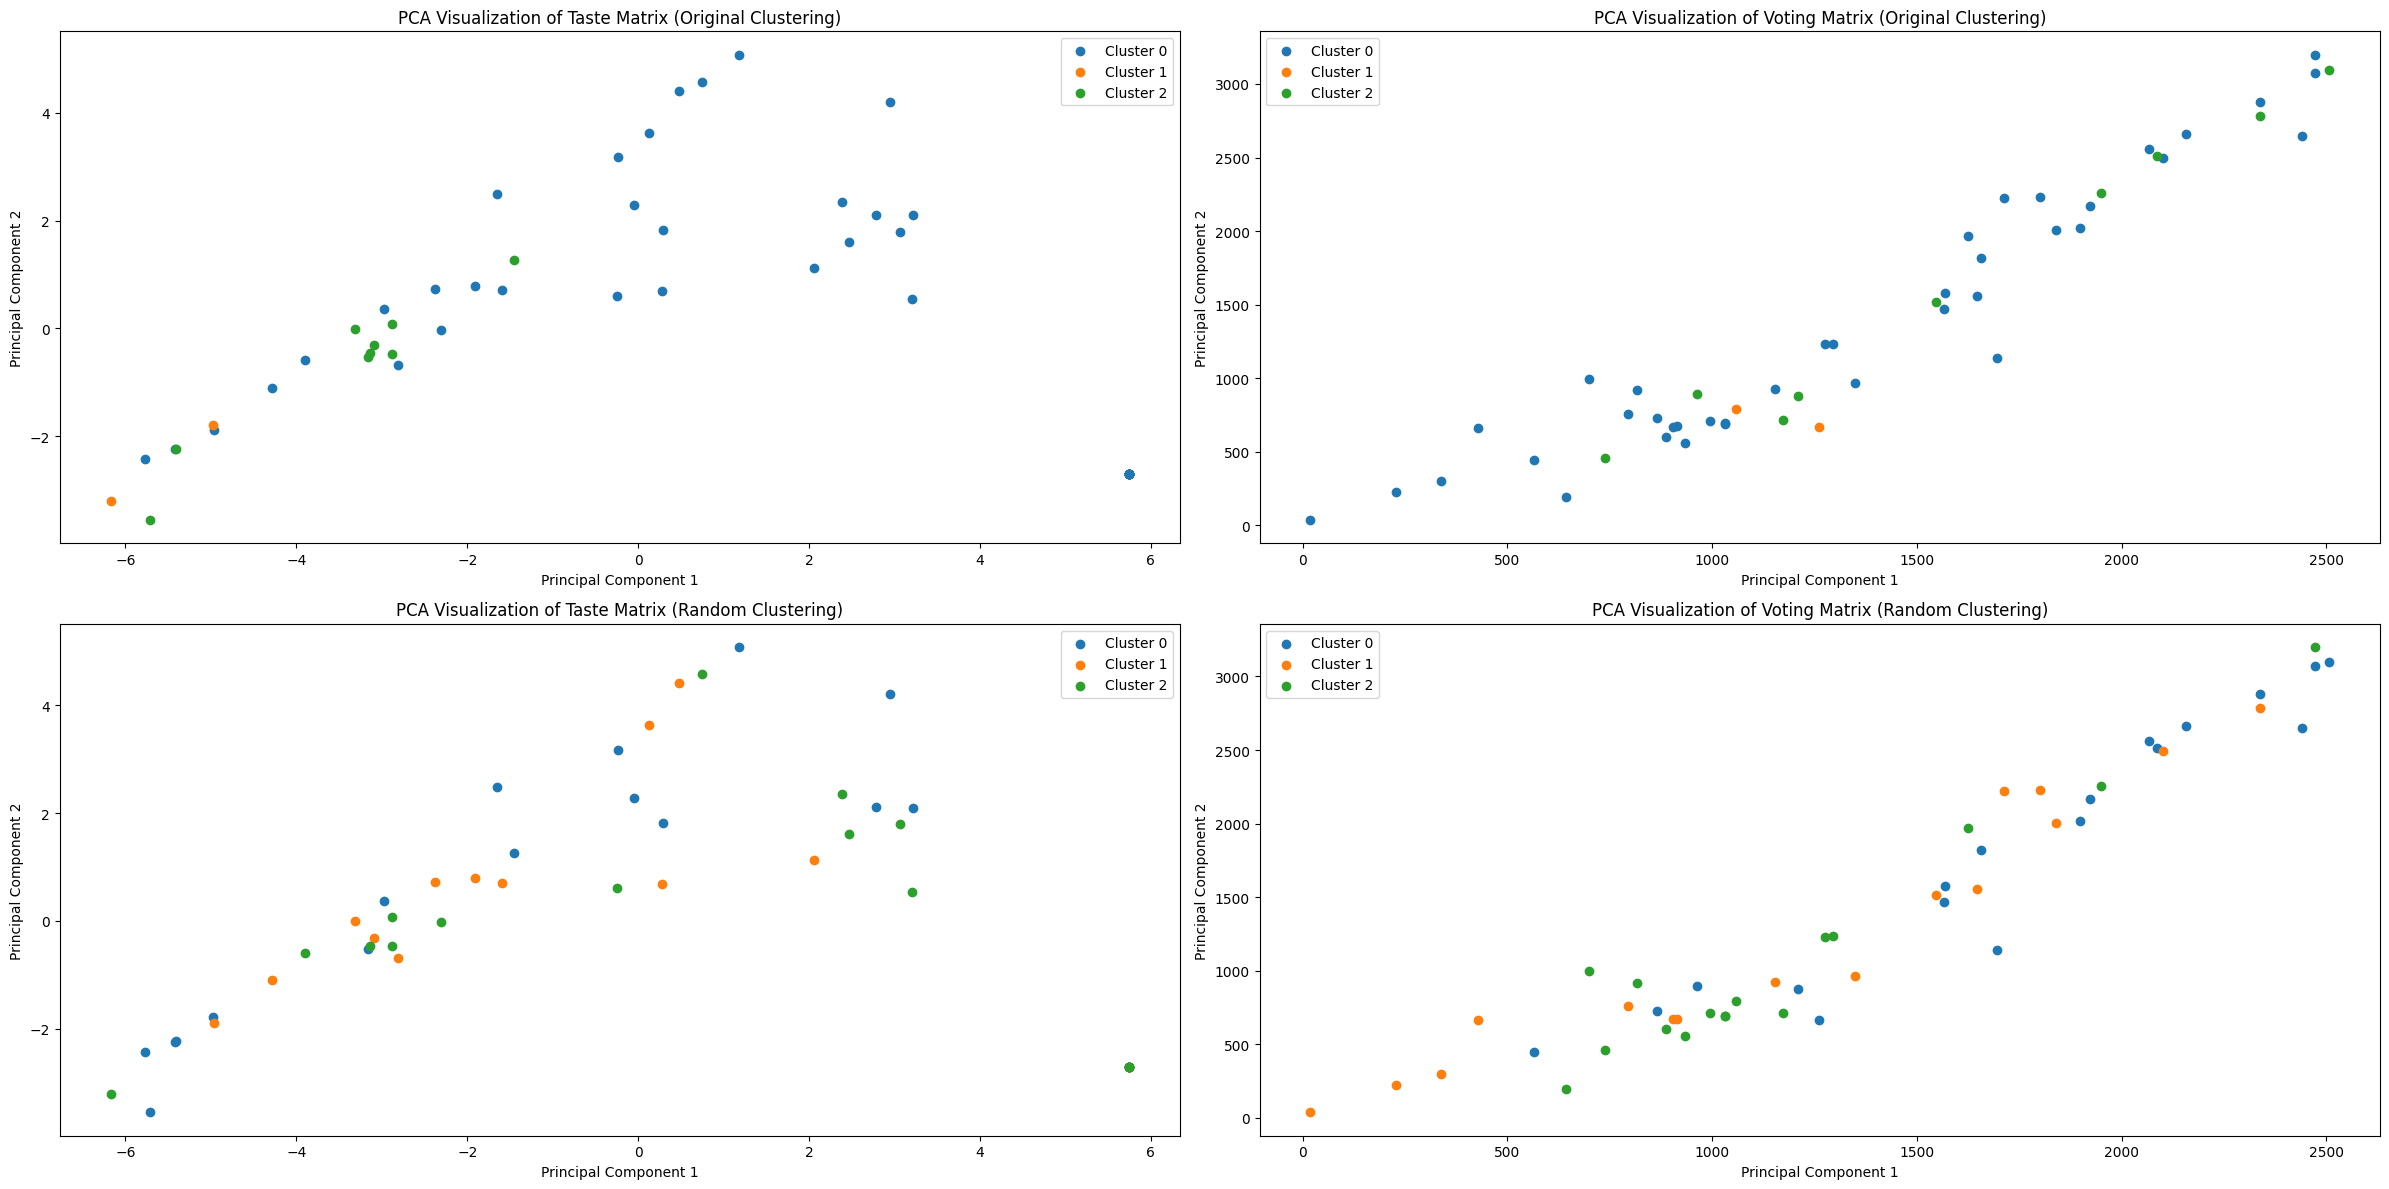

The silhouette score for Taste Matrix (Original) is: 0.13173443250188635
The silhouette score for Voting Matrix (Original) is: -0.16558059922769658
The silhouette score for Taste Matrix (Random) is: -0.03366980810352058
The silhouette score for Voting Matrix (Random) is: -0.03614587522862218


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


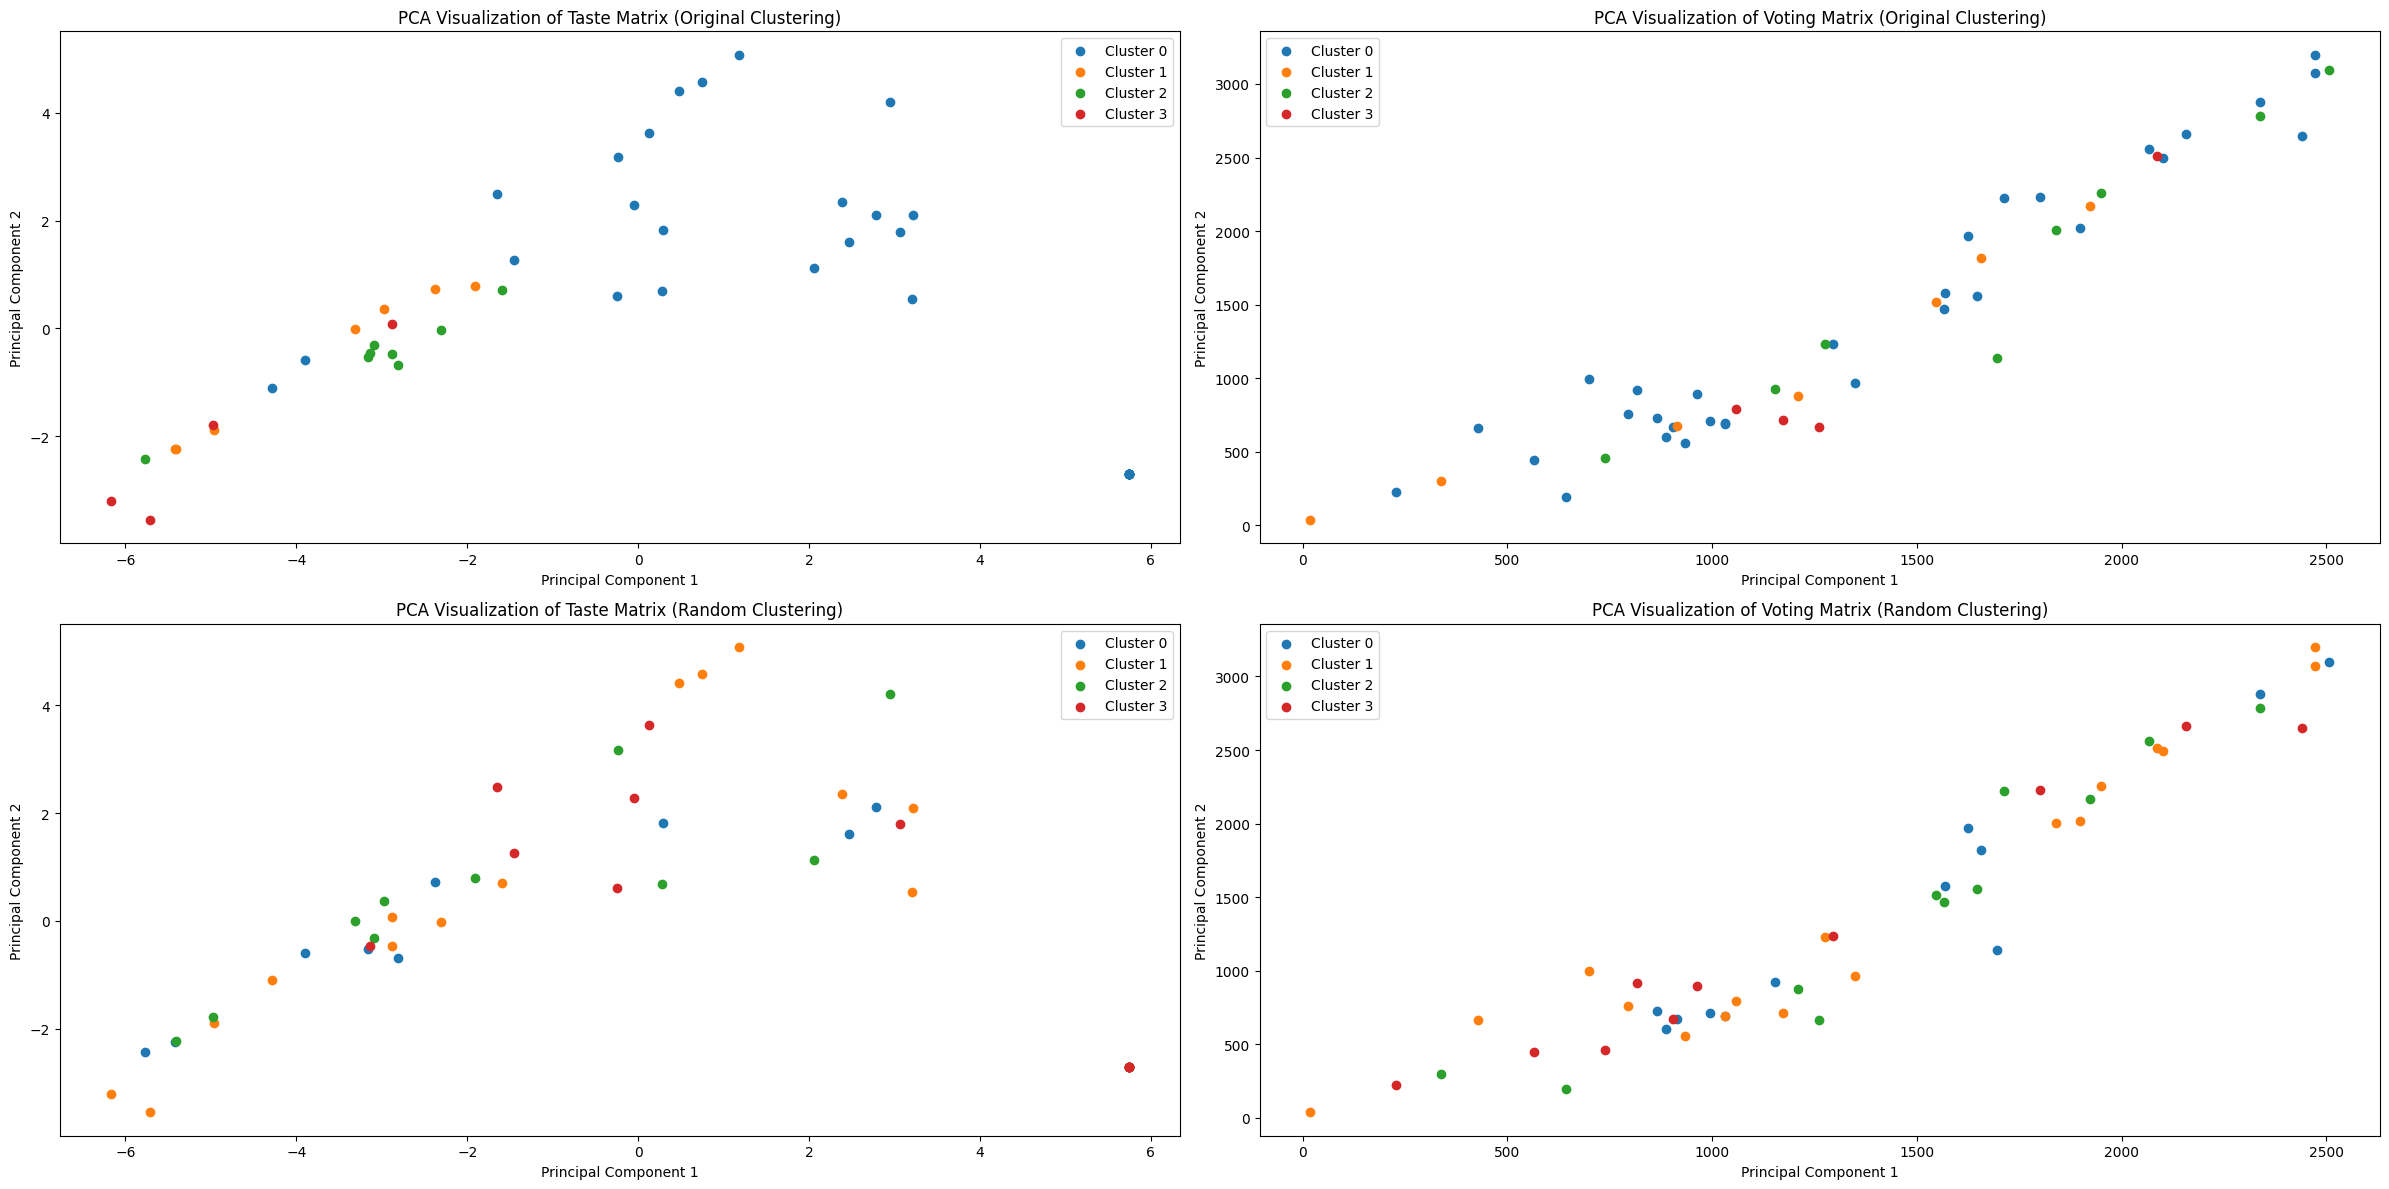

The silhouette score for Taste Matrix (Original) is: 0.17000021595117548
The silhouette score for Voting Matrix (Original) is: -0.07814964708433823
The silhouette score for Taste Matrix (Random) is: -0.06923126164112095
The silhouette score for Voting Matrix (Random) is: -0.0635918918363784


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


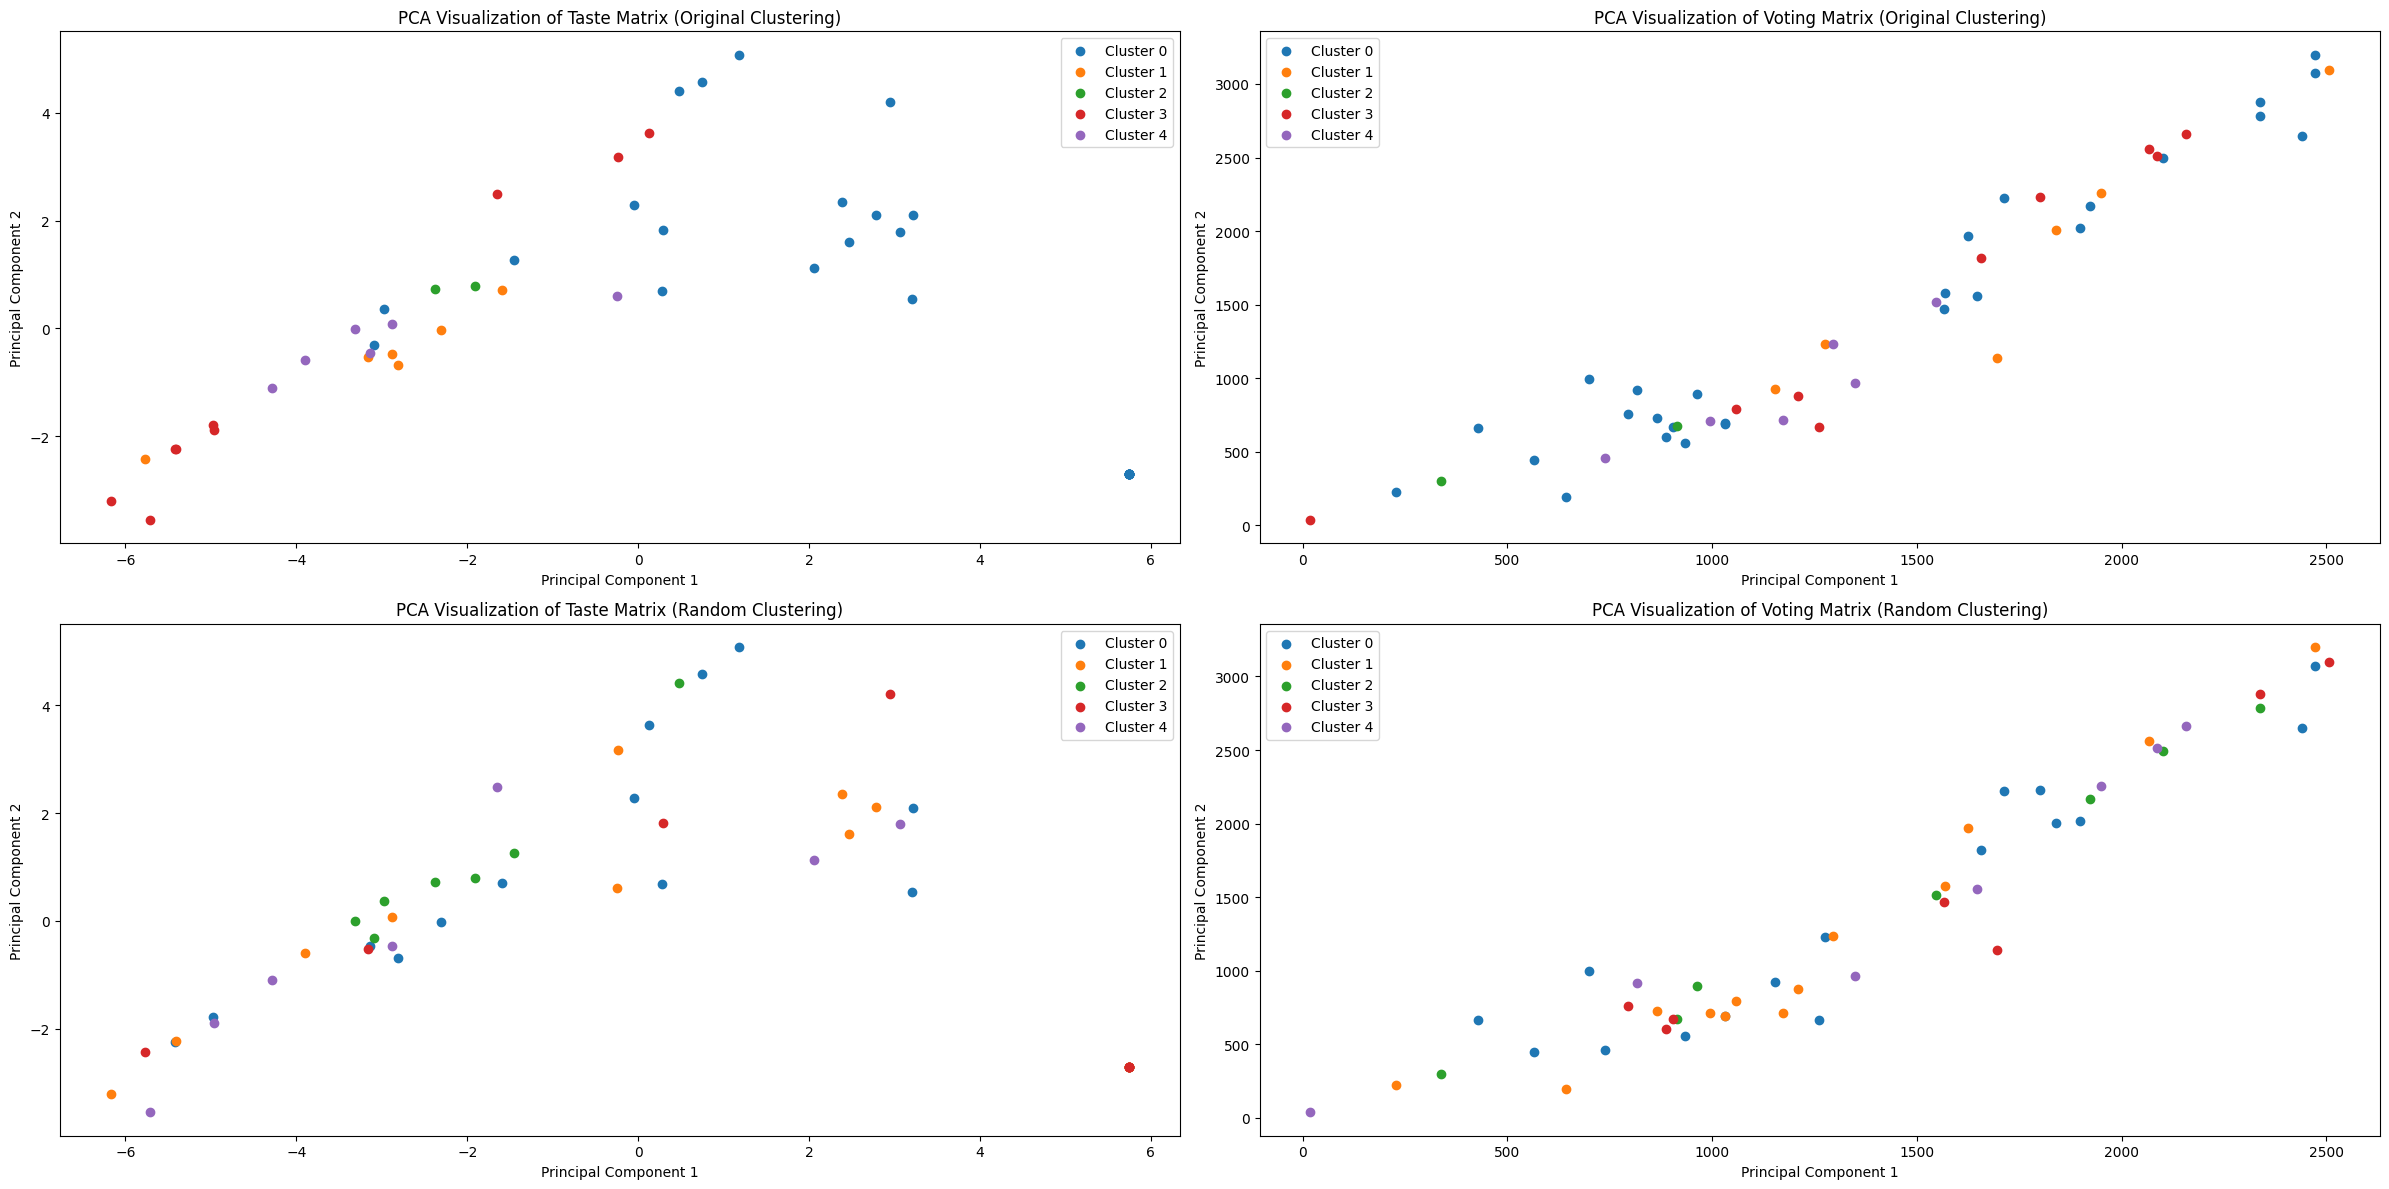

The silhouette score for Taste Matrix (Original) is: 0.17857658903412485
The silhouette score for Voting Matrix (Original) is: -0.17359940494917833
The silhouette score for Taste Matrix (Random) is: -0.0653836675401332
The silhouette score for Voting Matrix (Random) is: -0.06312880307351322


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


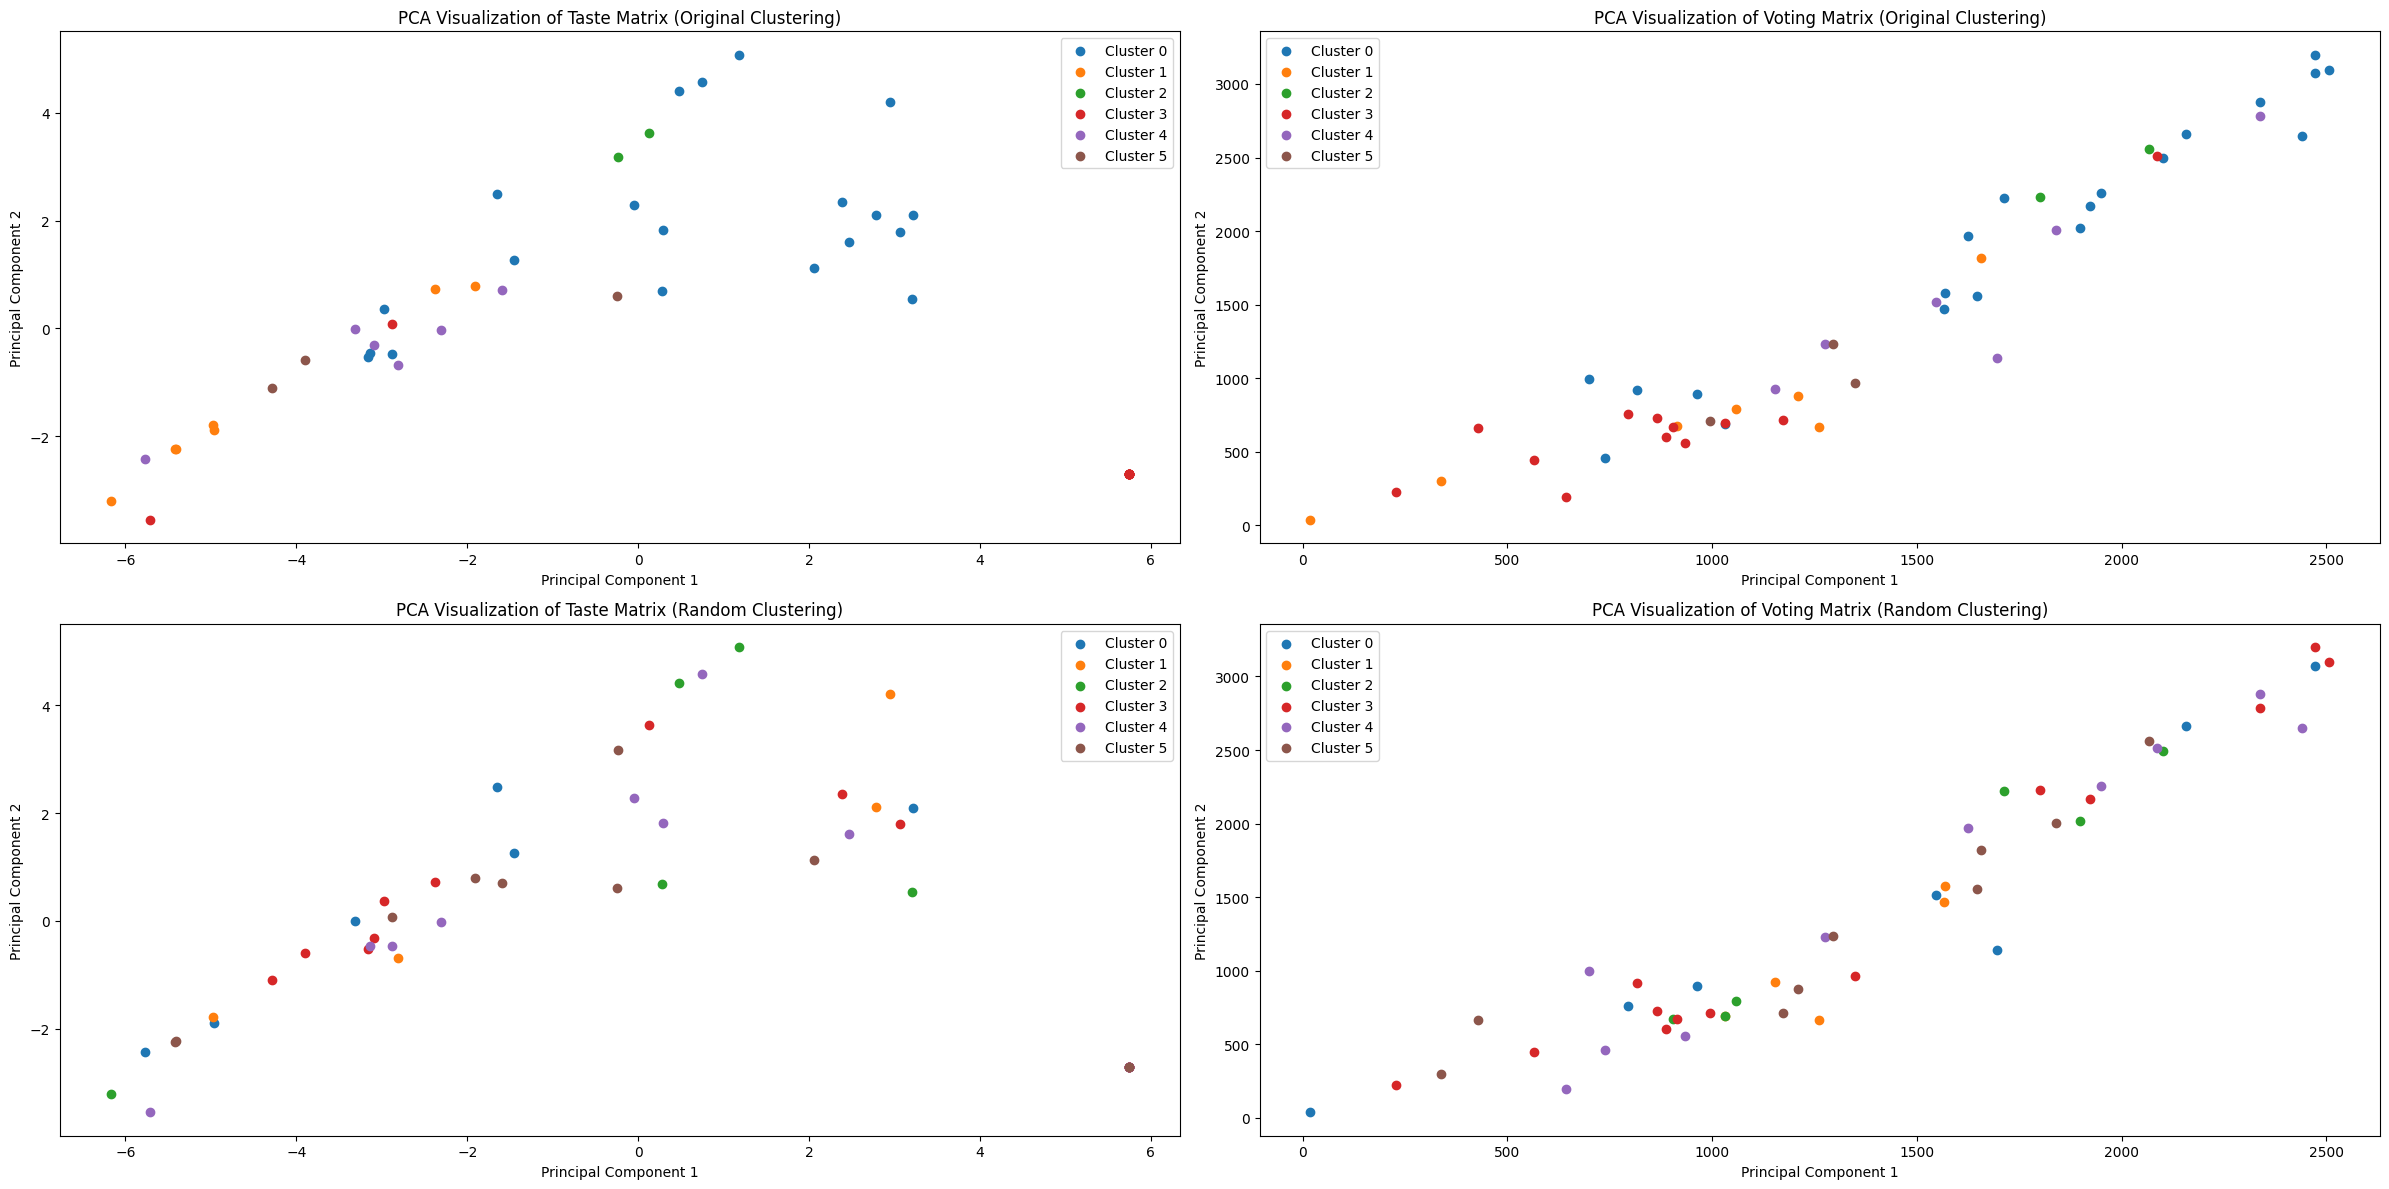

The silhouette score for Taste Matrix (Original) is: 0.19511085690248017
The silhouette score for Voting Matrix (Original) is: -0.13300329563359273
The silhouette score for Taste Matrix (Random) is: -0.07799748820871404
The silhouette score for Voting Matrix (Random) is: -0.11081046366855453


In [4]:
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 3, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 4, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 5, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 6, method='KMeans')

clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_total, 6, method='SpectralClustering')

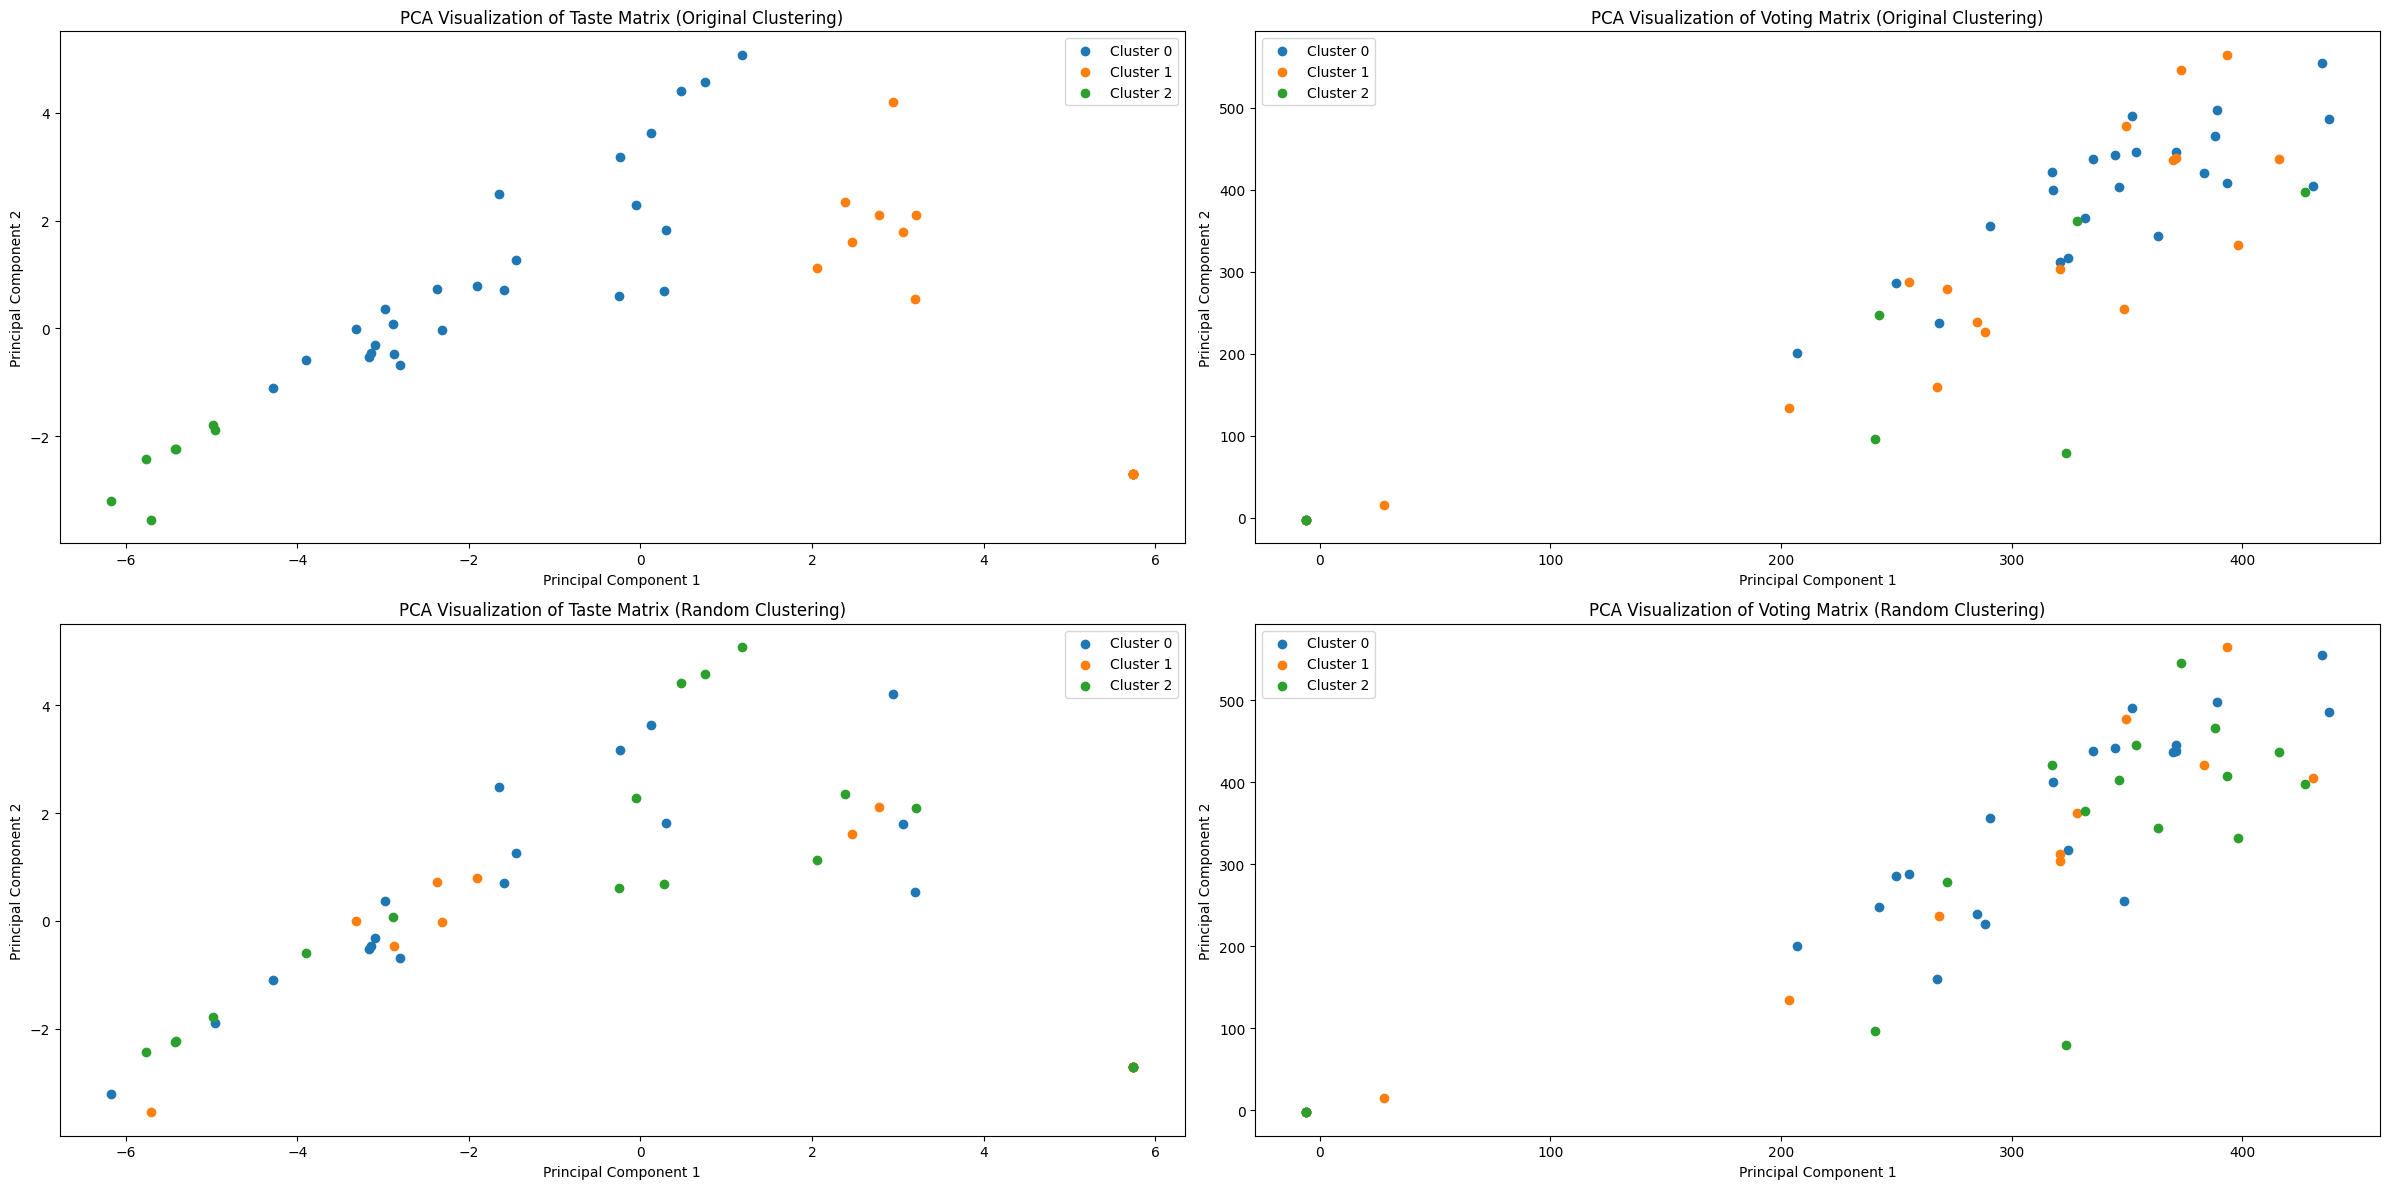

The silhouette score for Taste Matrix (Original) is: 0.21094828288866002
The silhouette score for Voting Matrix (Original) is: -0.023570583636715013
The silhouette score for Taste Matrix (Random) is: -0.030873688516995793
The silhouette score for Voting Matrix (Random) is: -0.0309559968460268


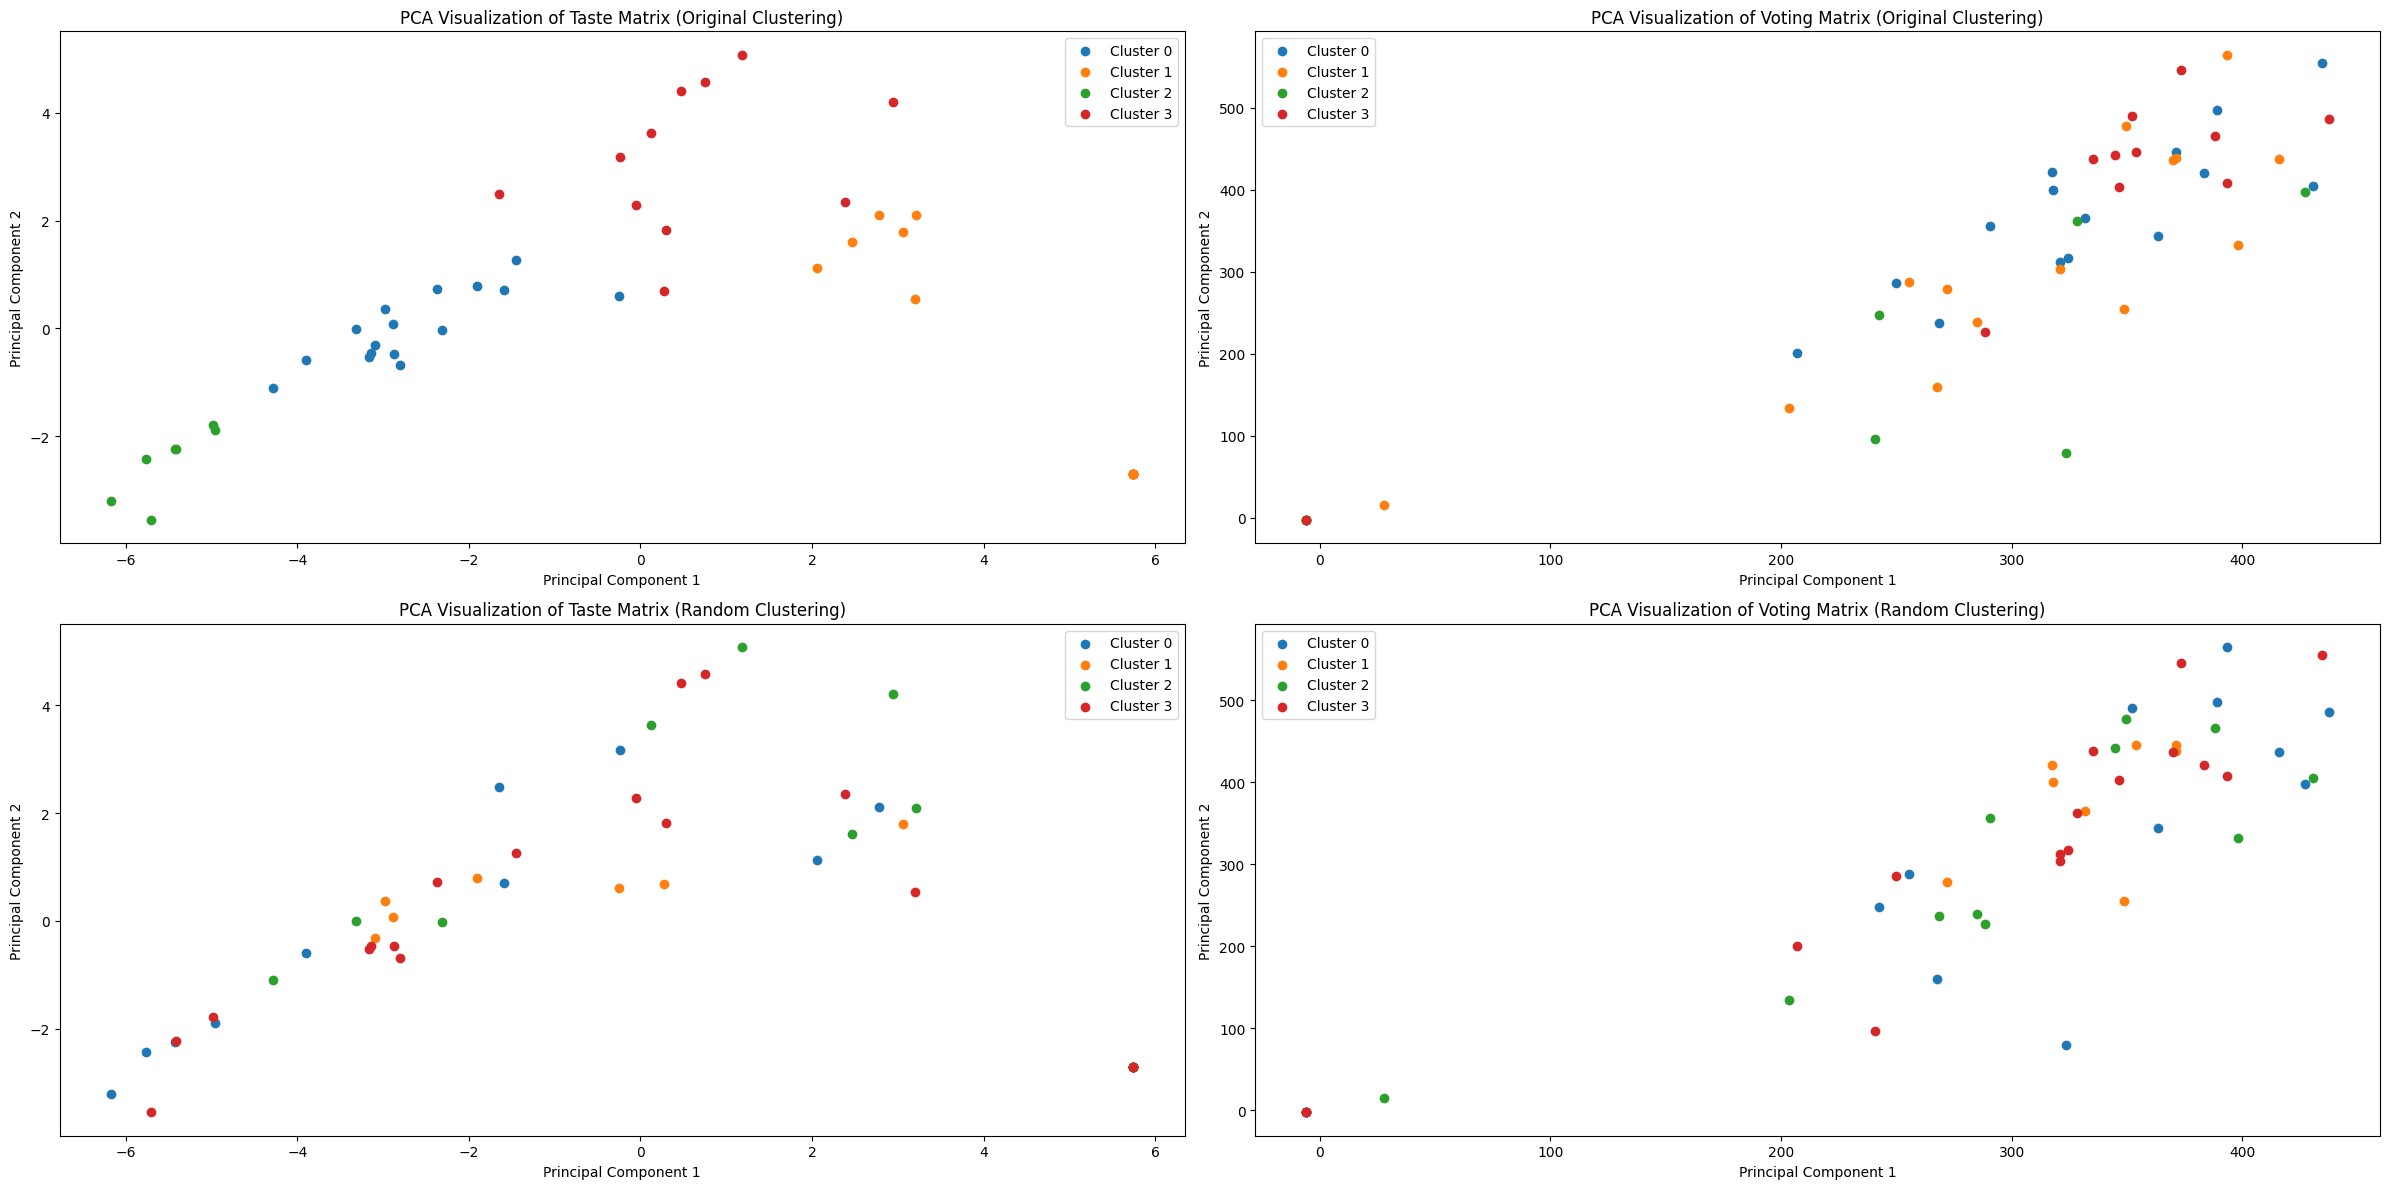

The silhouette score for Taste Matrix (Original) is: 0.20535540597417973
The silhouette score for Voting Matrix (Original) is: -0.045571566240683516
The silhouette score for Taste Matrix (Random) is: -0.06916510169080983
The silhouette score for Voting Matrix (Random) is: -0.05375432663382198


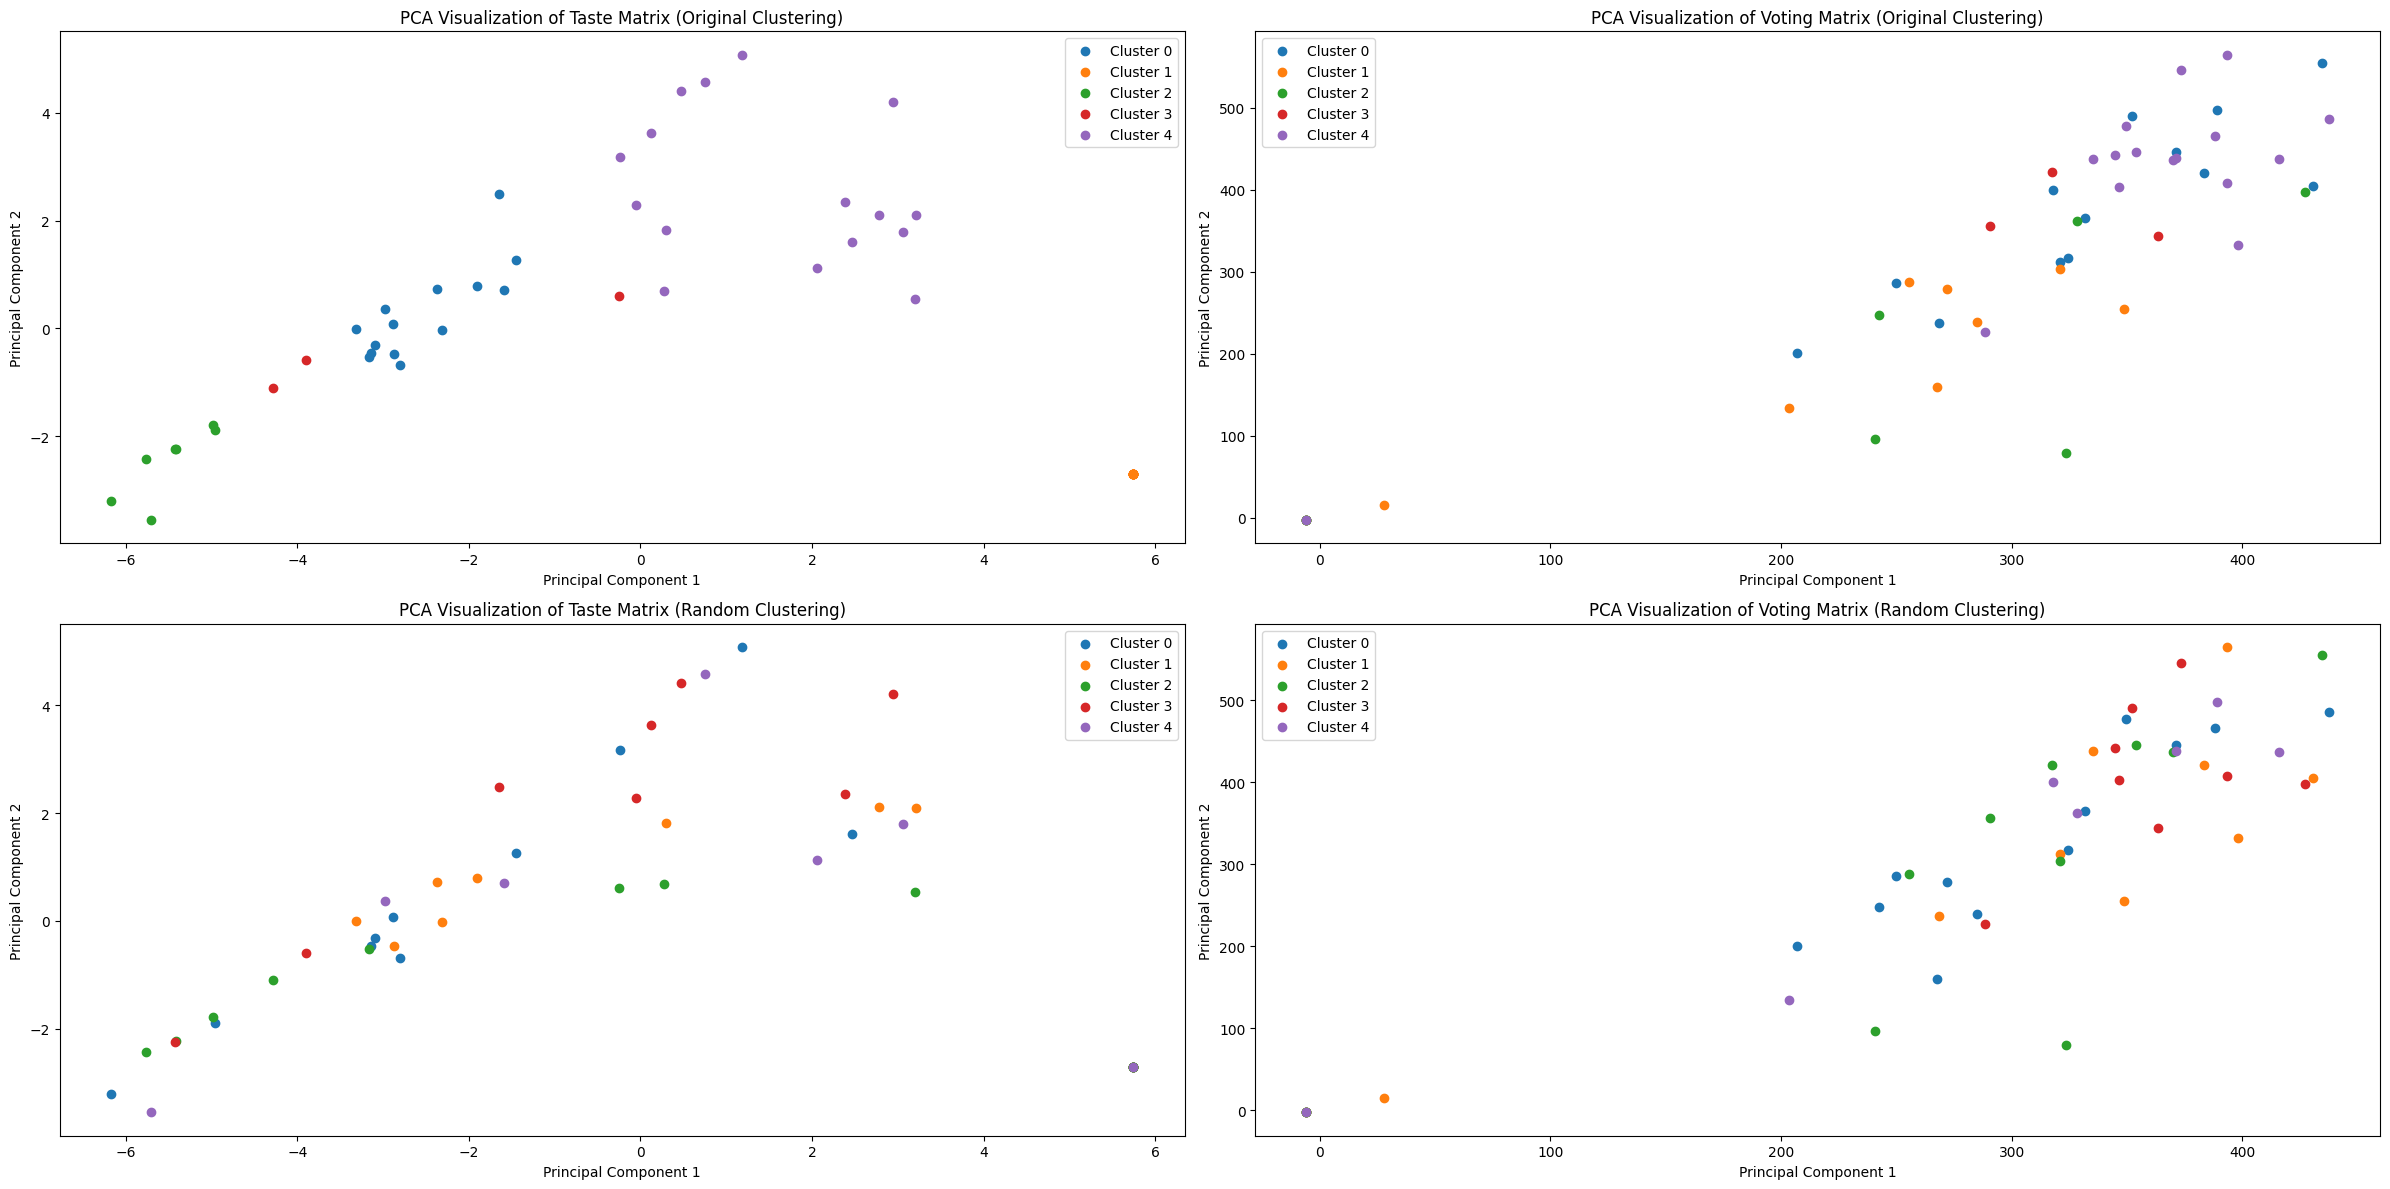

The silhouette score for Taste Matrix (Original) is: 0.28333725746742755
The silhouette score for Voting Matrix (Original) is: -0.09212067021647727
The silhouette score for Taste Matrix (Random) is: -0.06163323628247068
The silhouette score for Voting Matrix (Random) is: -0.06497560218180429


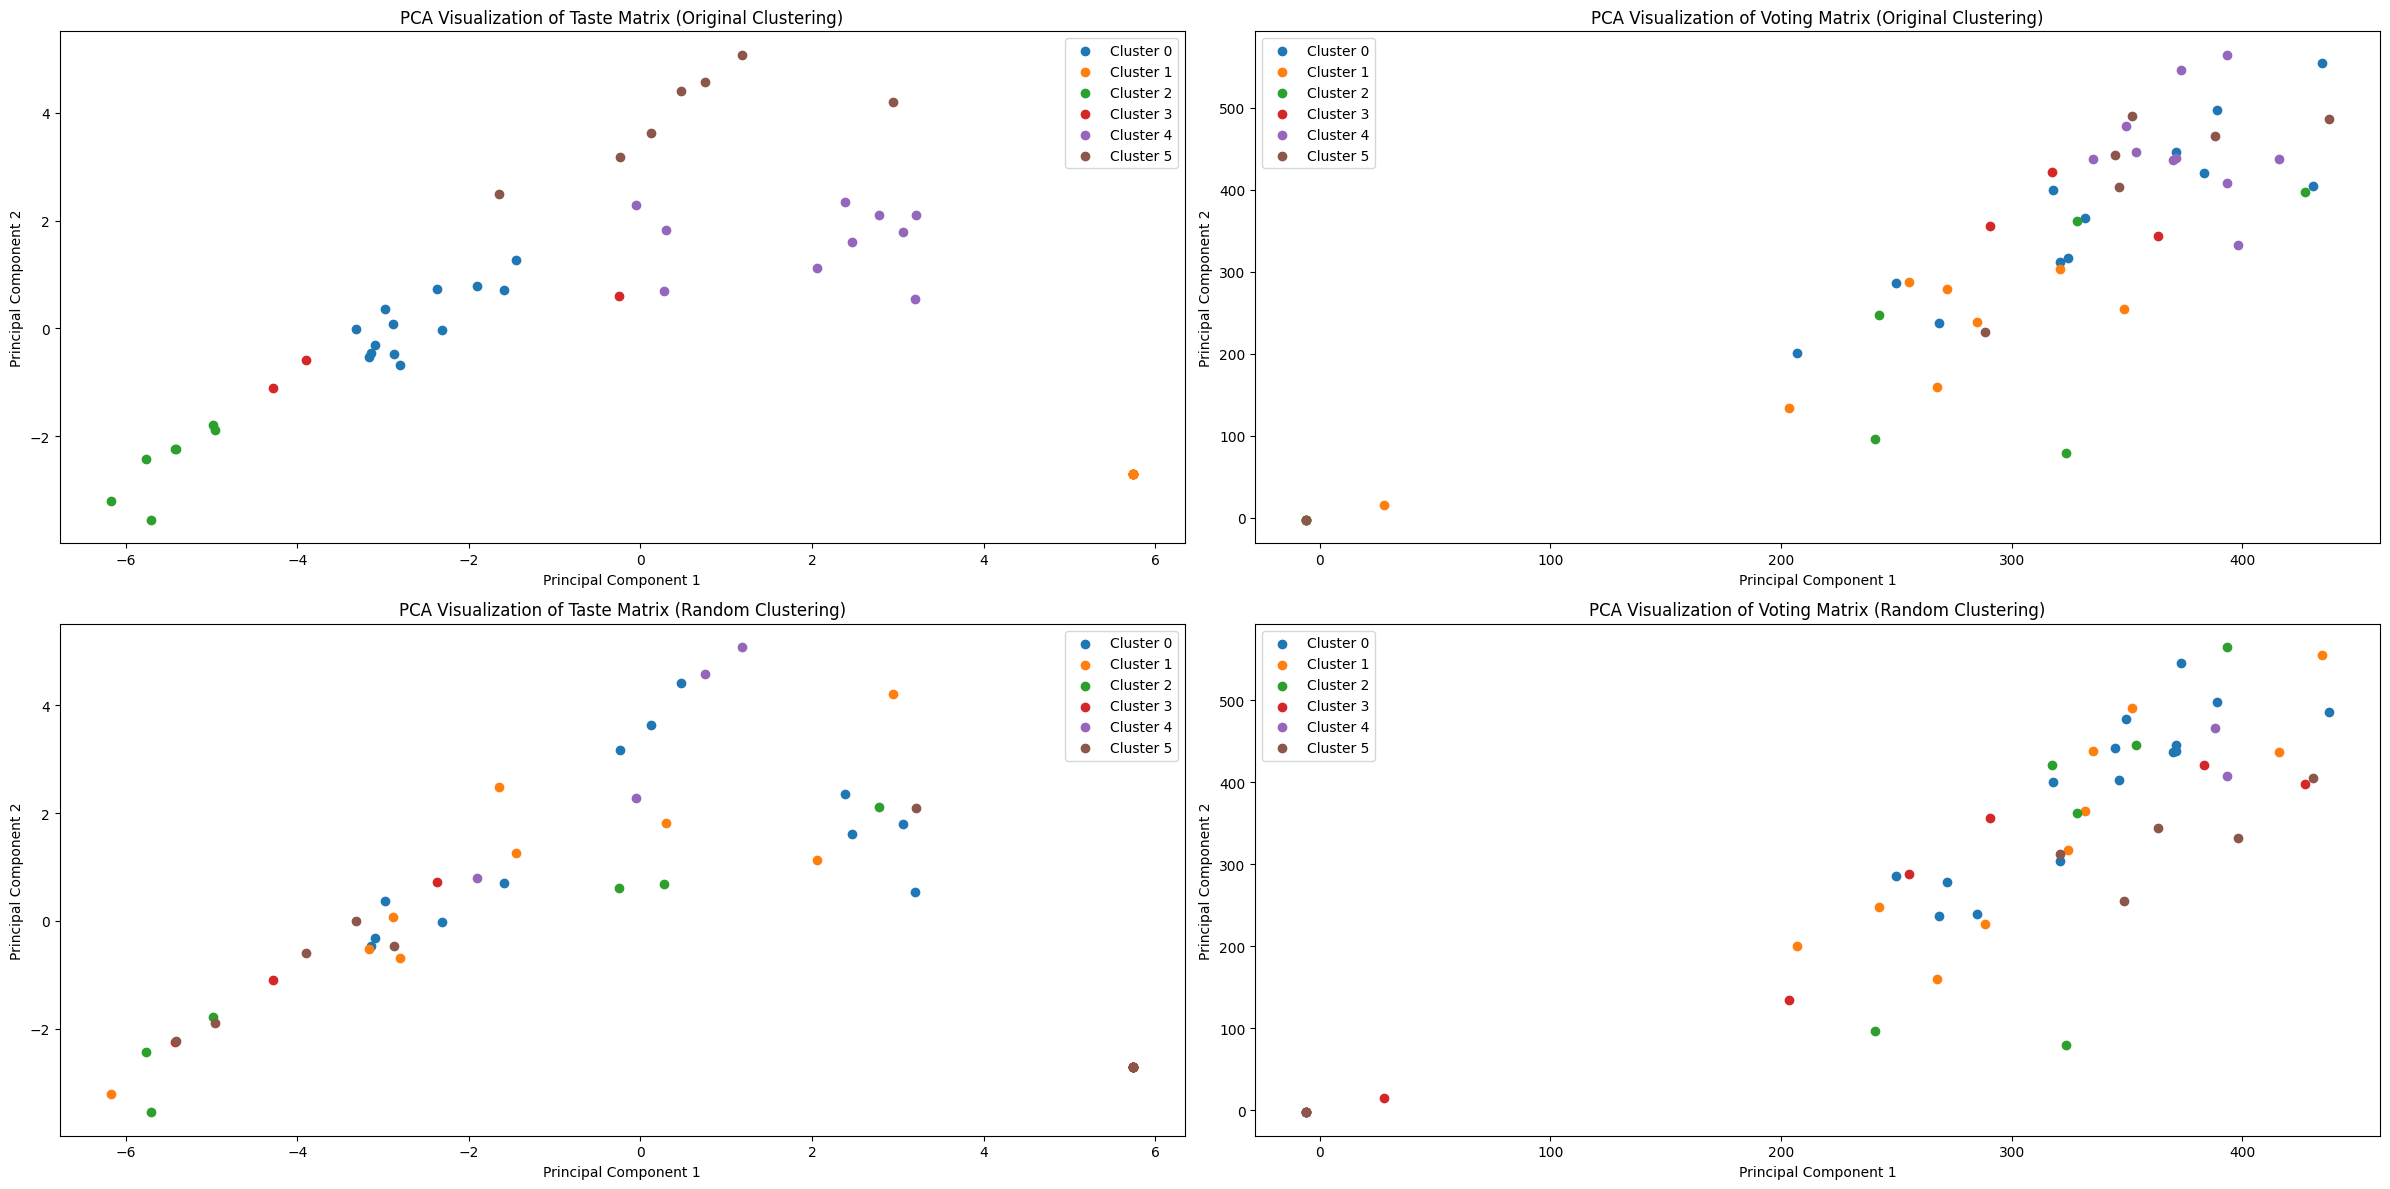

The silhouette score for Taste Matrix (Original) is: 0.29892921037985626
The silhouette score for Voting Matrix (Original) is: -0.09825592931565341
The silhouette score for Taste Matrix (Random) is: -0.08724024829069603
The silhouette score for Voting Matrix (Random) is: -0.07560315789366218


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


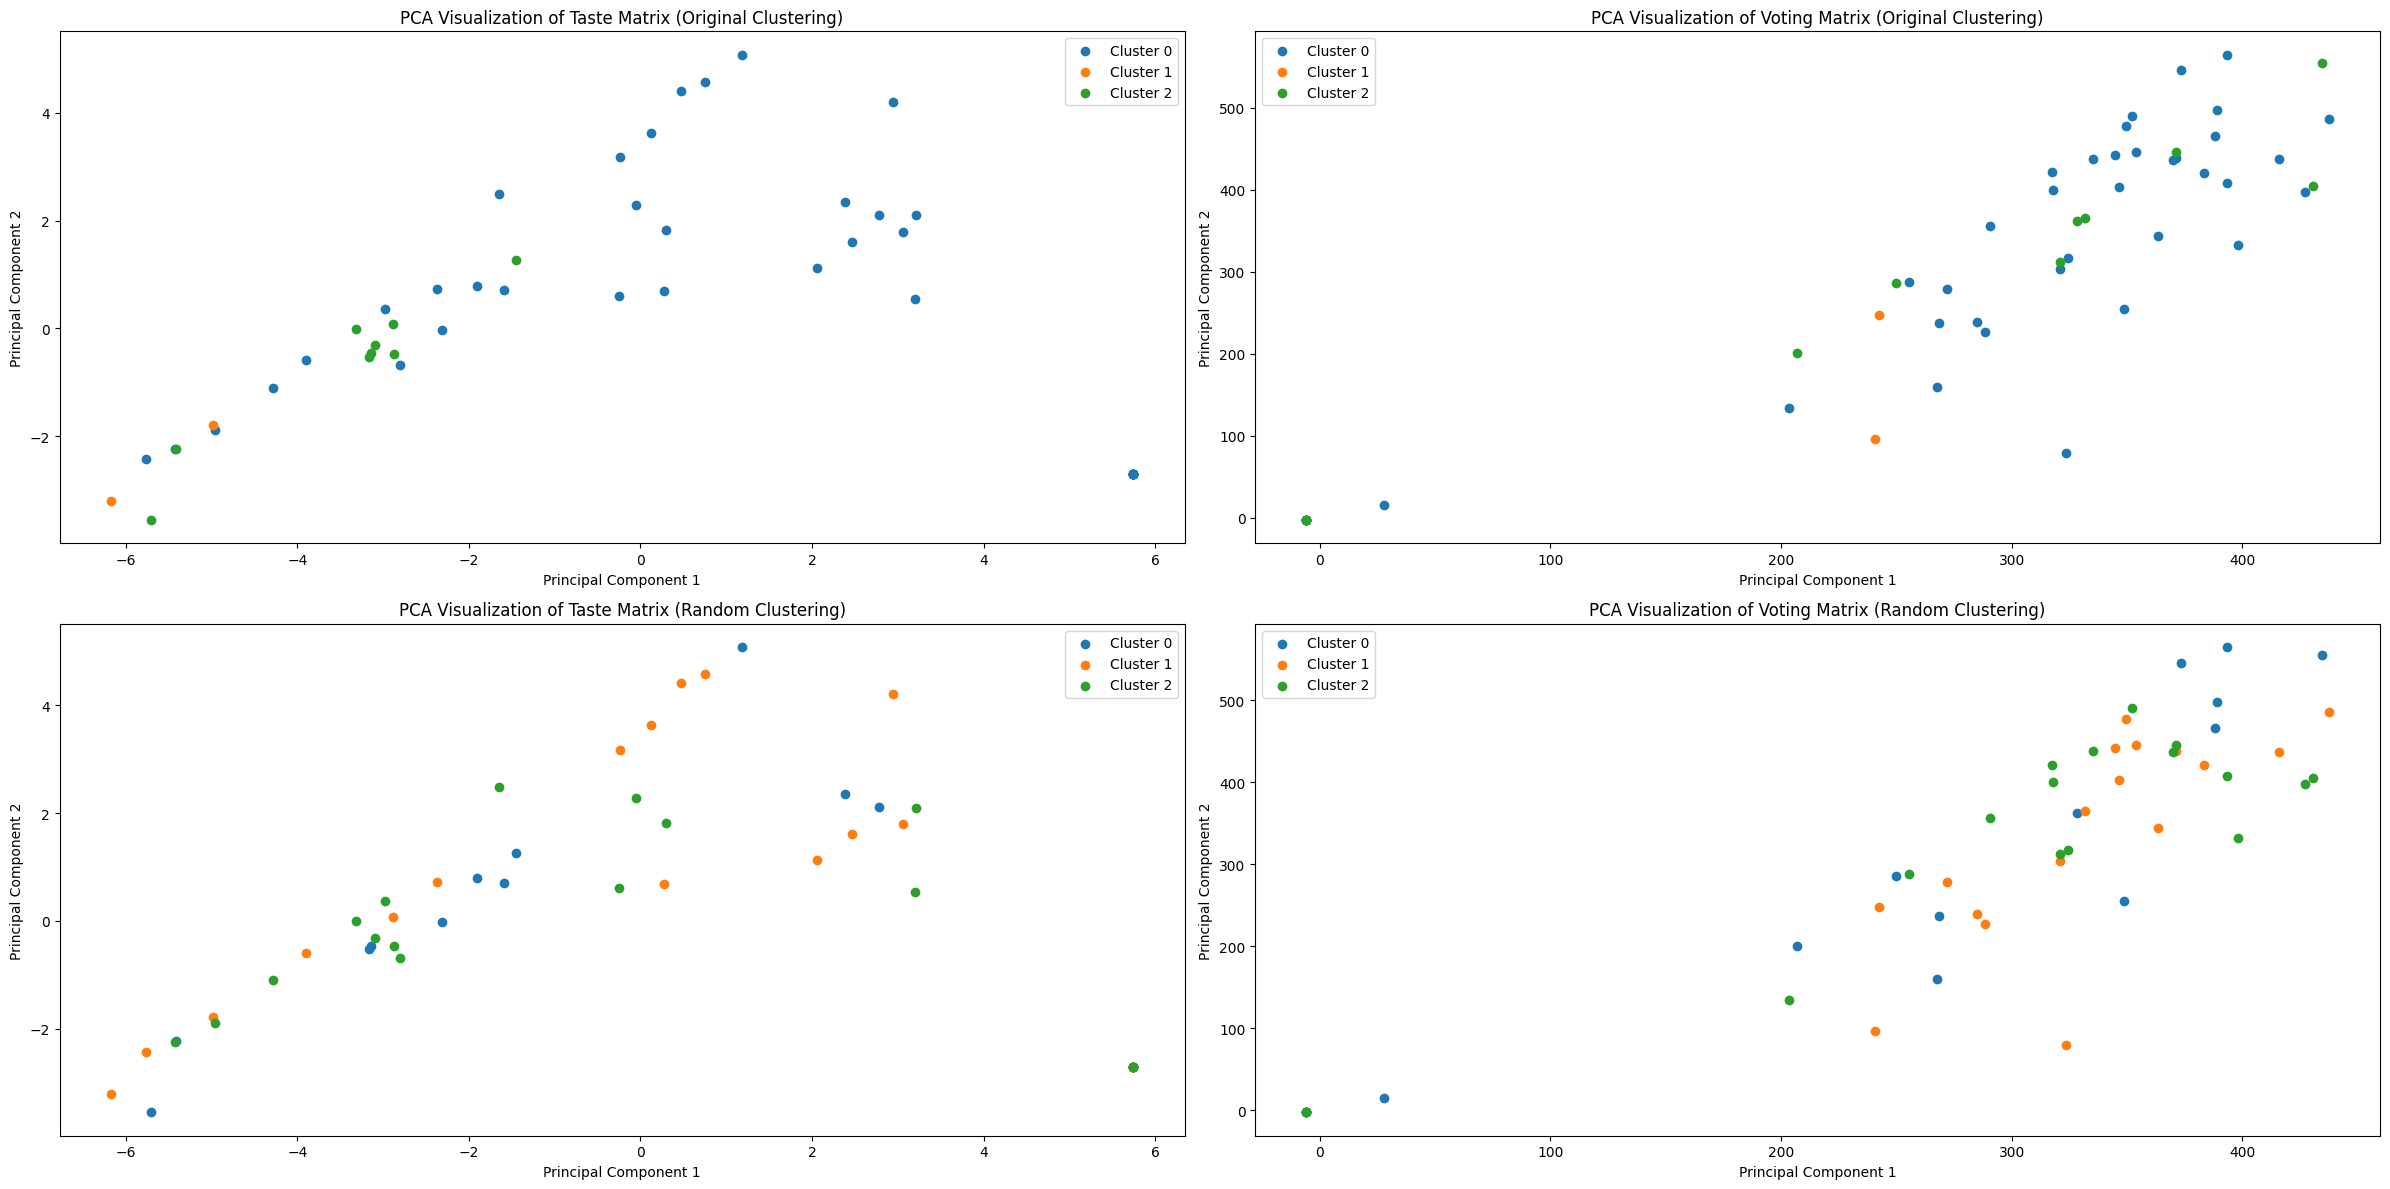

The silhouette score for Taste Matrix (Original) is: 0.13173443250188635
The silhouette score for Voting Matrix (Original) is: -0.08004182327153549
The silhouette score for Taste Matrix (Random) is: -0.02860792739769949
The silhouette score for Voting Matrix (Random) is: -0.03744423775072922


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


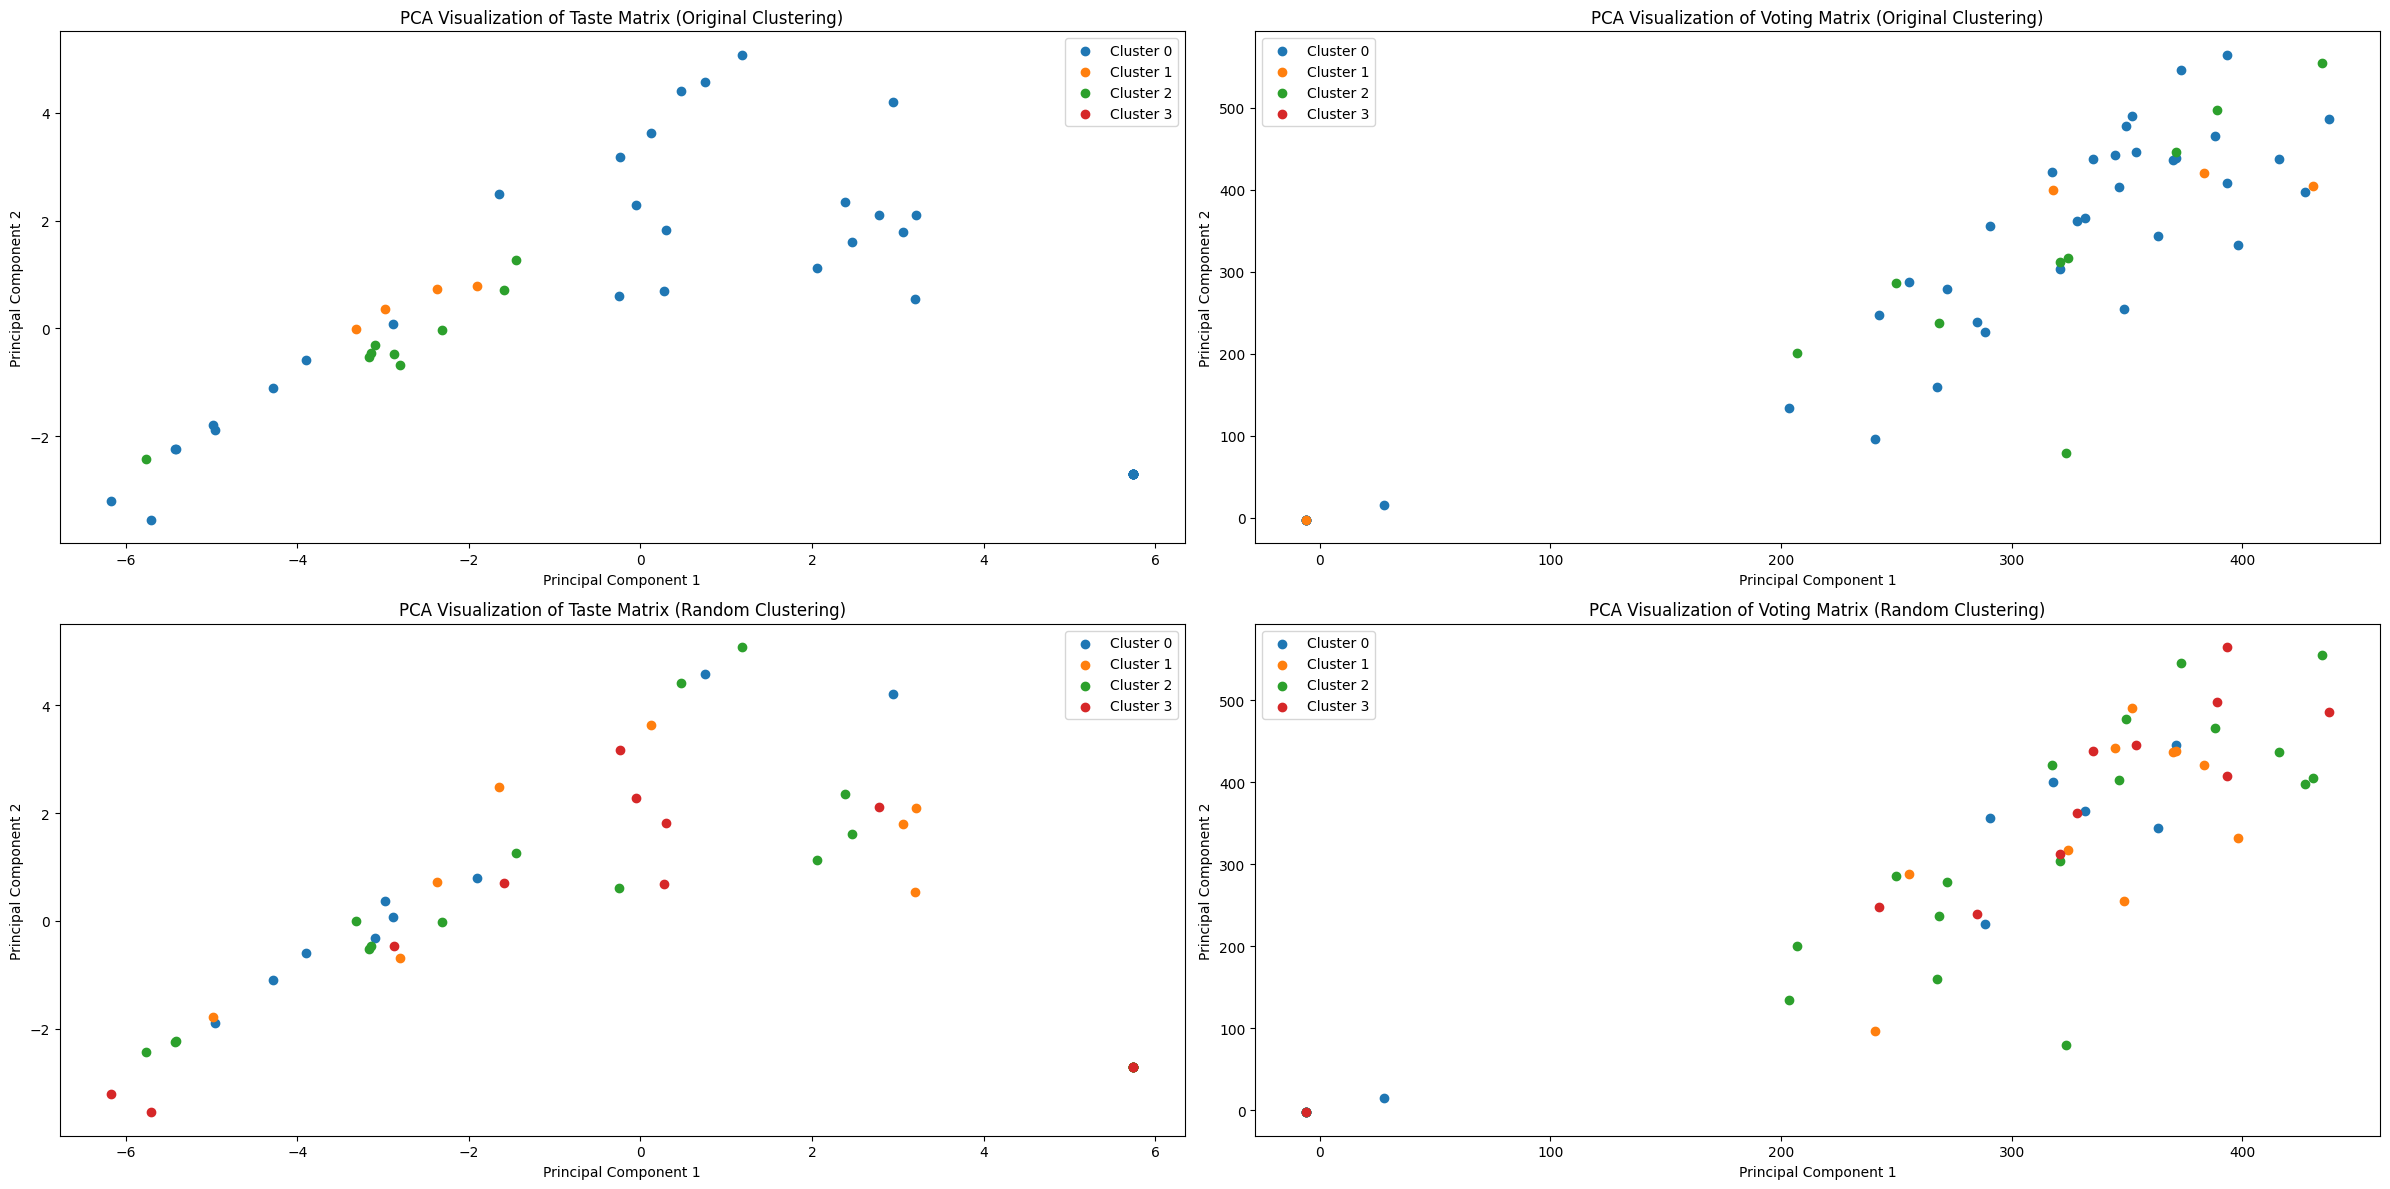

The silhouette score for Taste Matrix (Original) is: 0.09731321796451654
The silhouette score for Voting Matrix (Original) is: -0.033490140313657435
The silhouette score for Taste Matrix (Random) is: -0.05345032063234944
The silhouette score for Voting Matrix (Random) is: -0.035026586334687214


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


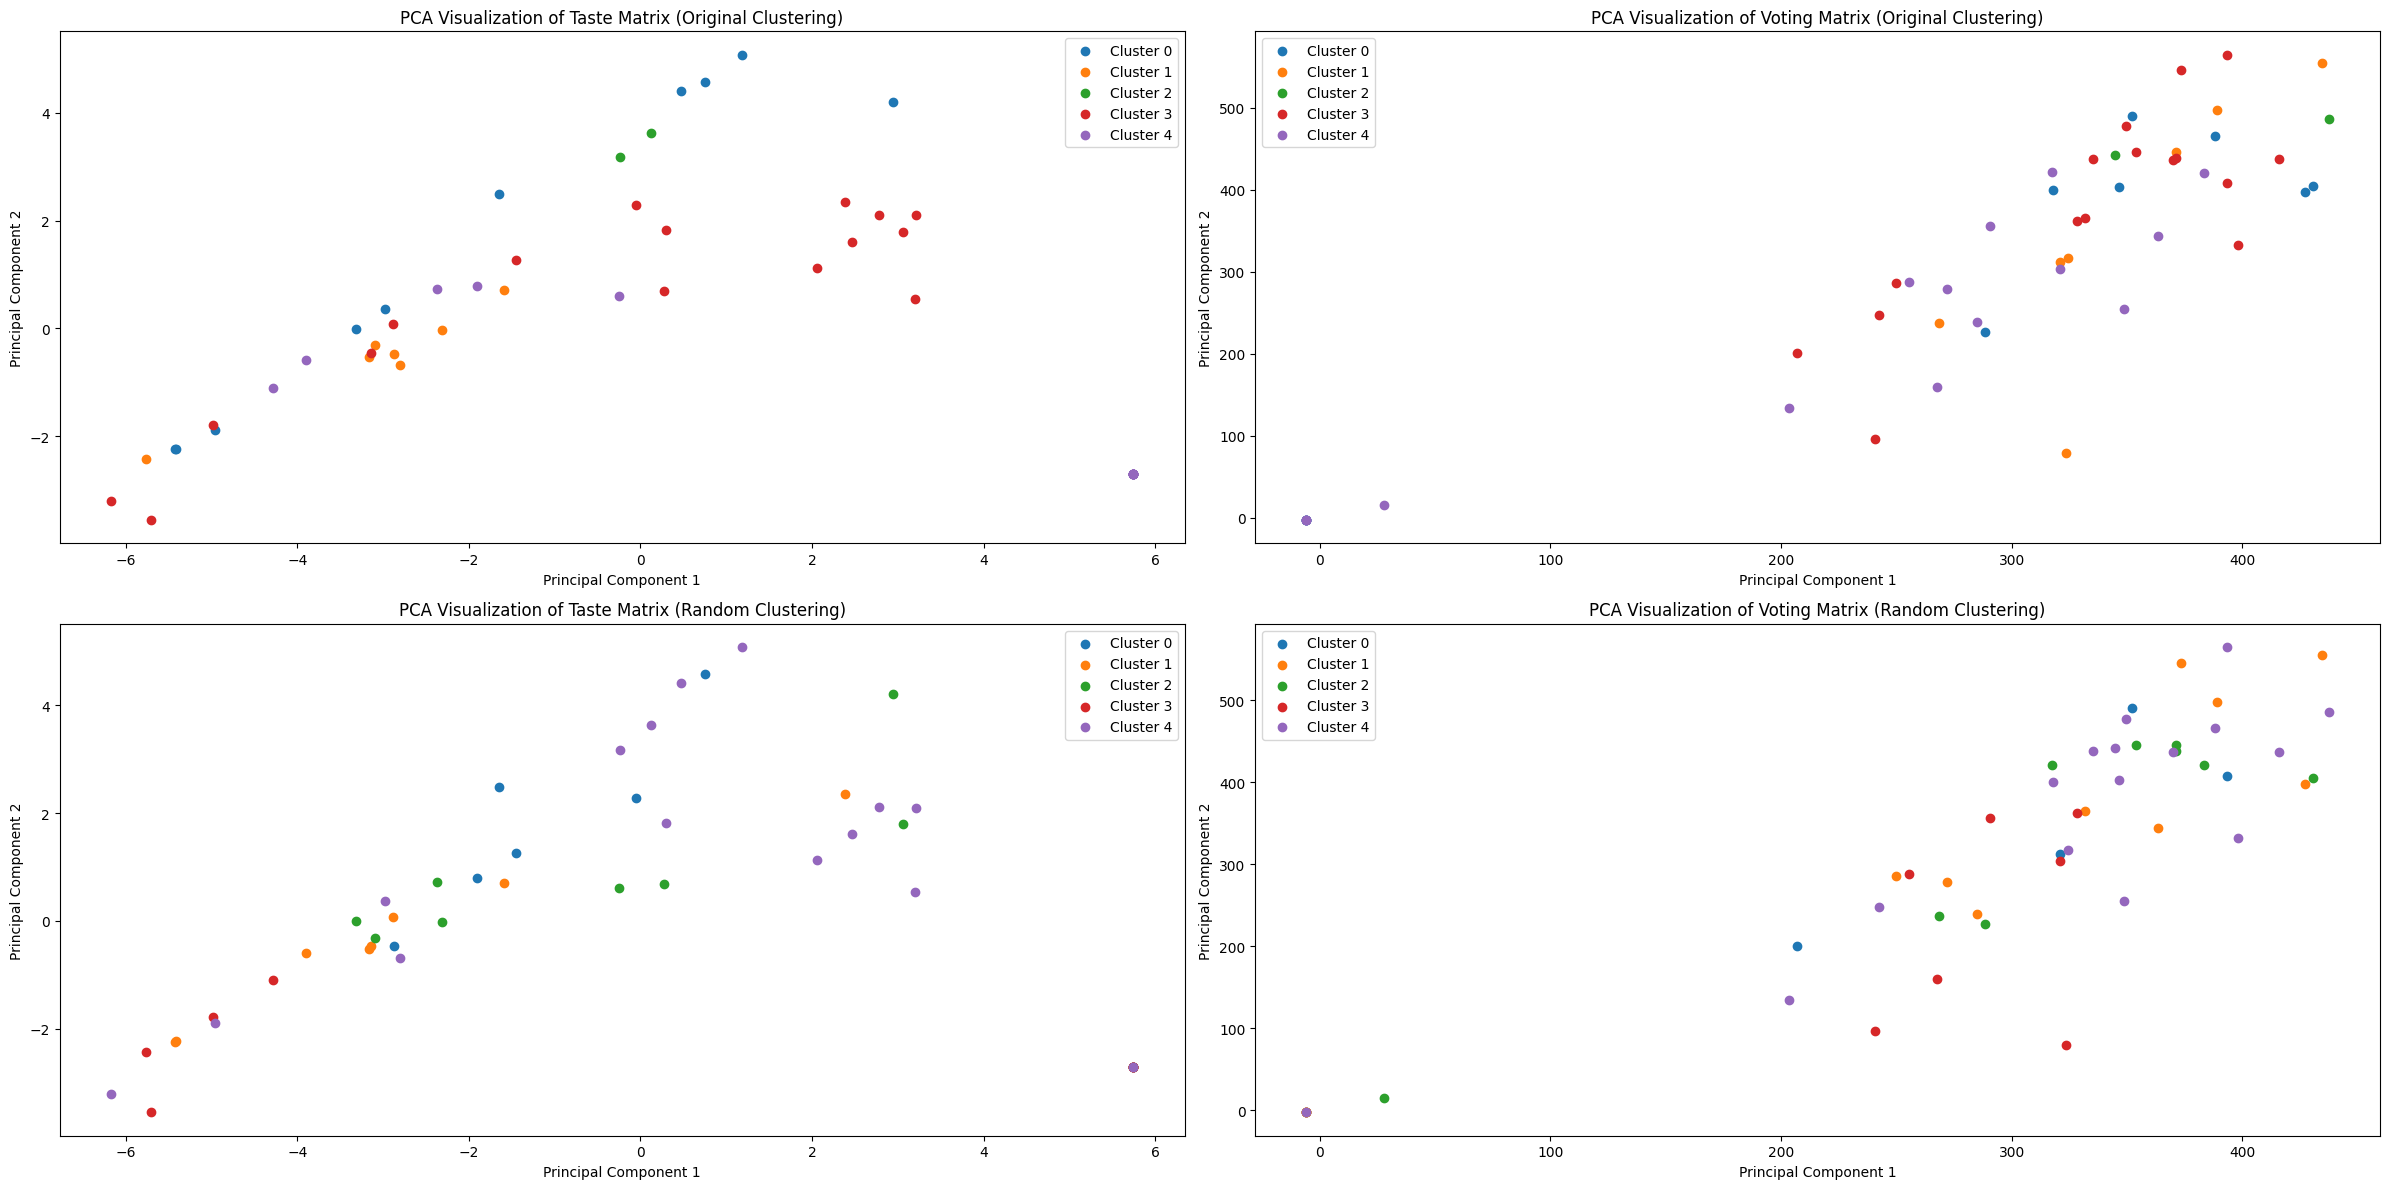

The silhouette score for Taste Matrix (Original) is: 0.1135878105124042
The silhouette score for Voting Matrix (Original) is: -0.07699958304100443
The silhouette score for Taste Matrix (Random) is: -0.0589971639230742
The silhouette score for Voting Matrix (Random) is: -0.06093903469970858


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


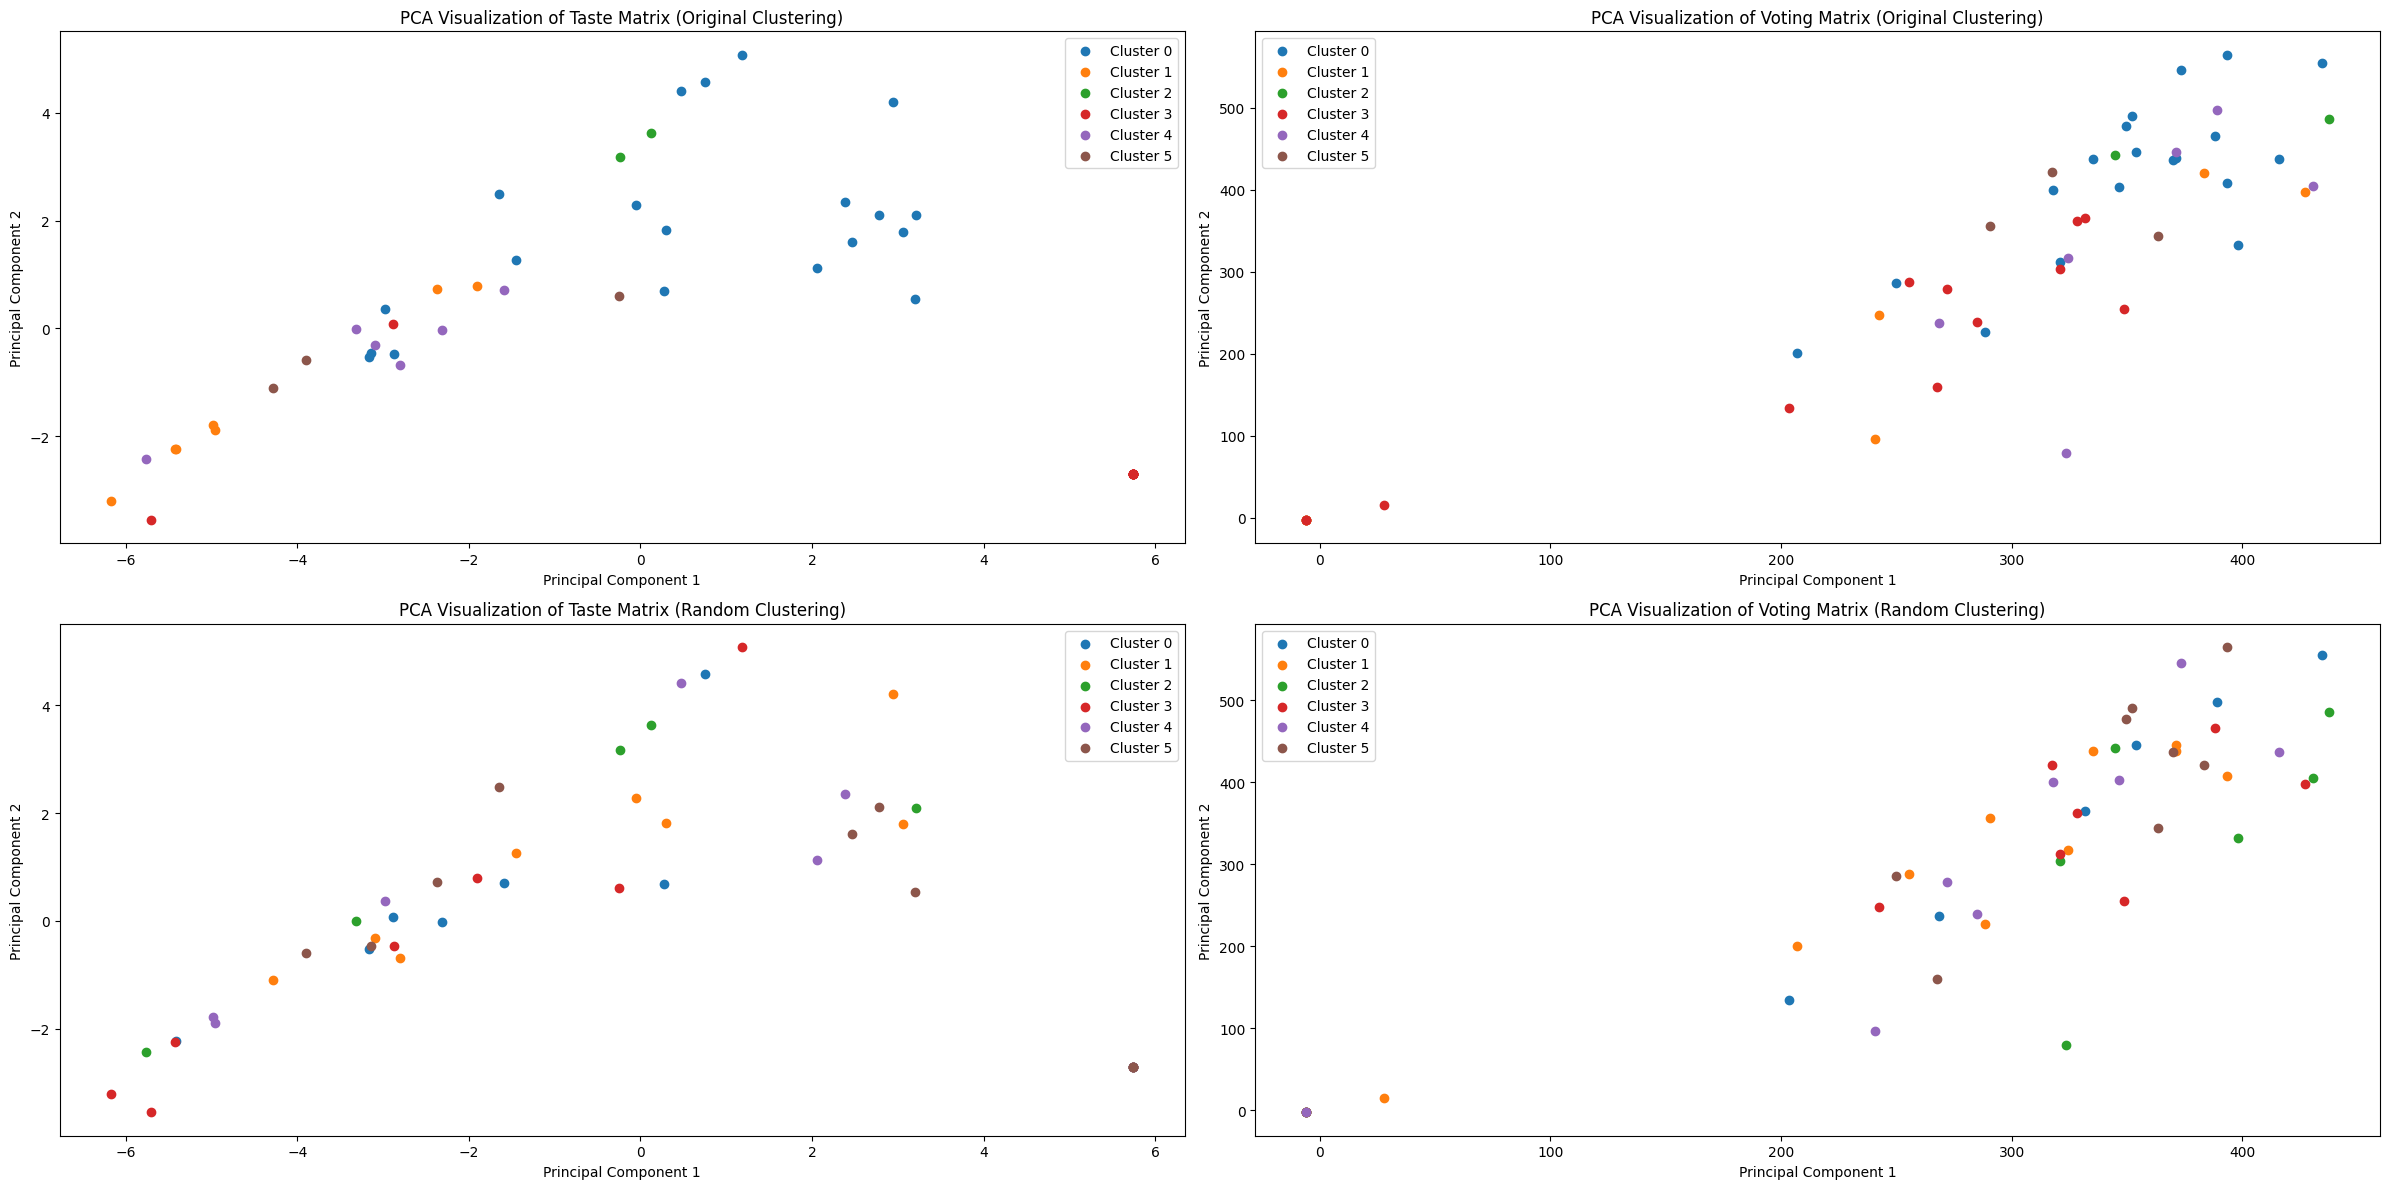

The silhouette score for Taste Matrix (Original) is: 0.19511085690248017
The silhouette score for Voting Matrix (Original) is: -0.10078760906249709
The silhouette score for Taste Matrix (Random) is: -0.07658357867815542
The silhouette score for Voting Matrix (Random) is: -0.08075112457030215


In [5]:
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 3, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 4, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 5, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 6, method='KMeans')

clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_jury, 6, method='SpectralClustering')

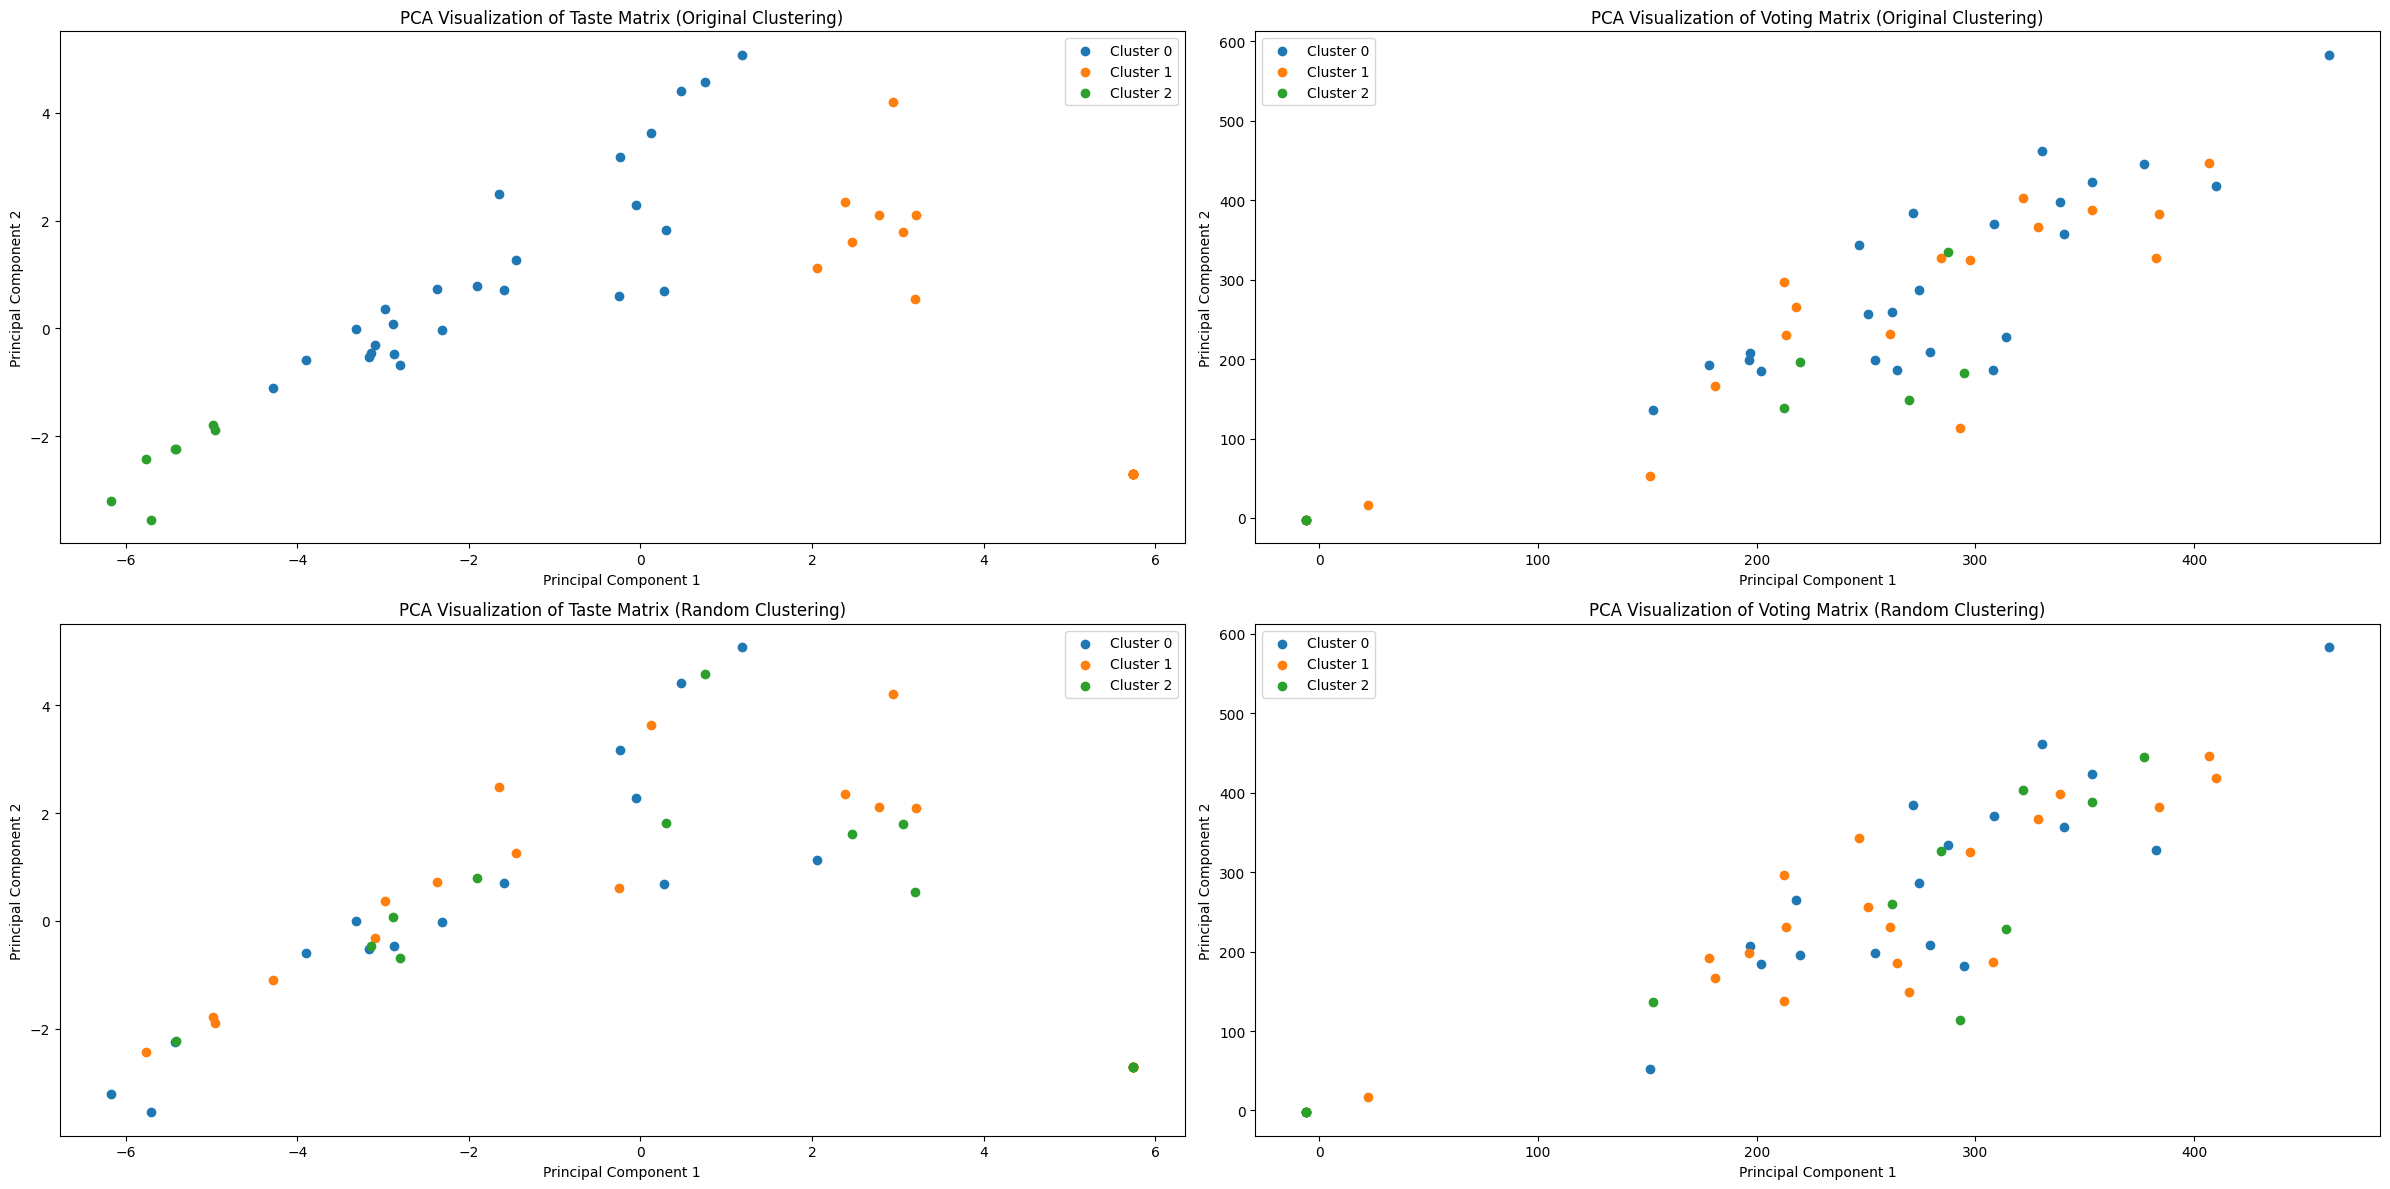

The silhouette score for Taste Matrix (Original) is: 0.21094828288866002
The silhouette score for Voting Matrix (Original) is: -0.02668577898967687
The silhouette score for Taste Matrix (Random) is: -0.03814532319870043
The silhouette score for Voting Matrix (Random) is: -0.018968048278890575


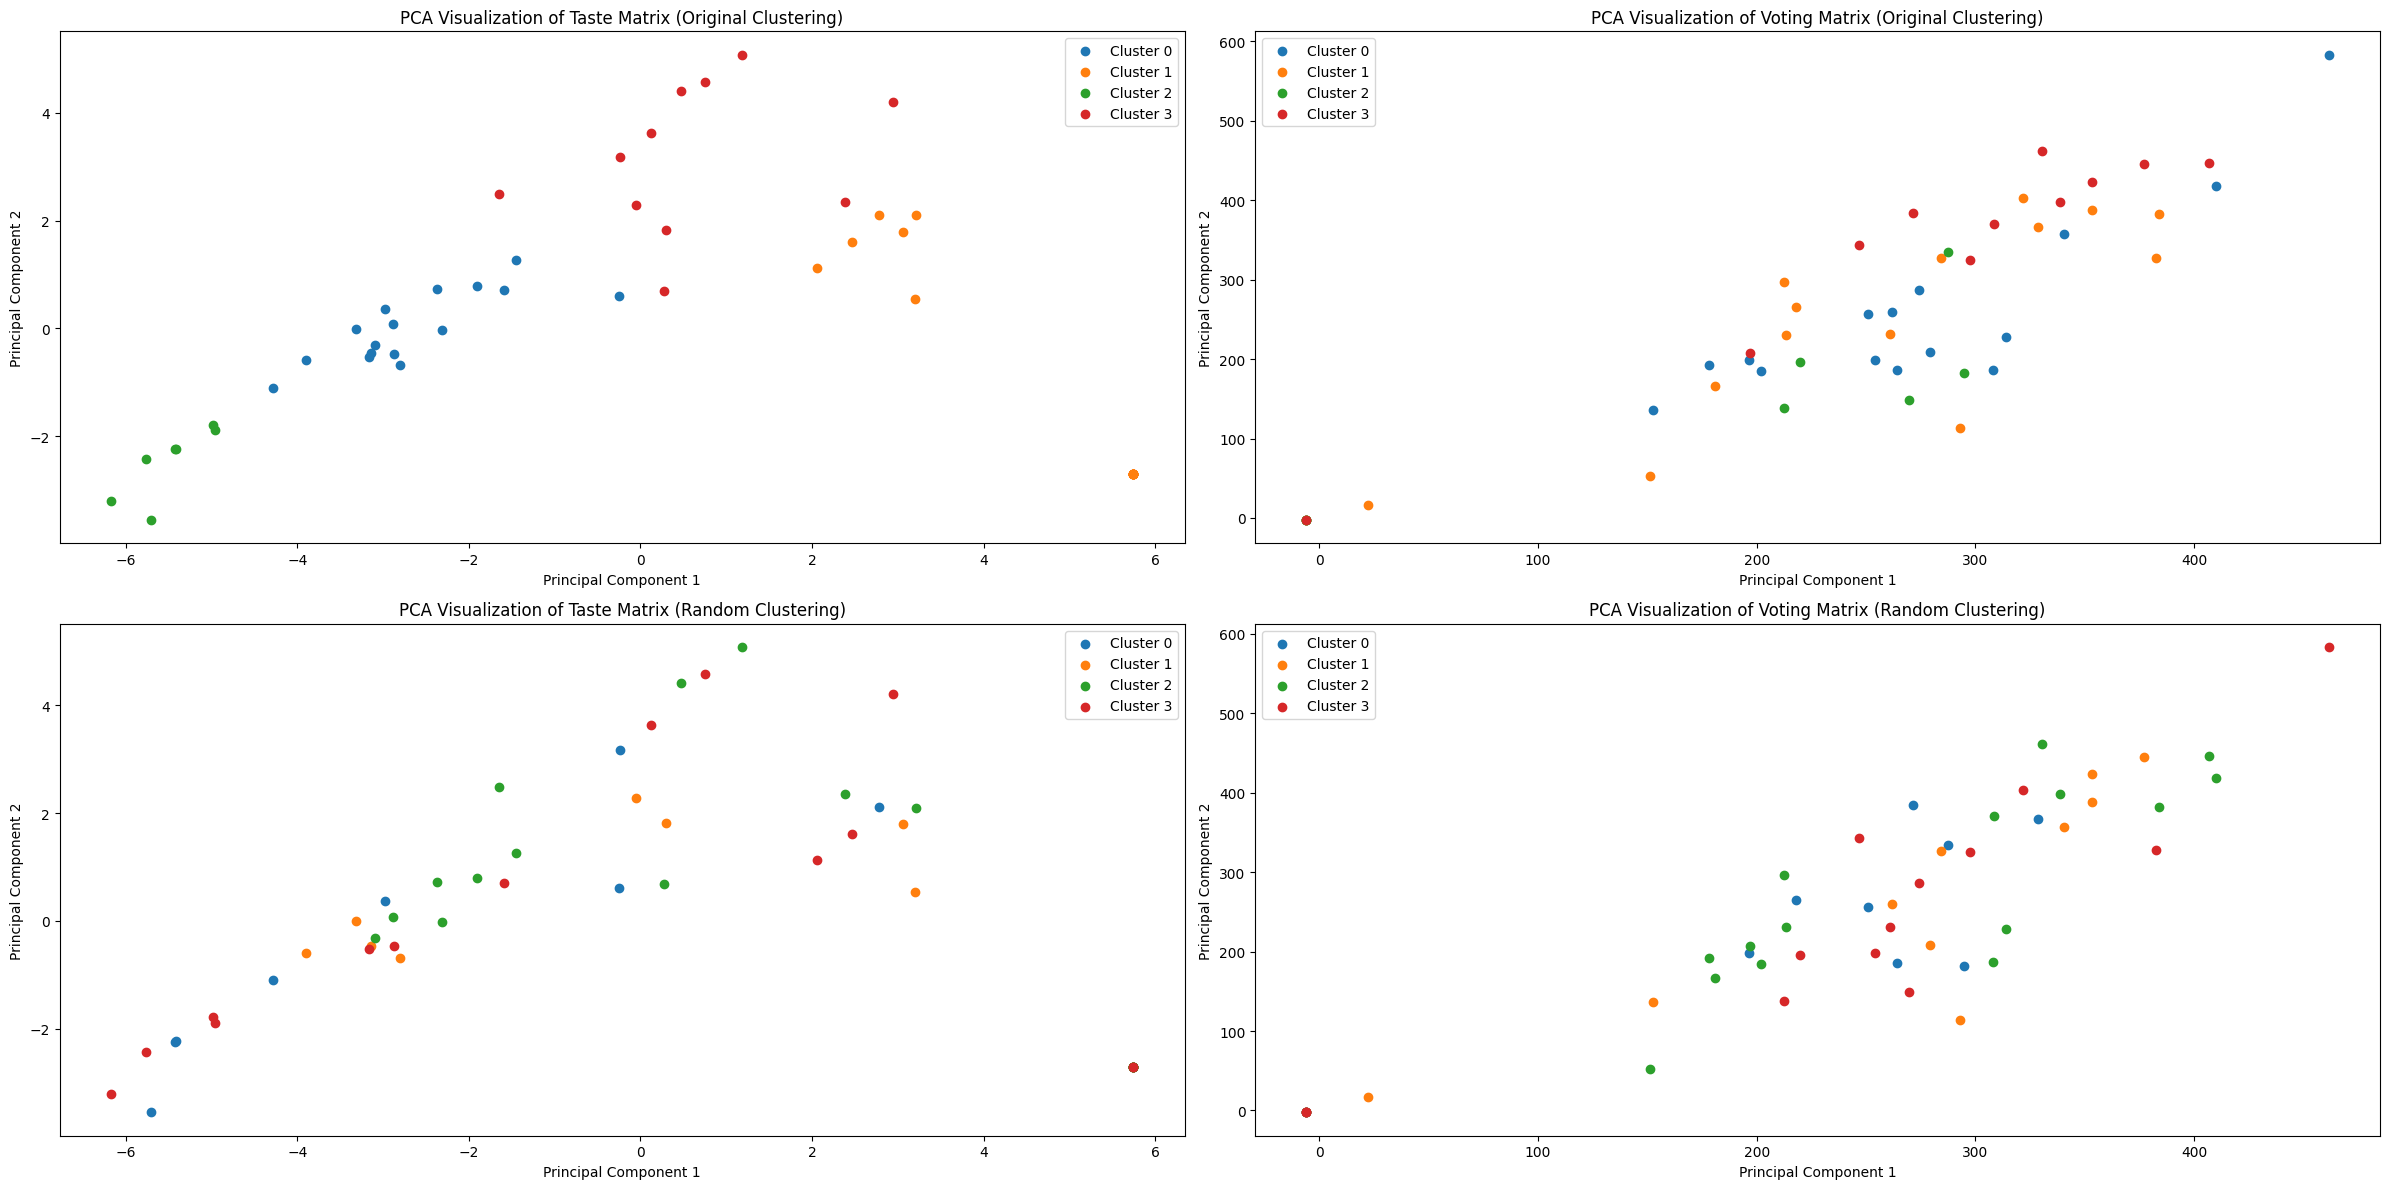

The silhouette score for Taste Matrix (Original) is: 0.20535540597417973
The silhouette score for Voting Matrix (Original) is: -0.040537700044102634
The silhouette score for Taste Matrix (Random) is: -0.05160700275660149
The silhouette score for Voting Matrix (Random) is: -0.045168604276642016


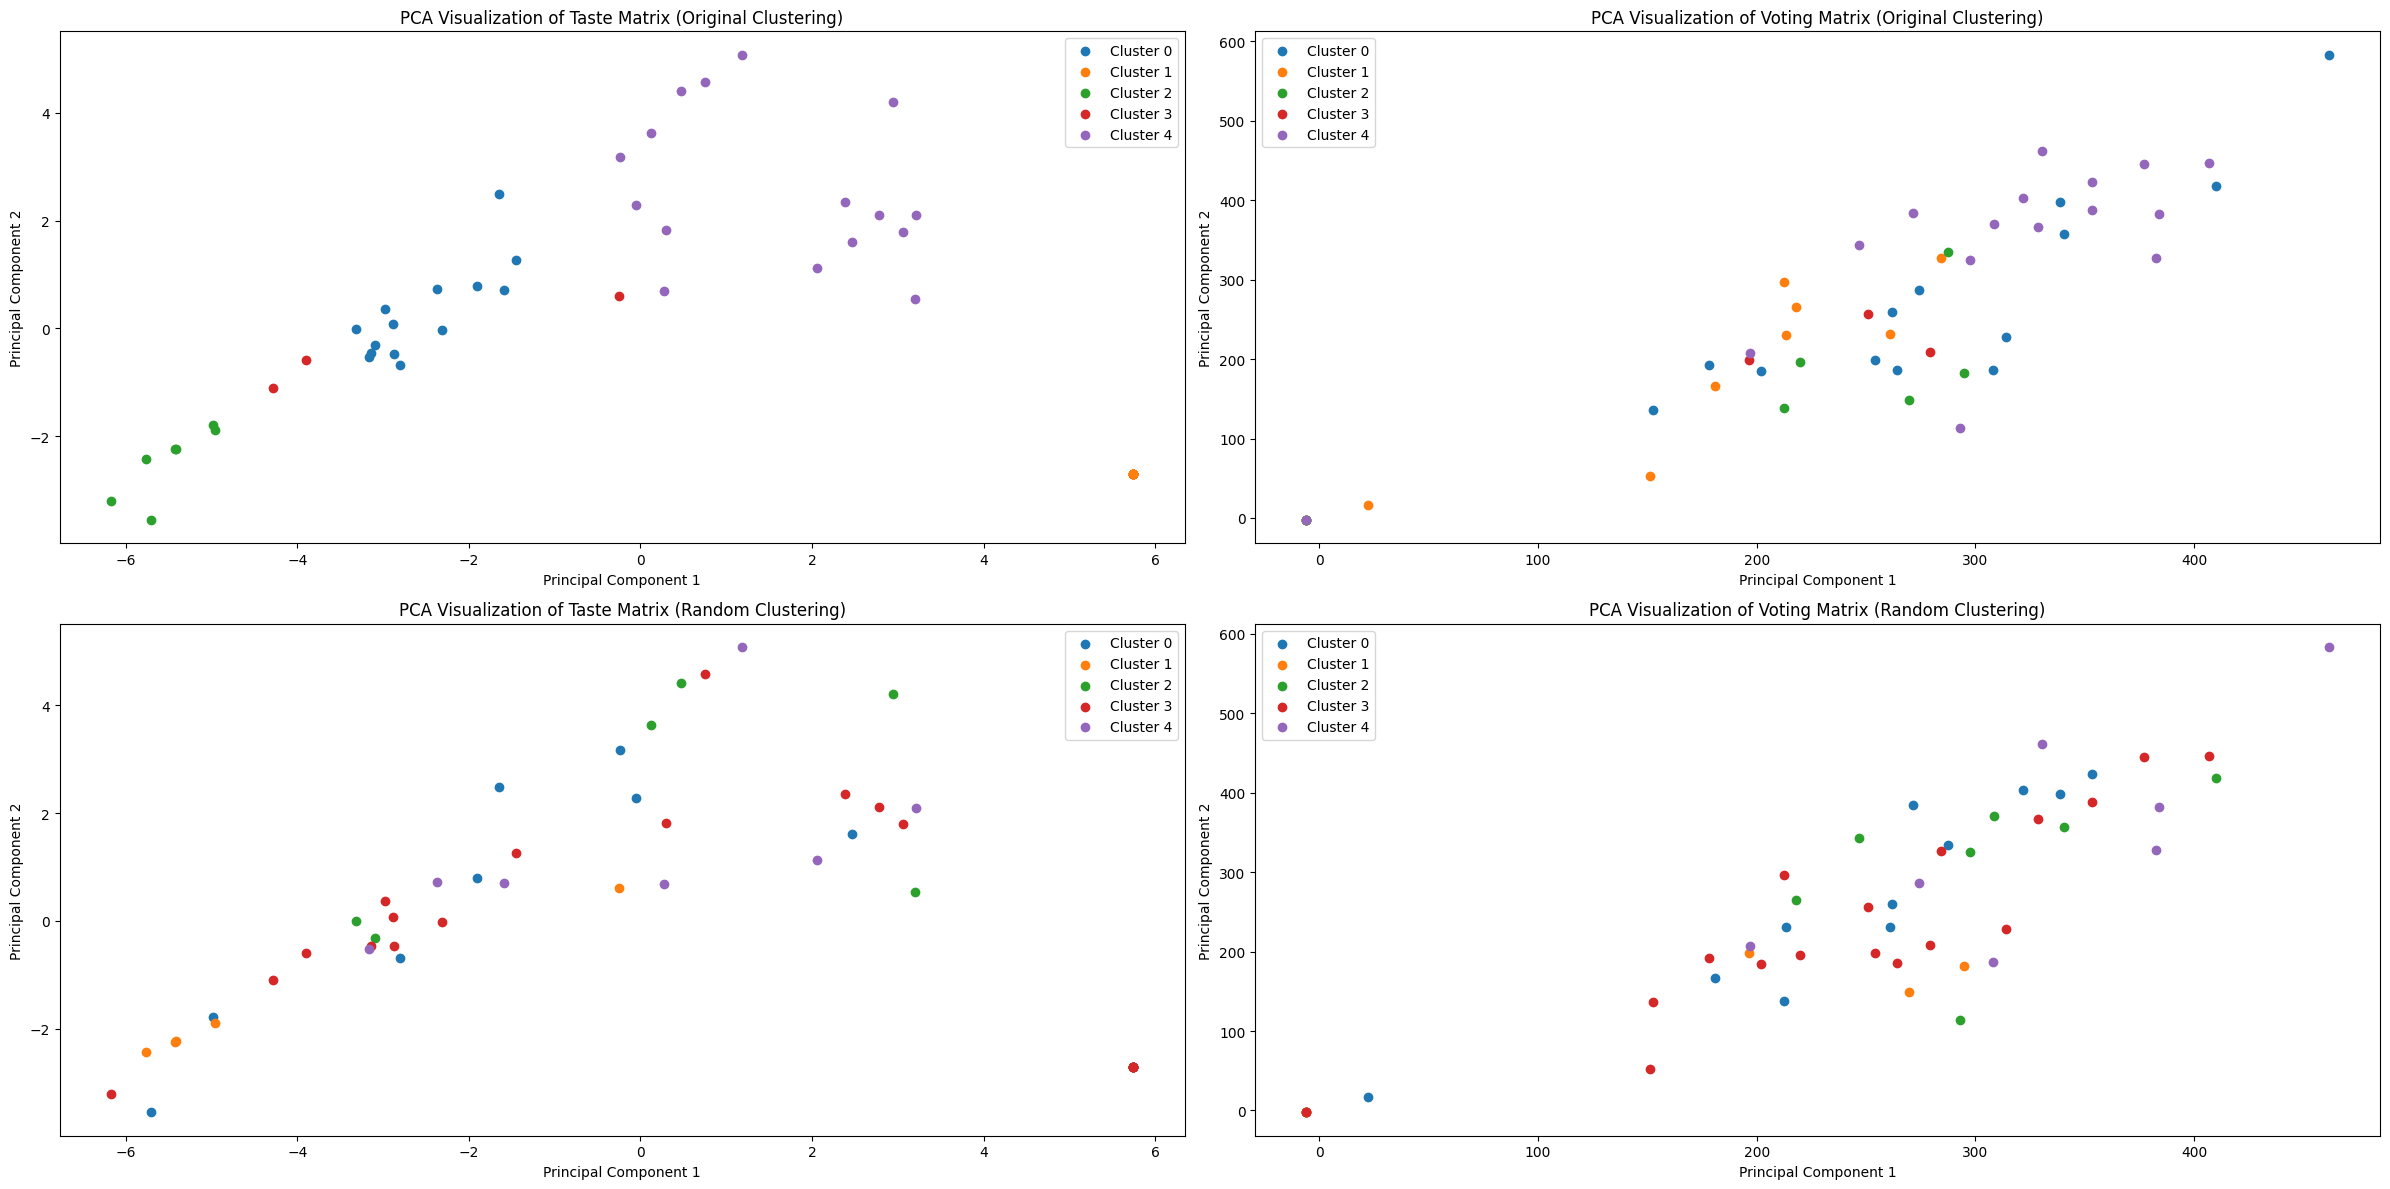

The silhouette score for Taste Matrix (Original) is: 0.28333725746742755
The silhouette score for Voting Matrix (Original) is: -0.05257350238310522
The silhouette score for Taste Matrix (Random) is: -0.07105151667518525
The silhouette score for Voting Matrix (Random) is: -0.06404037187034244


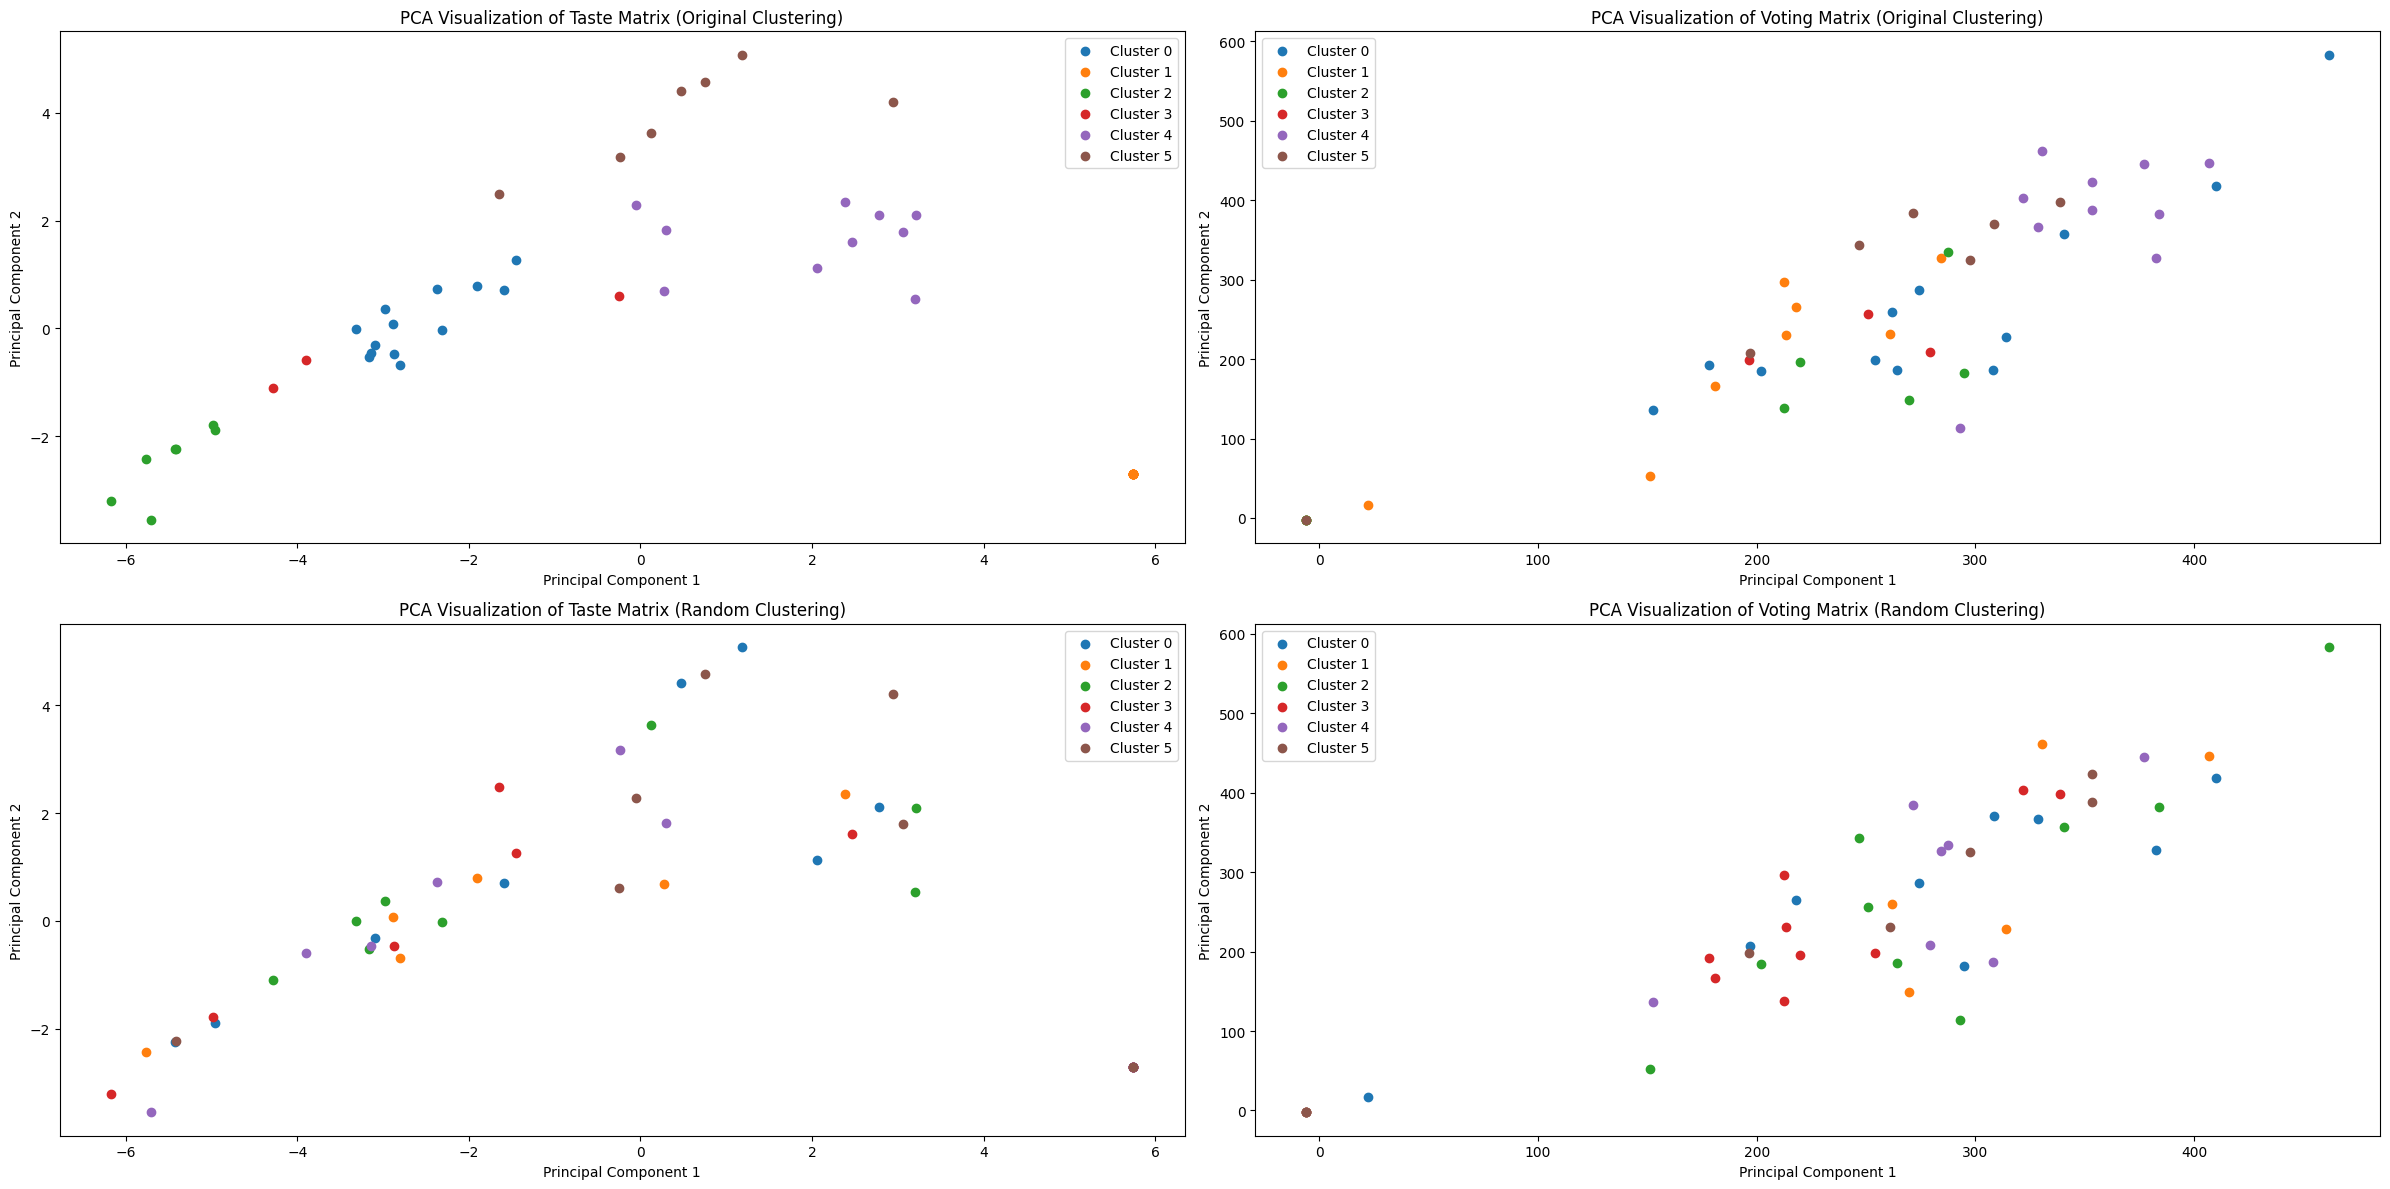

The silhouette score for Taste Matrix (Original) is: 0.29892921037985626
The silhouette score for Voting Matrix (Original) is: -0.04739321953922323
The silhouette score for Taste Matrix (Random) is: -0.08397411333361028
The silhouette score for Voting Matrix (Random) is: -0.09397473046051012


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


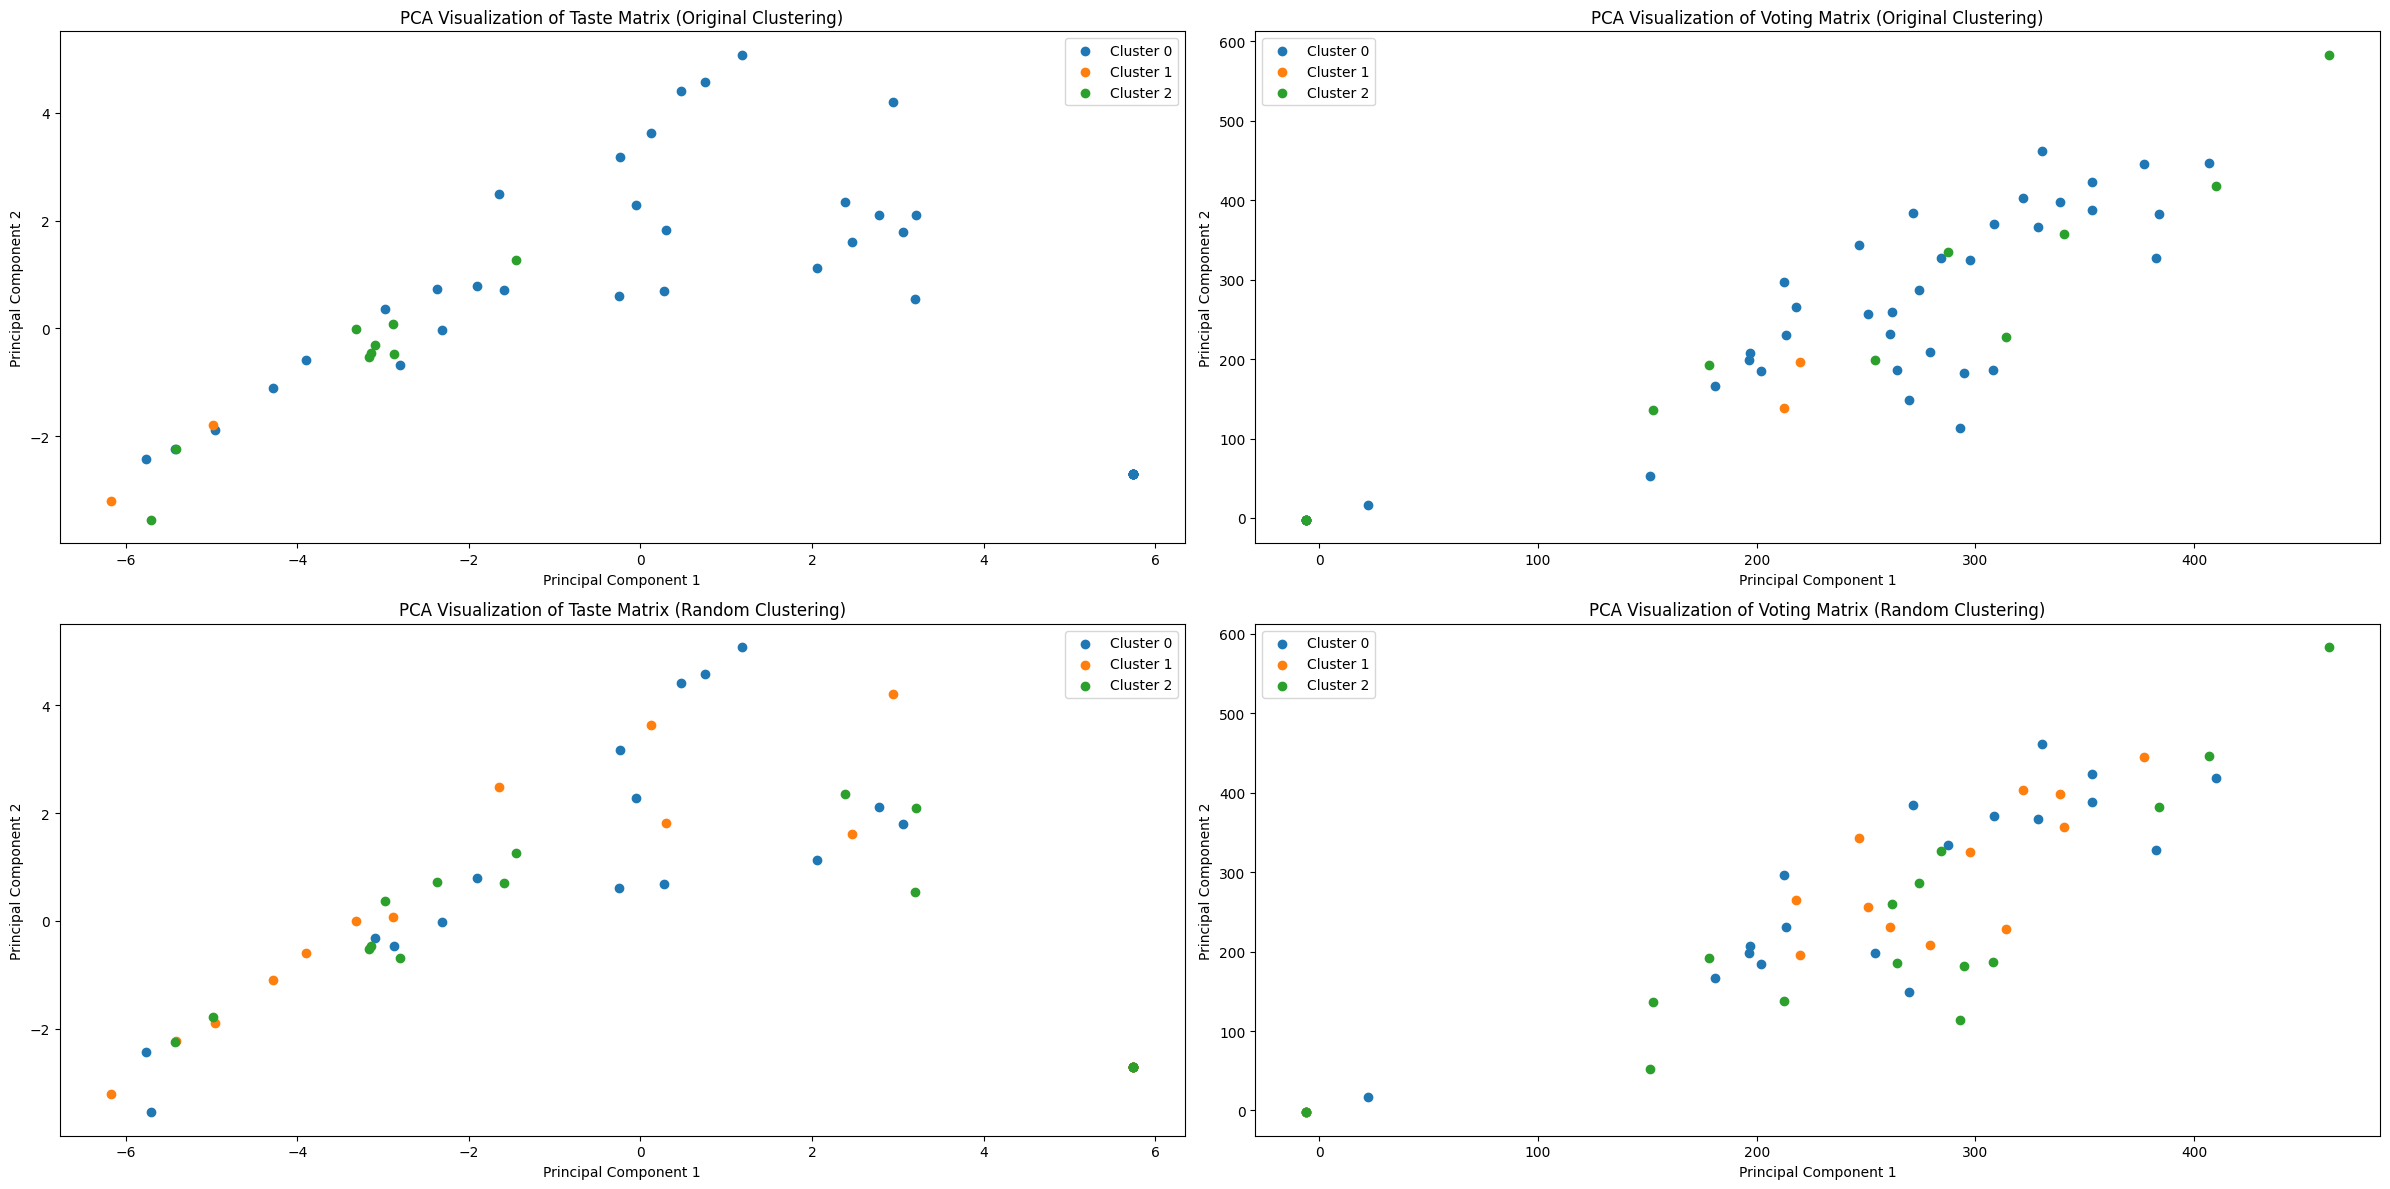

The silhouette score for Taste Matrix (Original) is: 0.13173443250188635
The silhouette score for Voting Matrix (Original) is: -0.13053570555440155
The silhouette score for Taste Matrix (Random) is: -0.027372563866705155
The silhouette score for Voting Matrix (Random) is: -0.023479933459202563


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


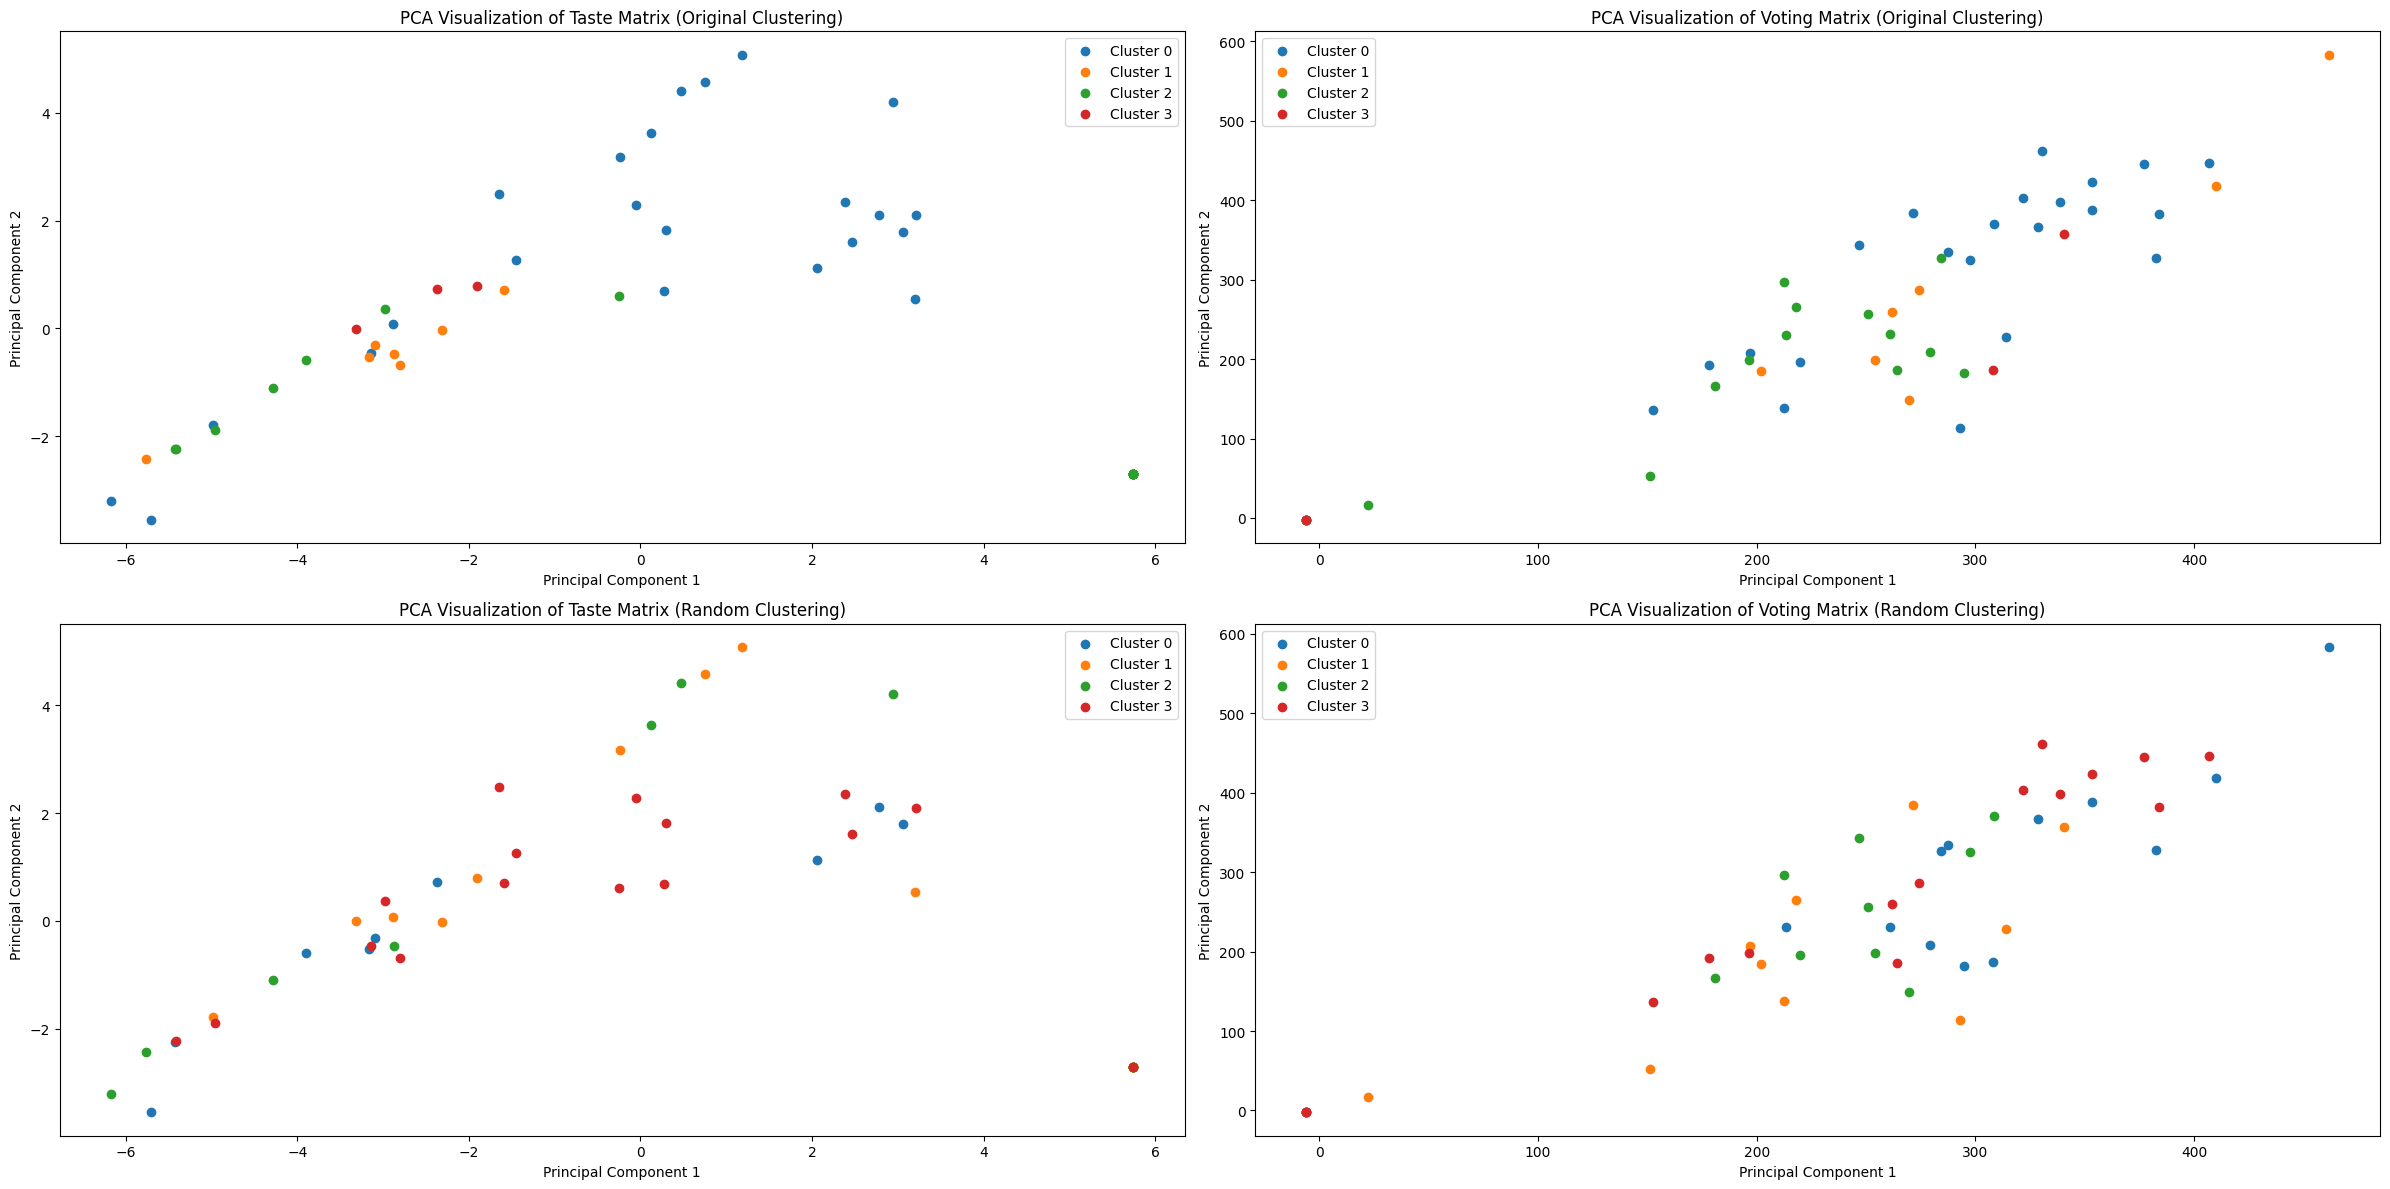

The silhouette score for Taste Matrix (Original) is: 0.12063505058643022
The silhouette score for Voting Matrix (Original) is: -0.039461288761855534
The silhouette score for Taste Matrix (Random) is: -0.047799195182239
The silhouette score for Voting Matrix (Random) is: -0.03616090689083649


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


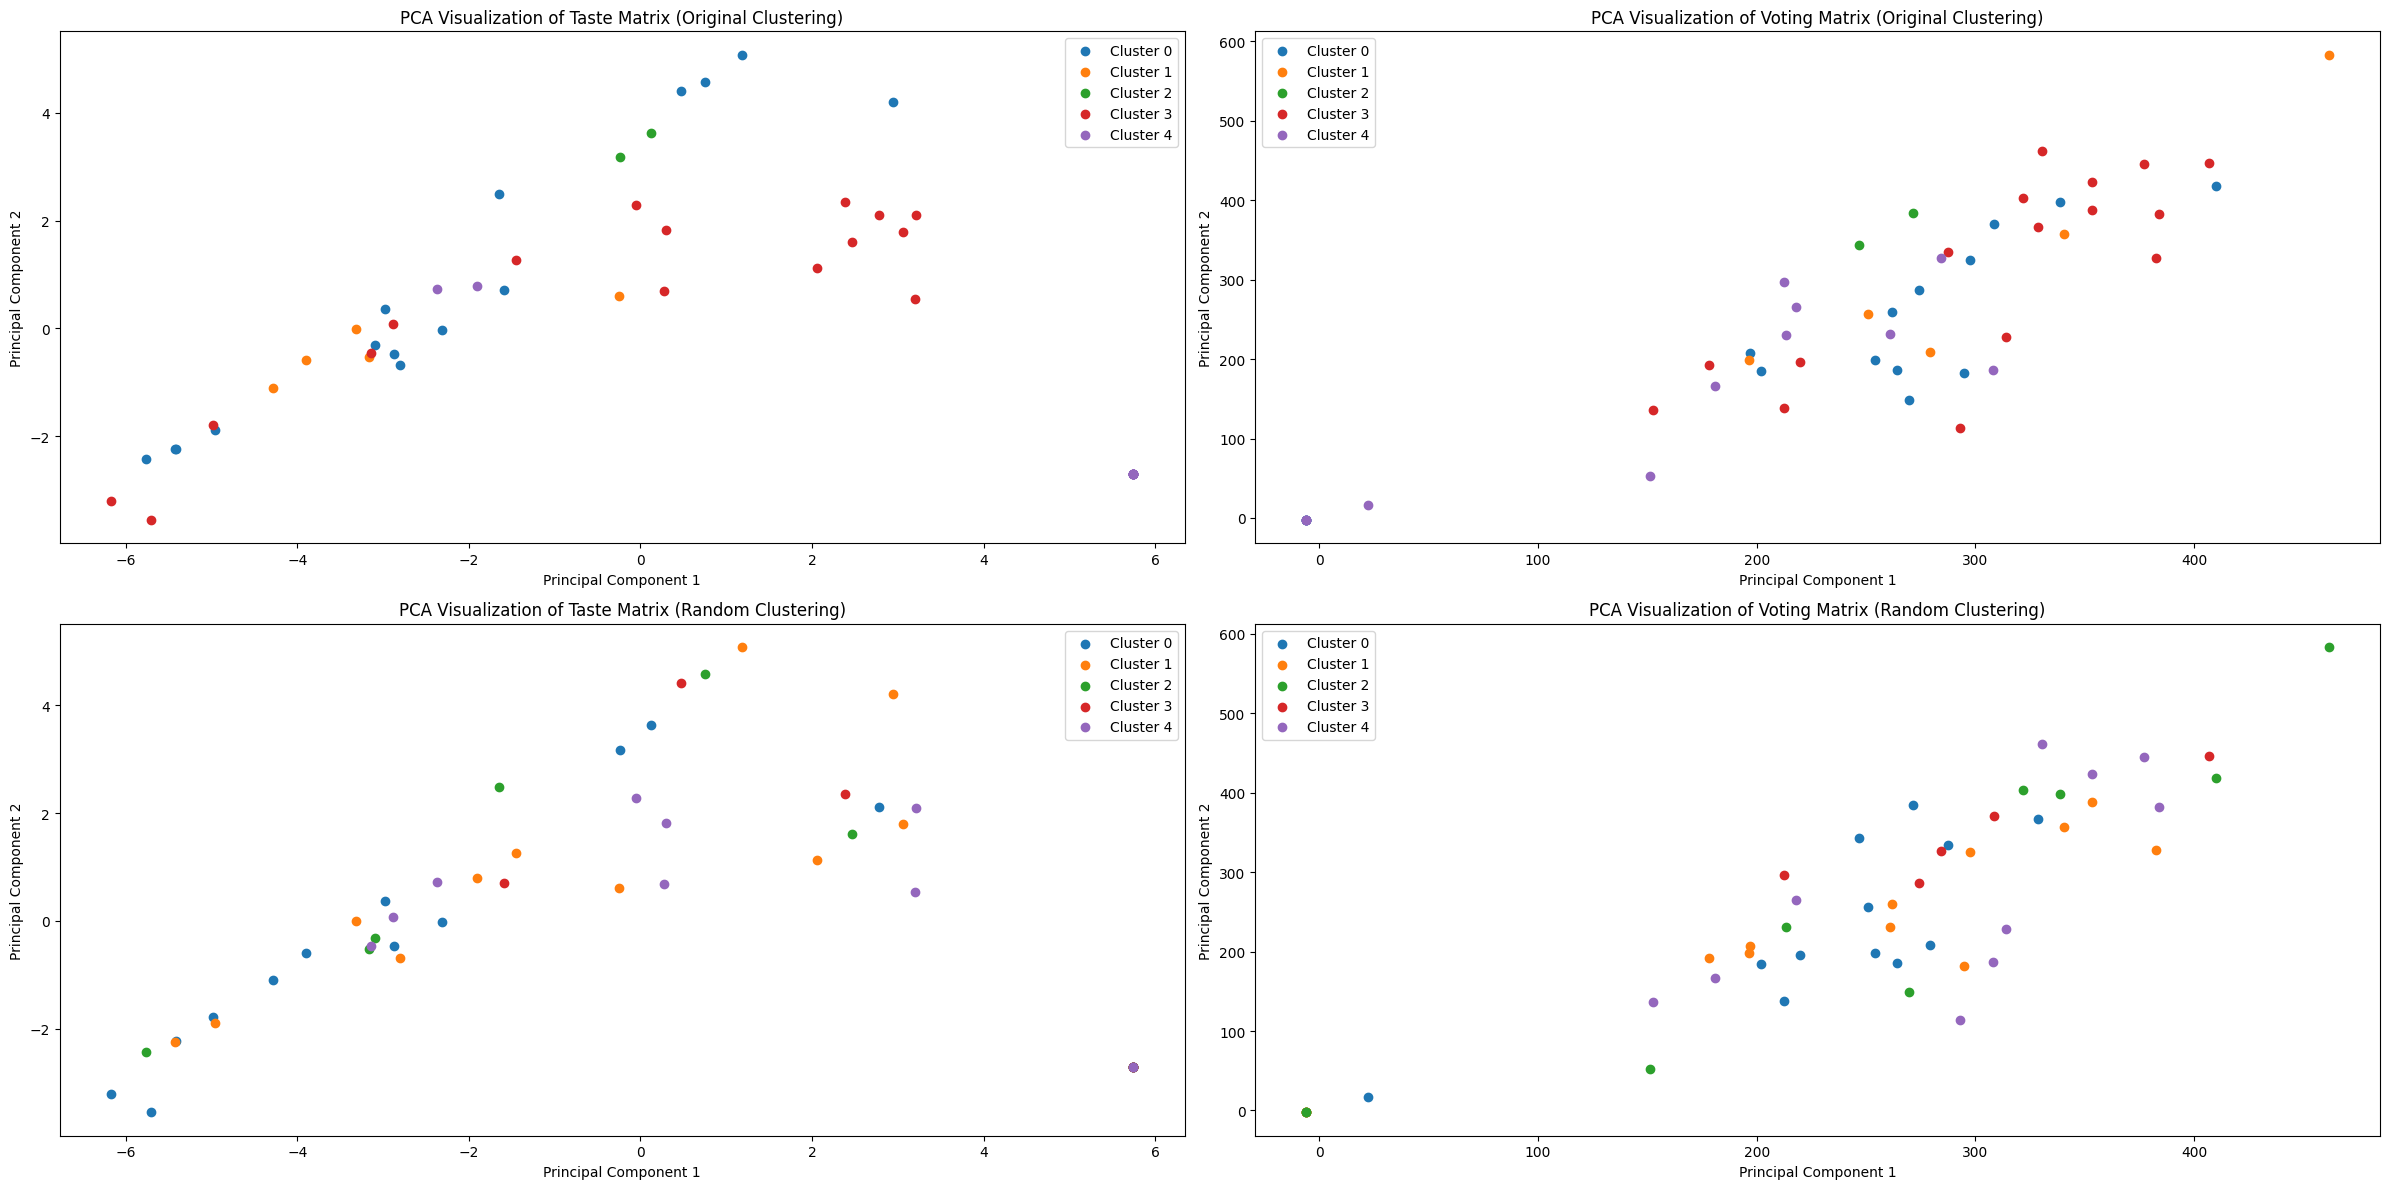

The silhouette score for Taste Matrix (Original) is: 0.15377292333505296
The silhouette score for Voting Matrix (Original) is: -0.0847493720789759
The silhouette score for Taste Matrix (Random) is: -0.10368241723519449
The silhouette score for Voting Matrix (Random) is: -0.061495579448063206


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


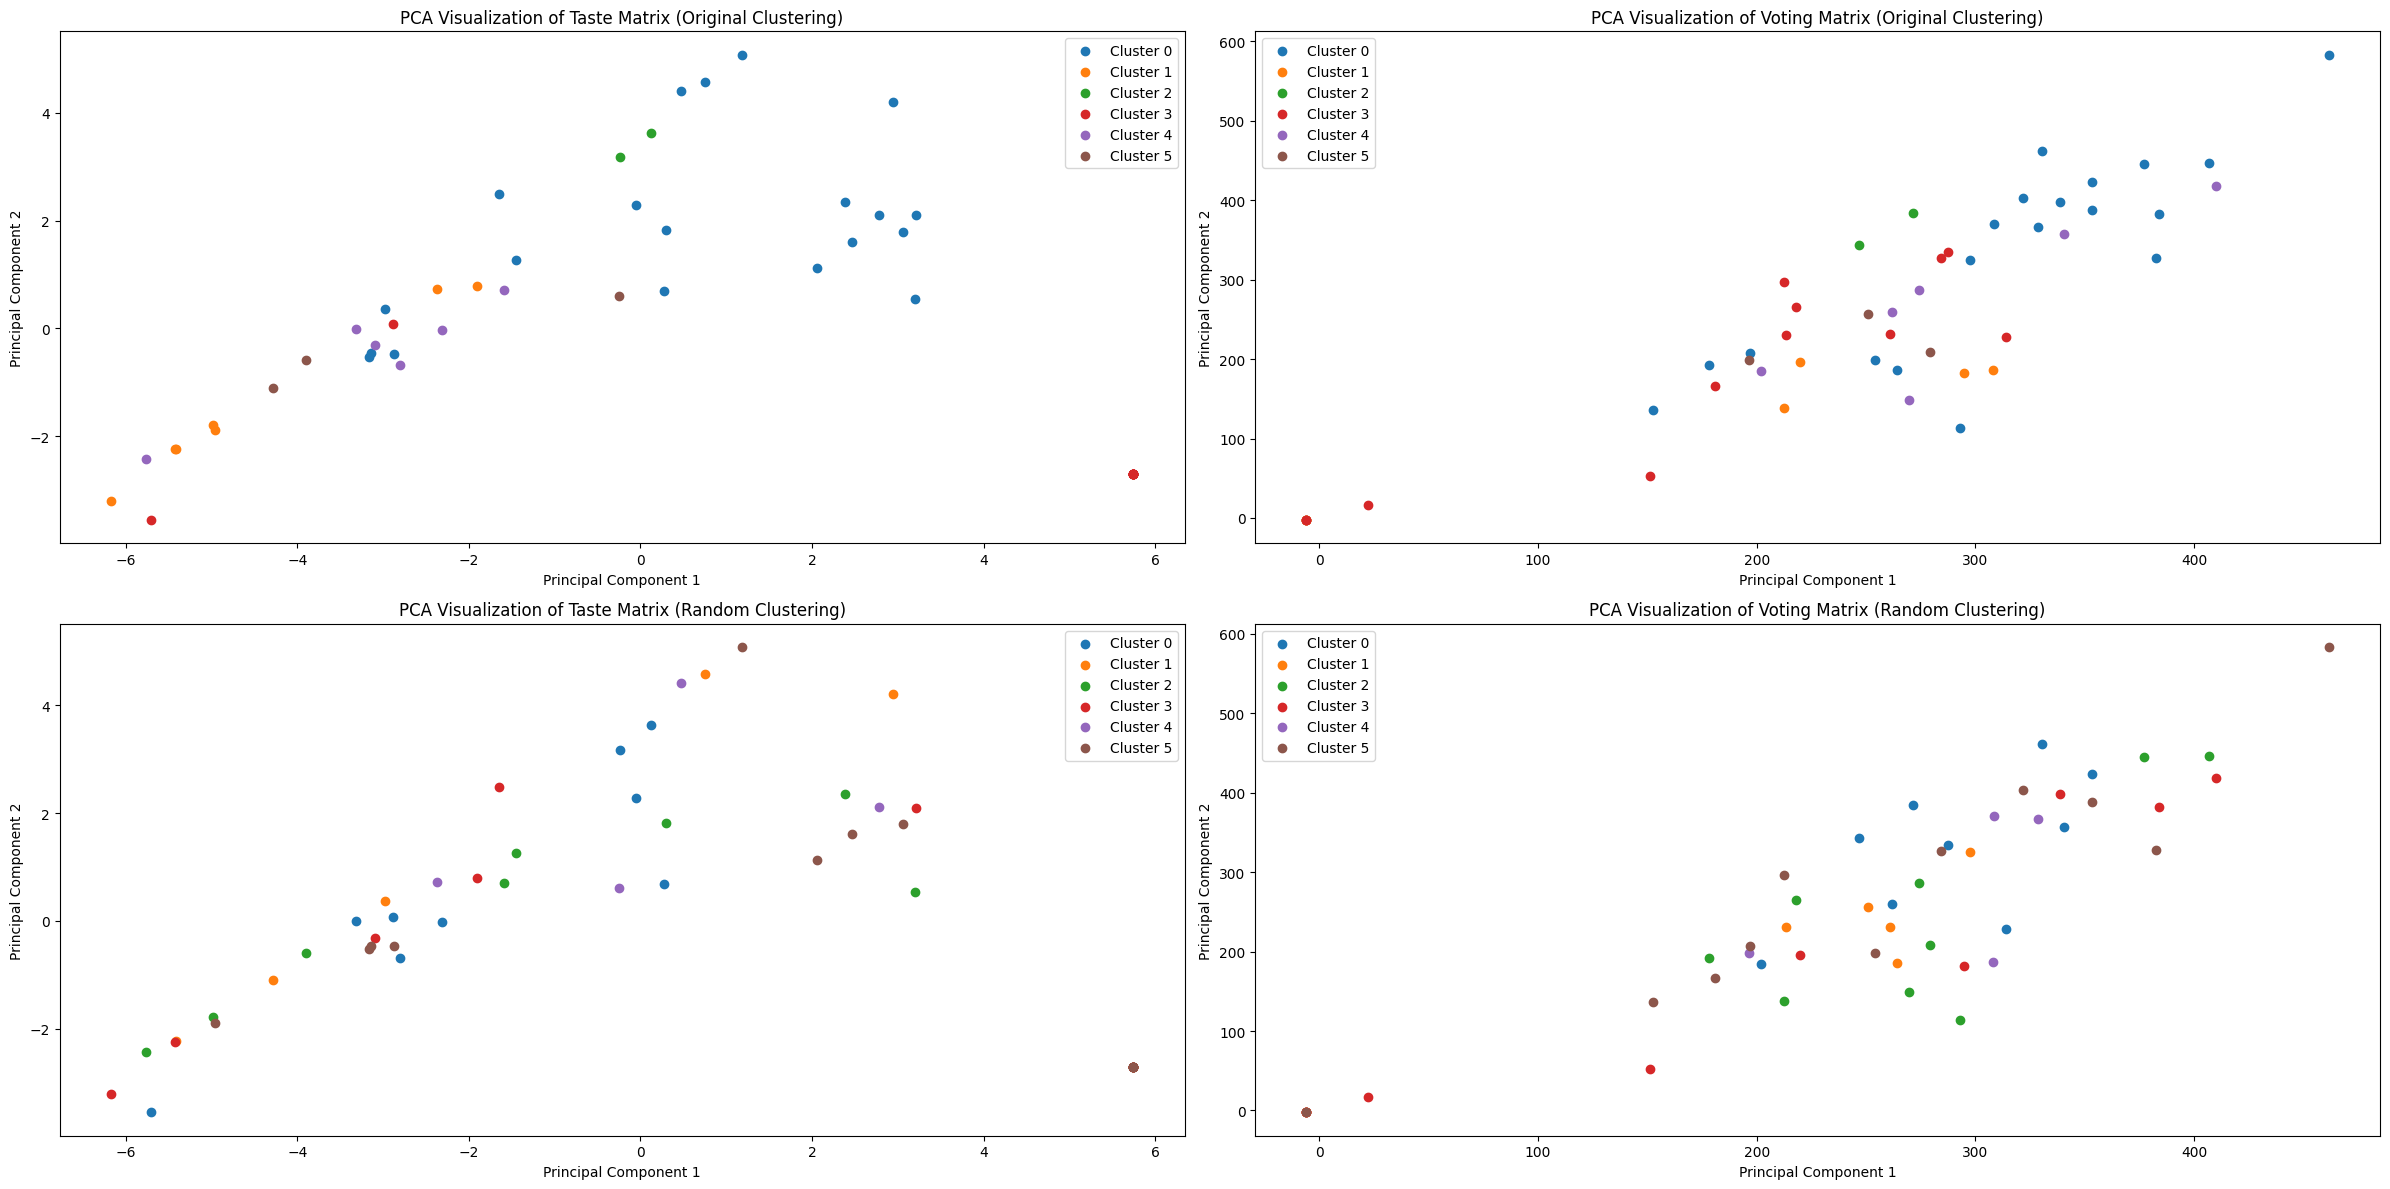

The silhouette score for Taste Matrix (Original) is: 0.19511085690248017
The silhouette score for Voting Matrix (Original) is: -0.09983406968890413
The silhouette score for Taste Matrix (Random) is: -0.09731596564957662
The silhouette score for Voting Matrix (Random) is: -0.0868794882509766


In [6]:
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 3, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 4, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 5, method='KMeans')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 6, method='KMeans')

clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(artists_similarity_matrix, votes_matrix_tele, 6, method='SpectralClustering')

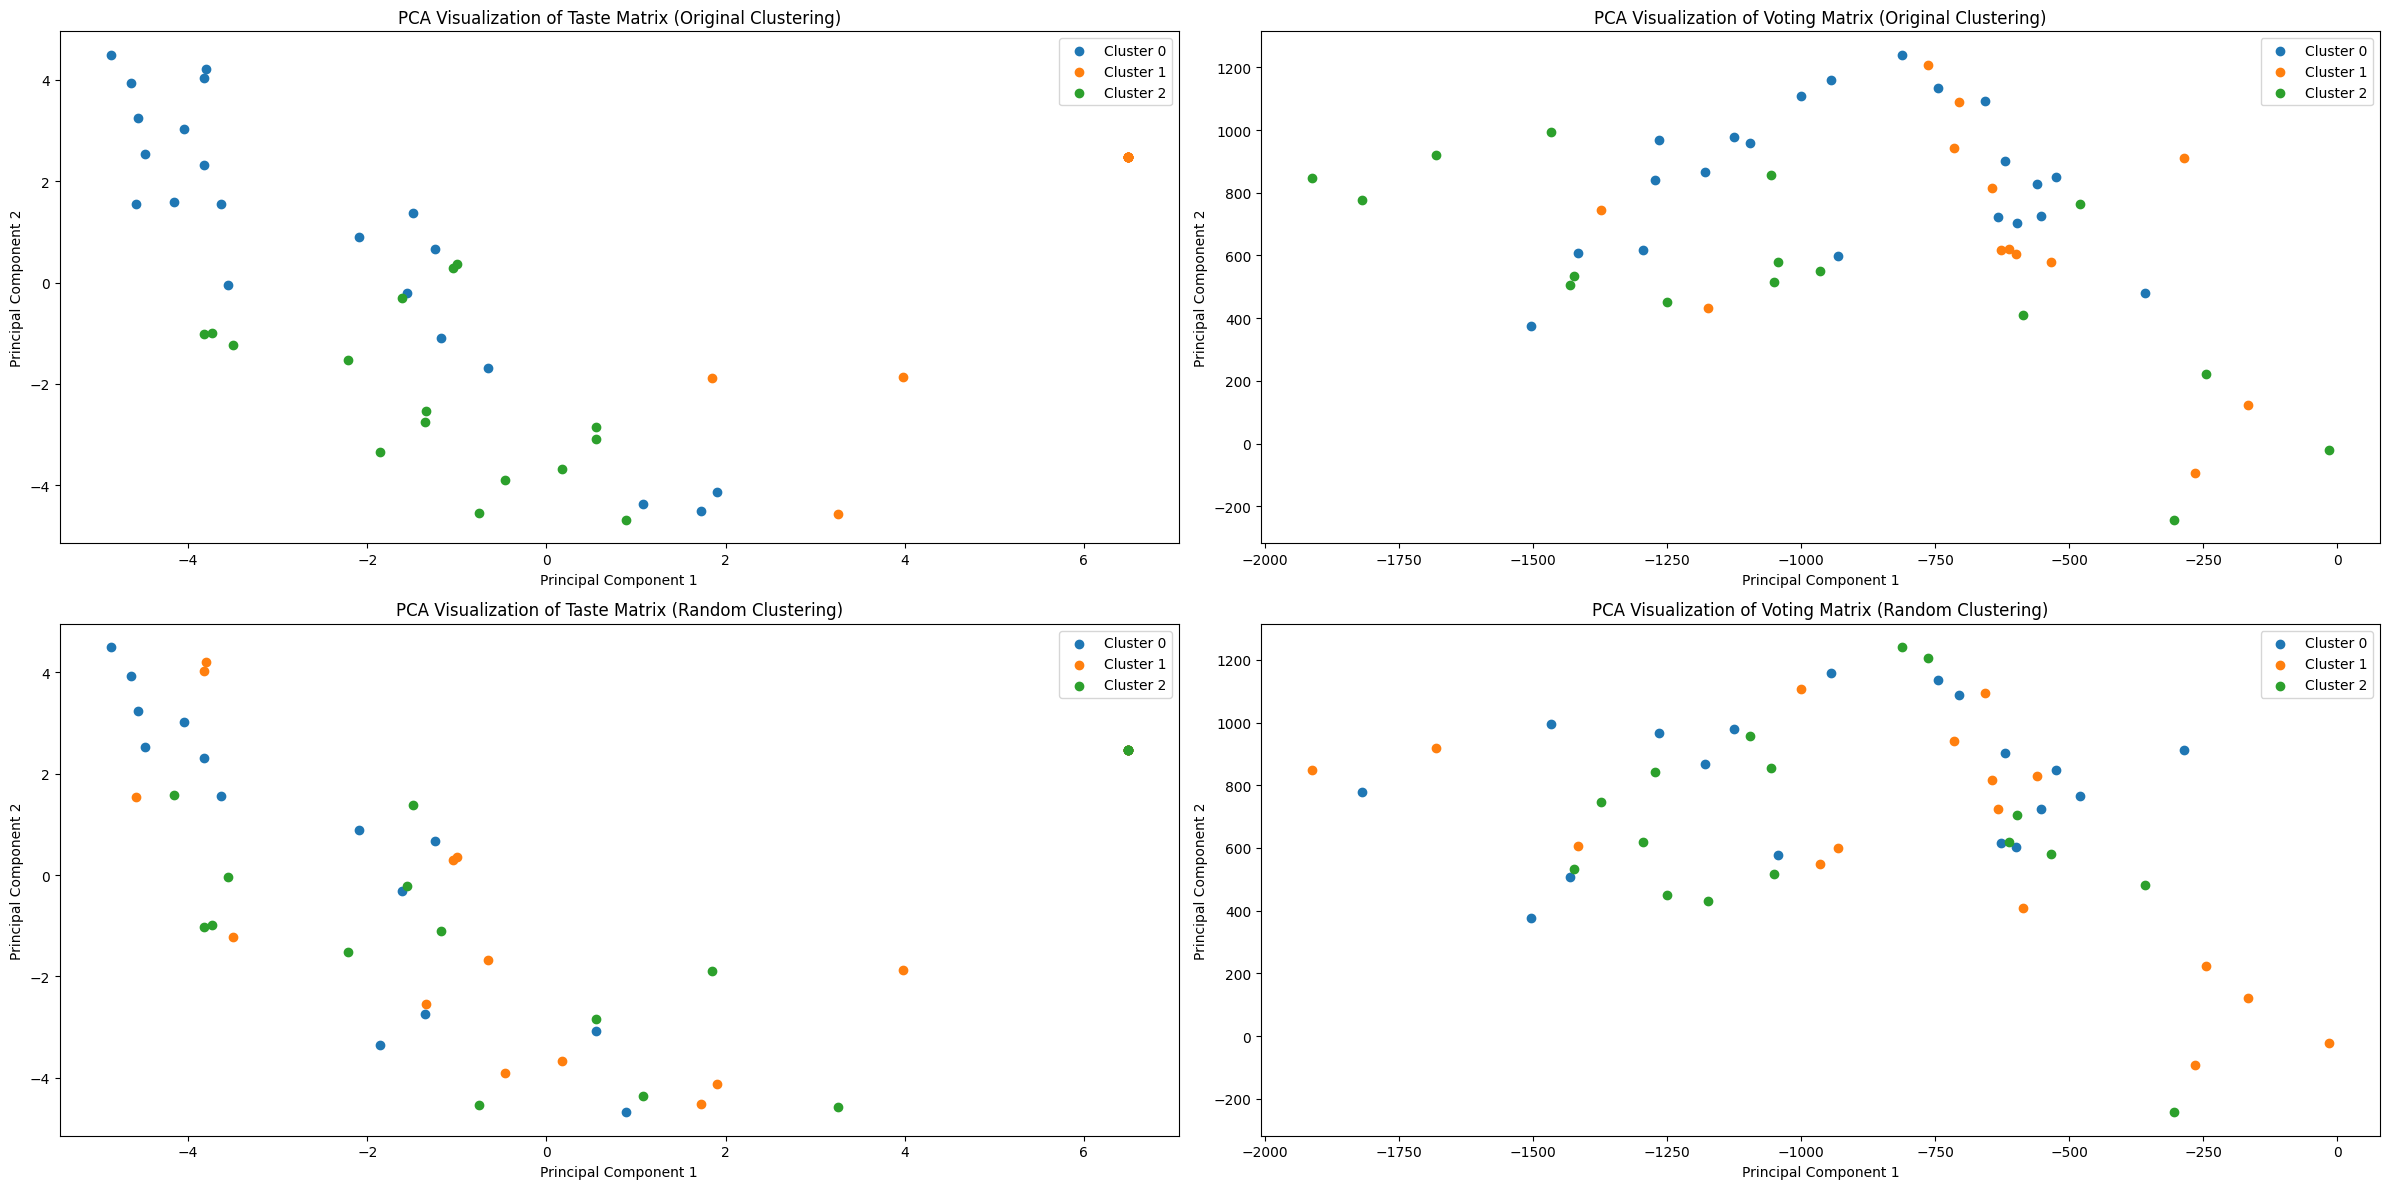

The silhouette score for Taste Matrix (Original) is: 0.27343912346199784
The silhouette score for Voting Matrix (Original) is: -0.01547402498638839
The silhouette score for Taste Matrix (Random) is: -0.02820919820426445
The silhouette score for Voting Matrix (Random) is: -0.019964831150763827


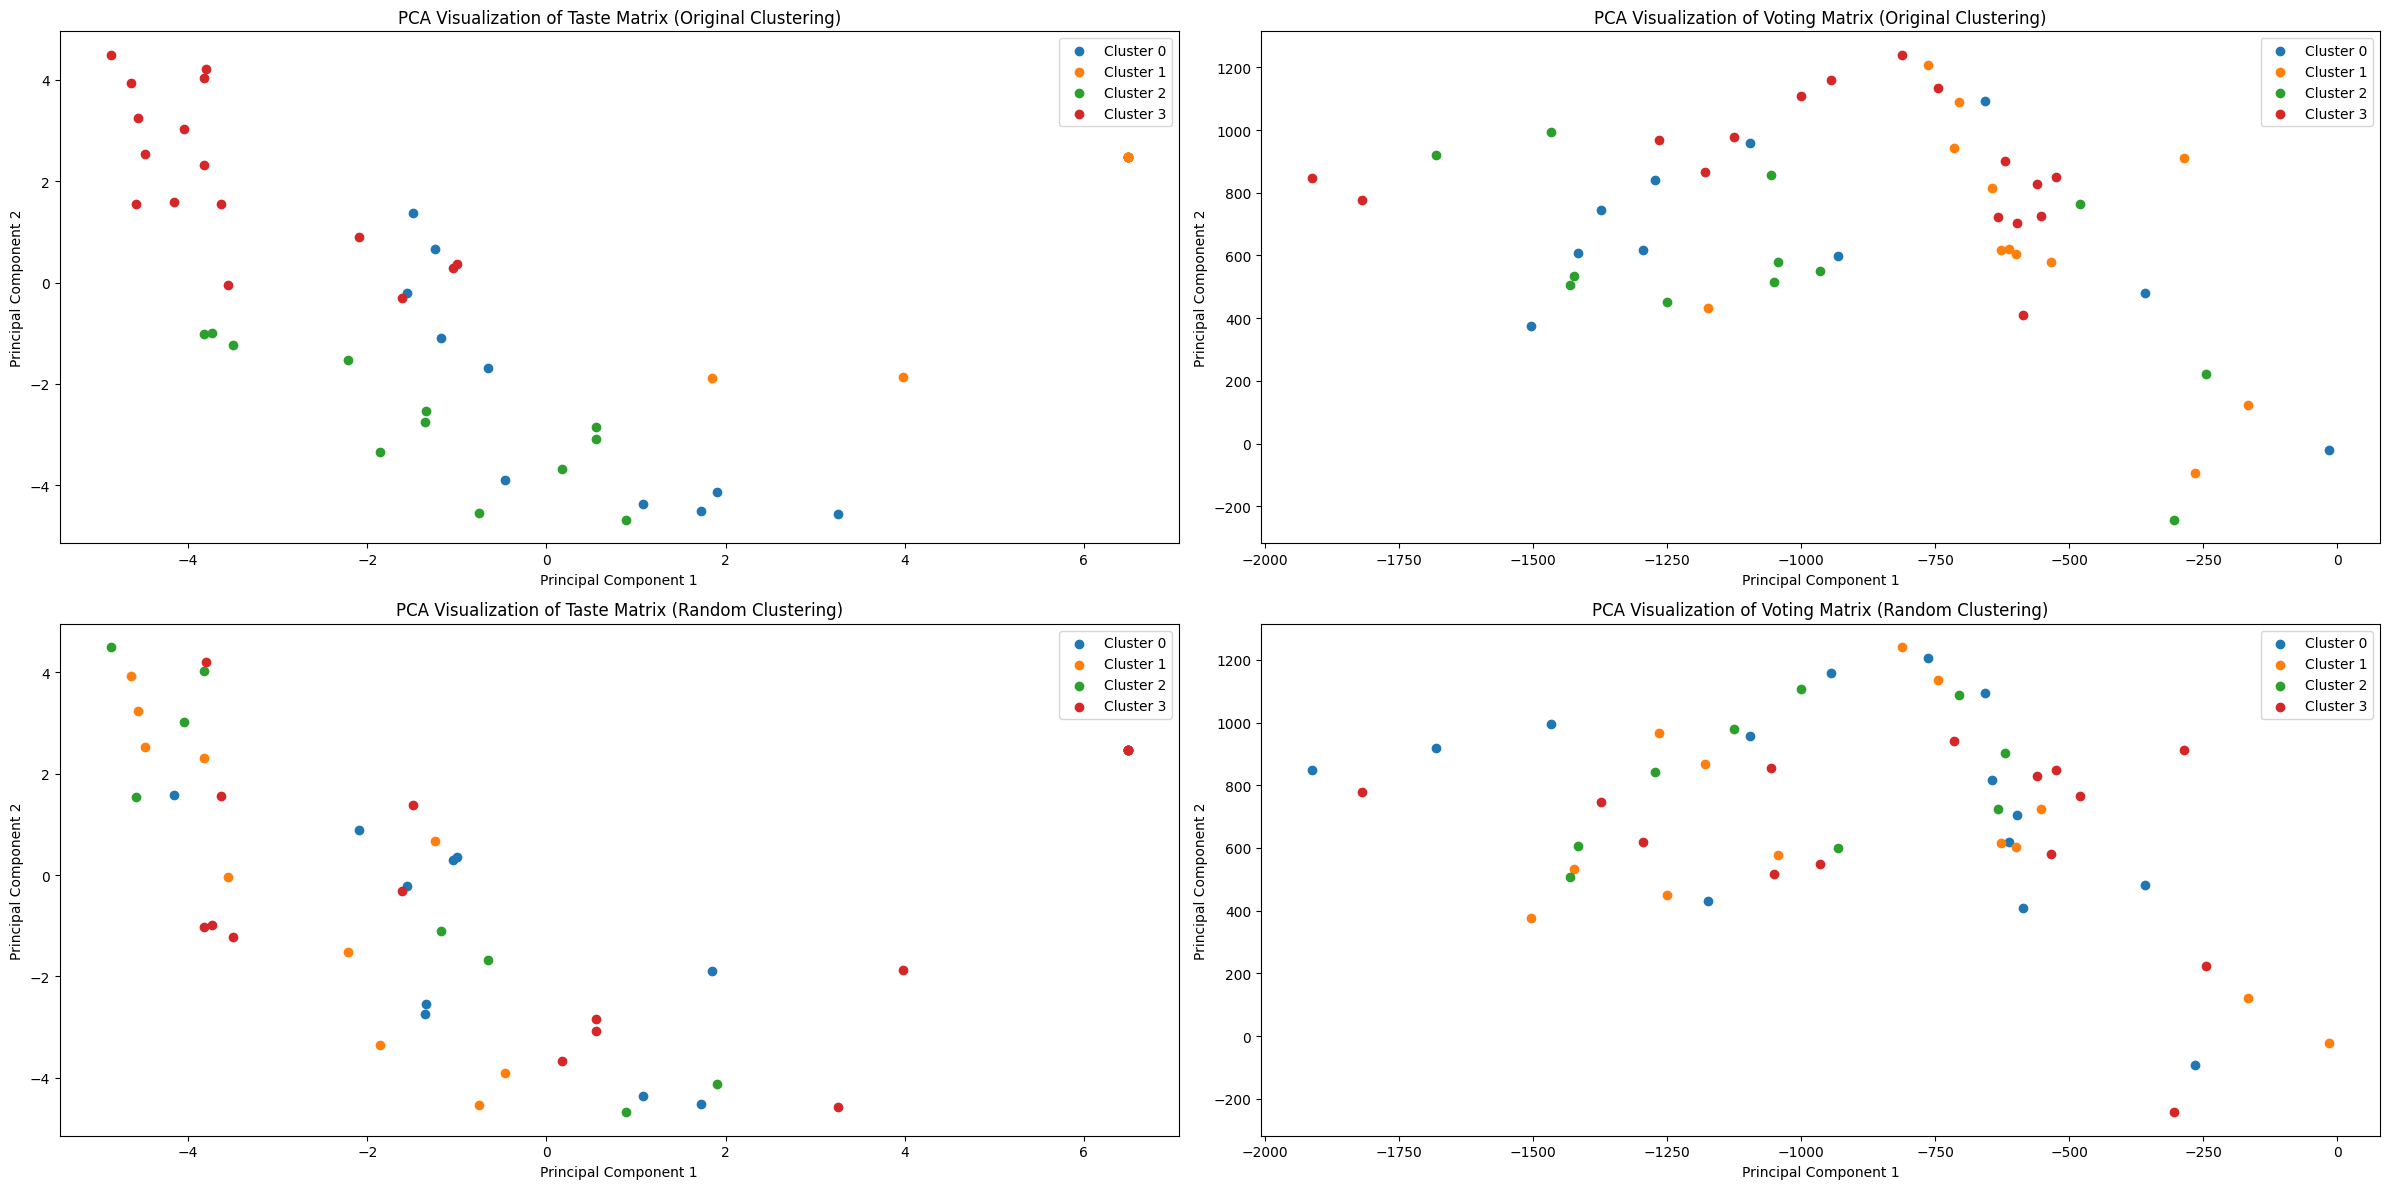

The silhouette score for Taste Matrix (Original) is: 0.3203752068939478
The silhouette score for Voting Matrix (Original) is: -0.04413184626820688
The silhouette score for Taste Matrix (Random) is: -0.05958197174856457
The silhouette score for Voting Matrix (Random) is: -0.05575408219084275


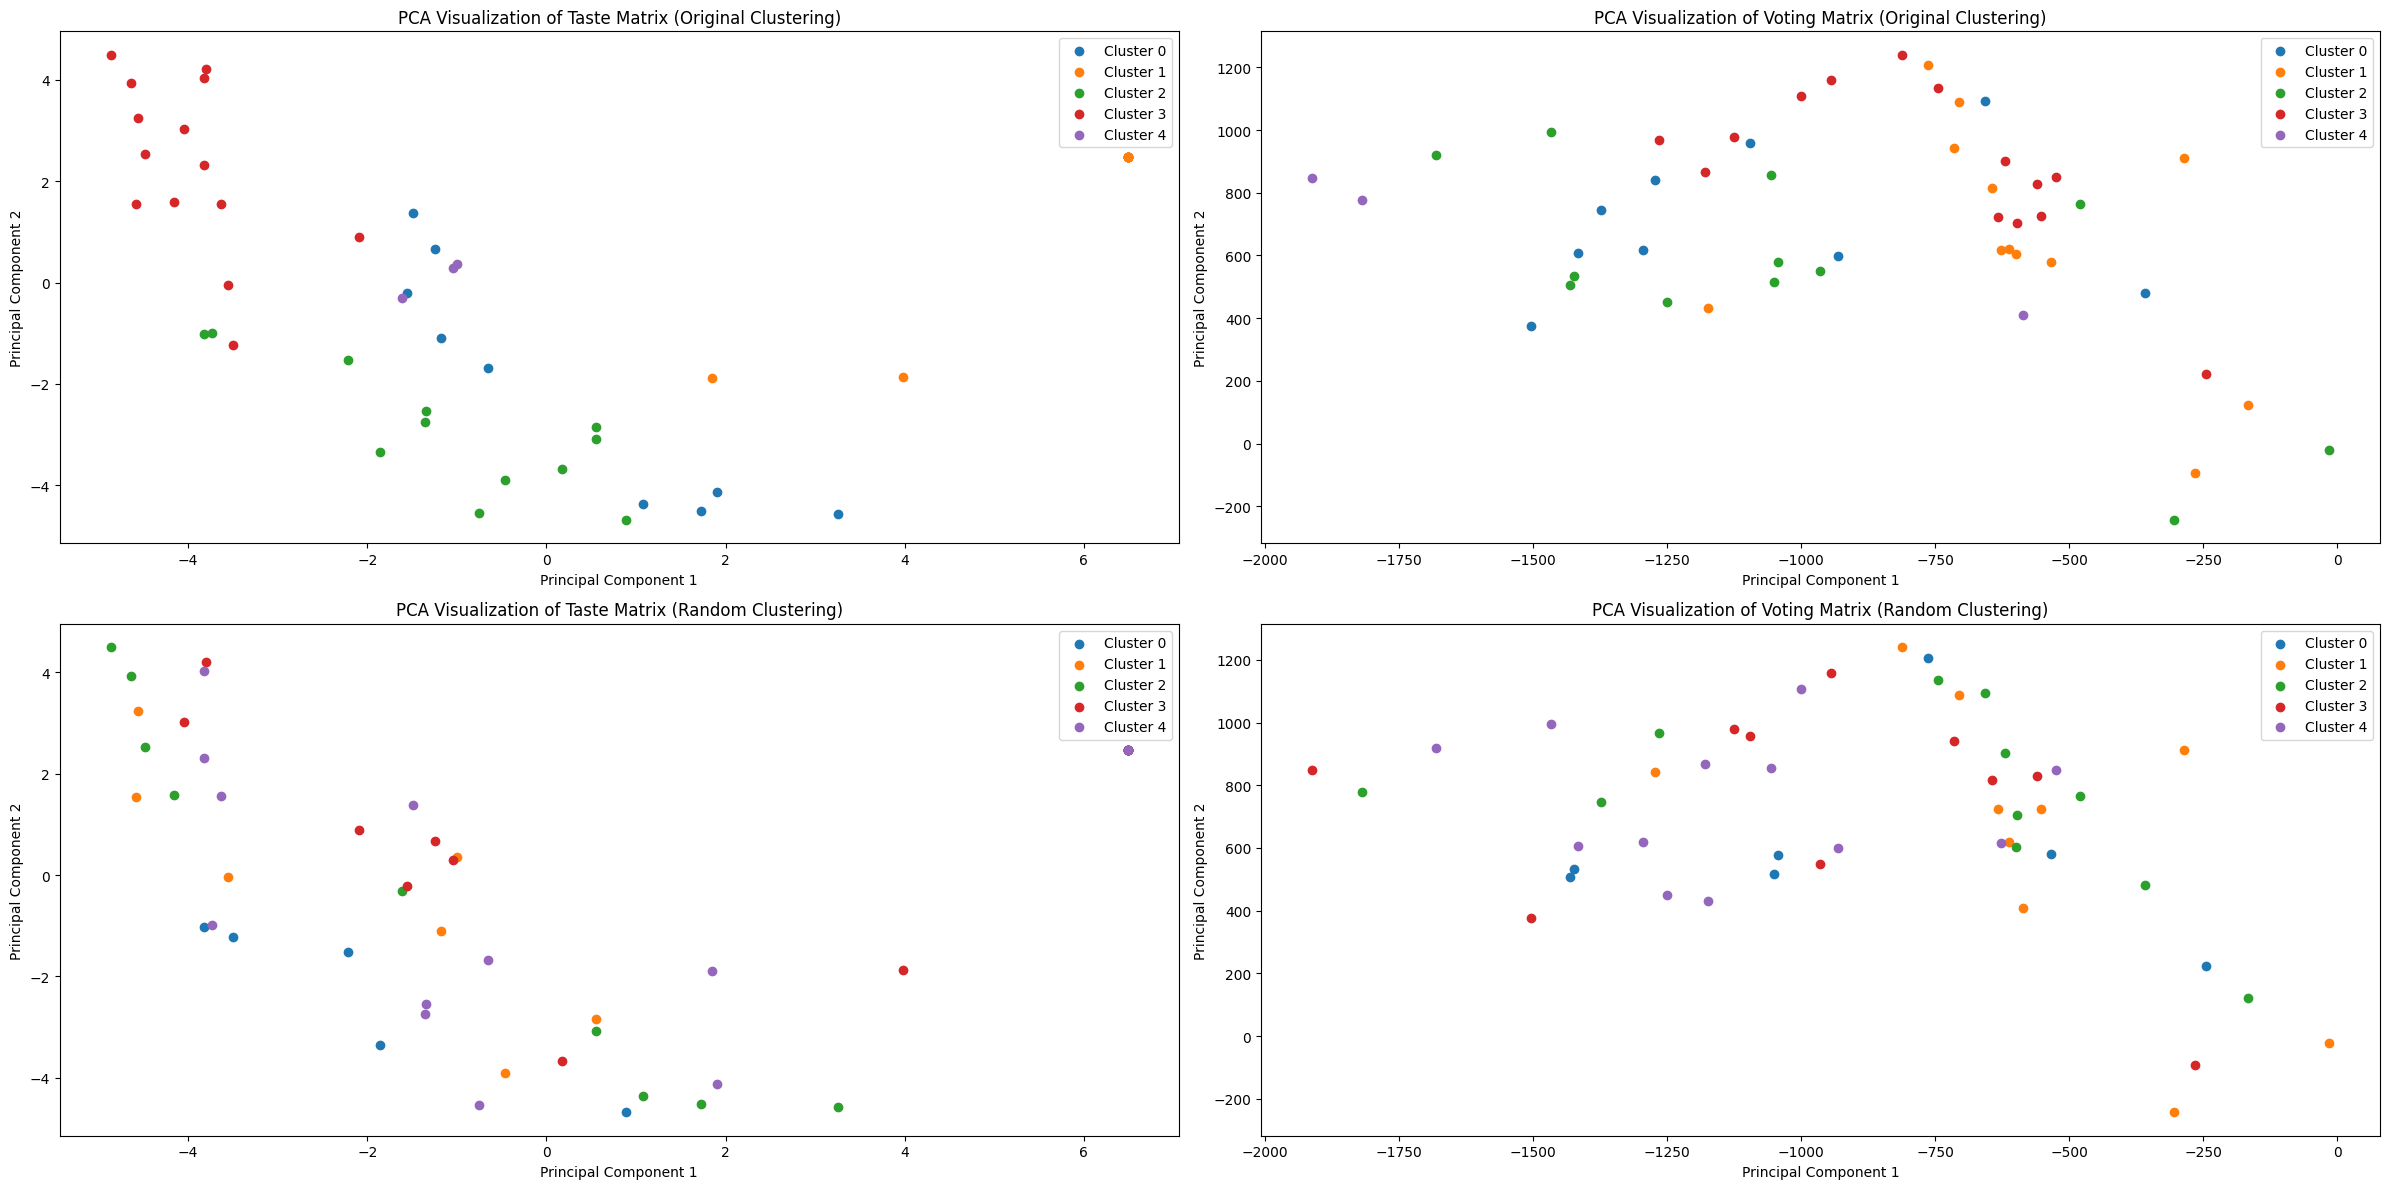

The silhouette score for Taste Matrix (Original) is: 0.3399109489774598
The silhouette score for Voting Matrix (Original) is: -0.06359787298613372
The silhouette score for Taste Matrix (Random) is: -0.07871080414196684
The silhouette score for Voting Matrix (Random) is: -0.07910261680974412


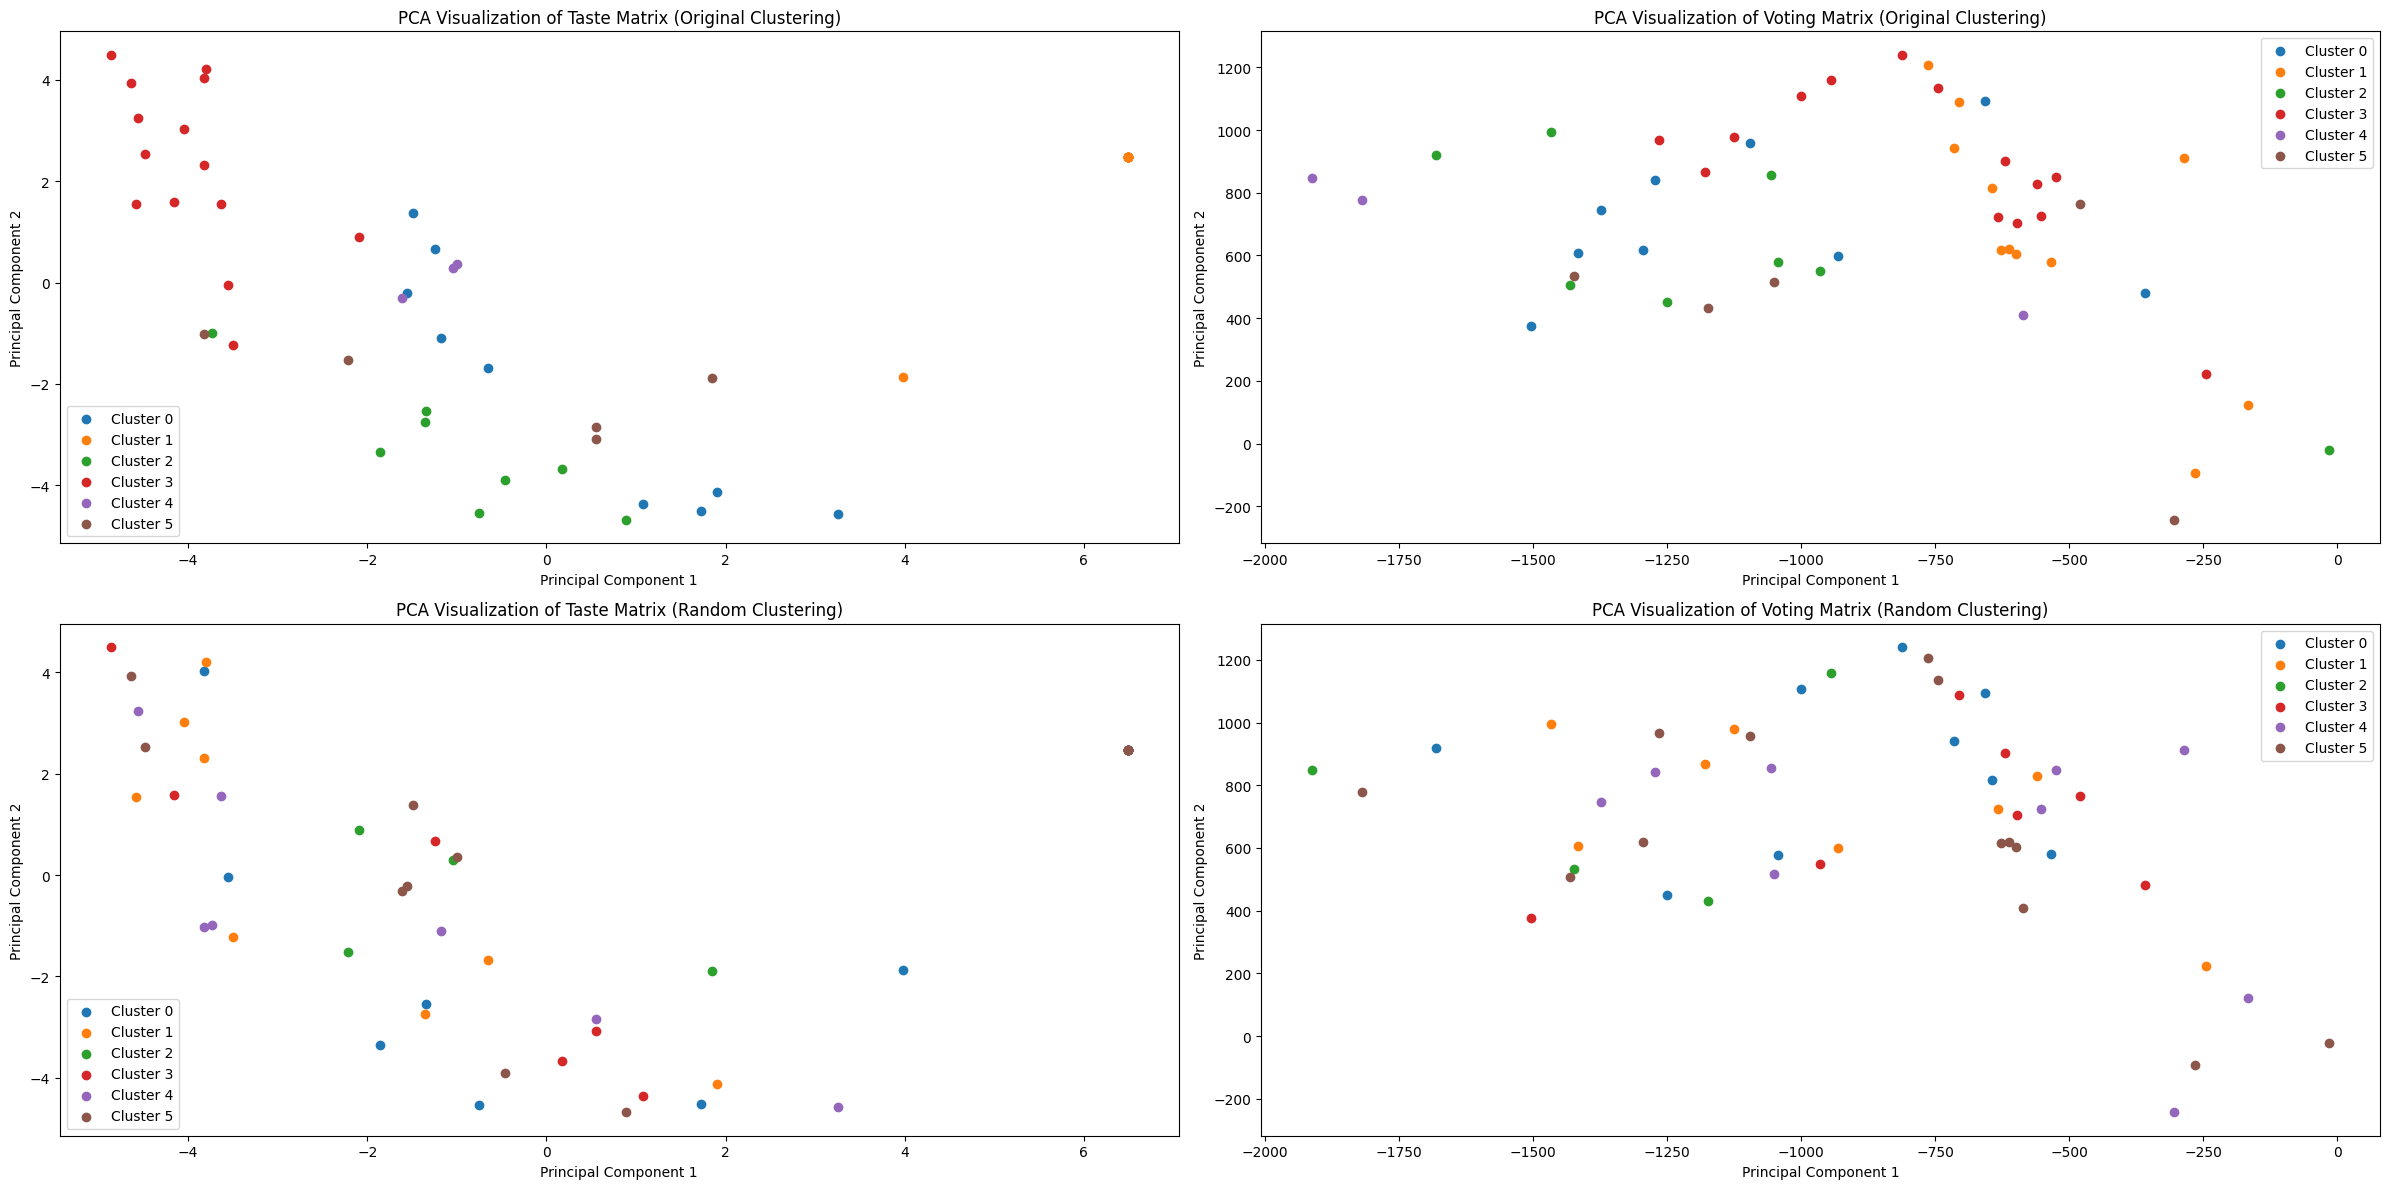

The silhouette score for Taste Matrix (Original) is: 0.3177506662858891
The silhouette score for Voting Matrix (Original) is: -0.07141513847264015
The silhouette score for Taste Matrix (Random) is: -0.09642342947525079
The silhouette score for Voting Matrix (Random) is: -0.09817895349412681


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.53575940e-13 1.17410682e-07 4.42877625e-08 2.50311259e-05]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 1714 instead with accuracy 
2.1051704250273214e-06.

  _, diffusion_map = lobpcg(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.53386652e-14 1.17510520e-07 4.27554460e-08 8.26041549e-06]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


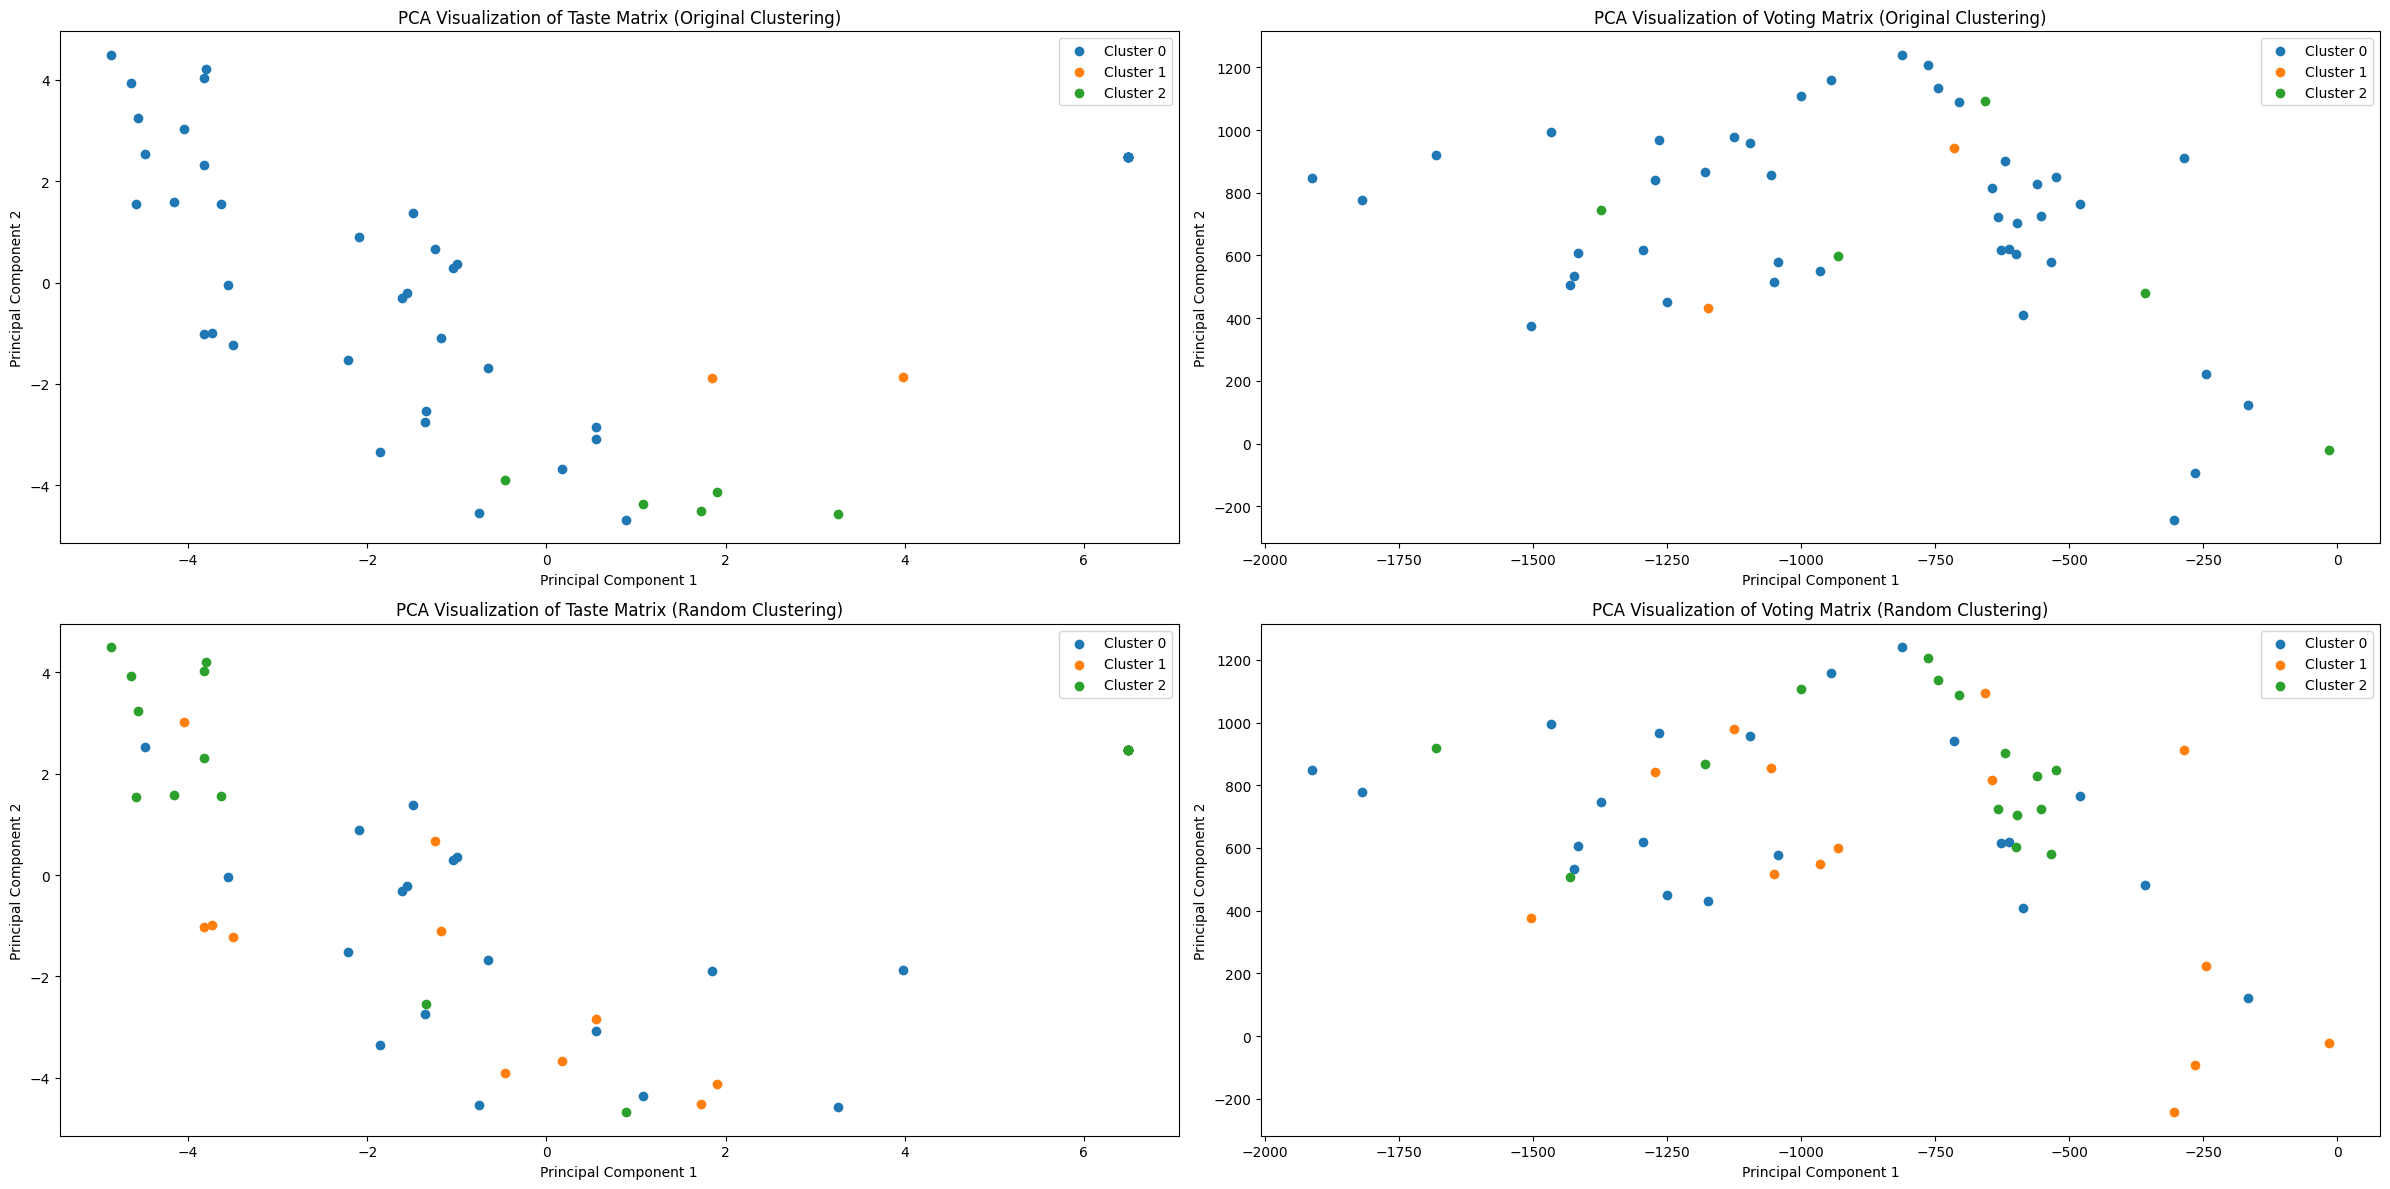

The silhouette score for Taste Matrix (Original) is: 0.09894566771759679
The silhouette score for Voting Matrix (Original) is: -0.06603391701314541
The silhouette score for Taste Matrix (Random) is: -0.010592833696710406
The silhouette score for Voting Matrix (Random) is: -0.028636875967909495


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


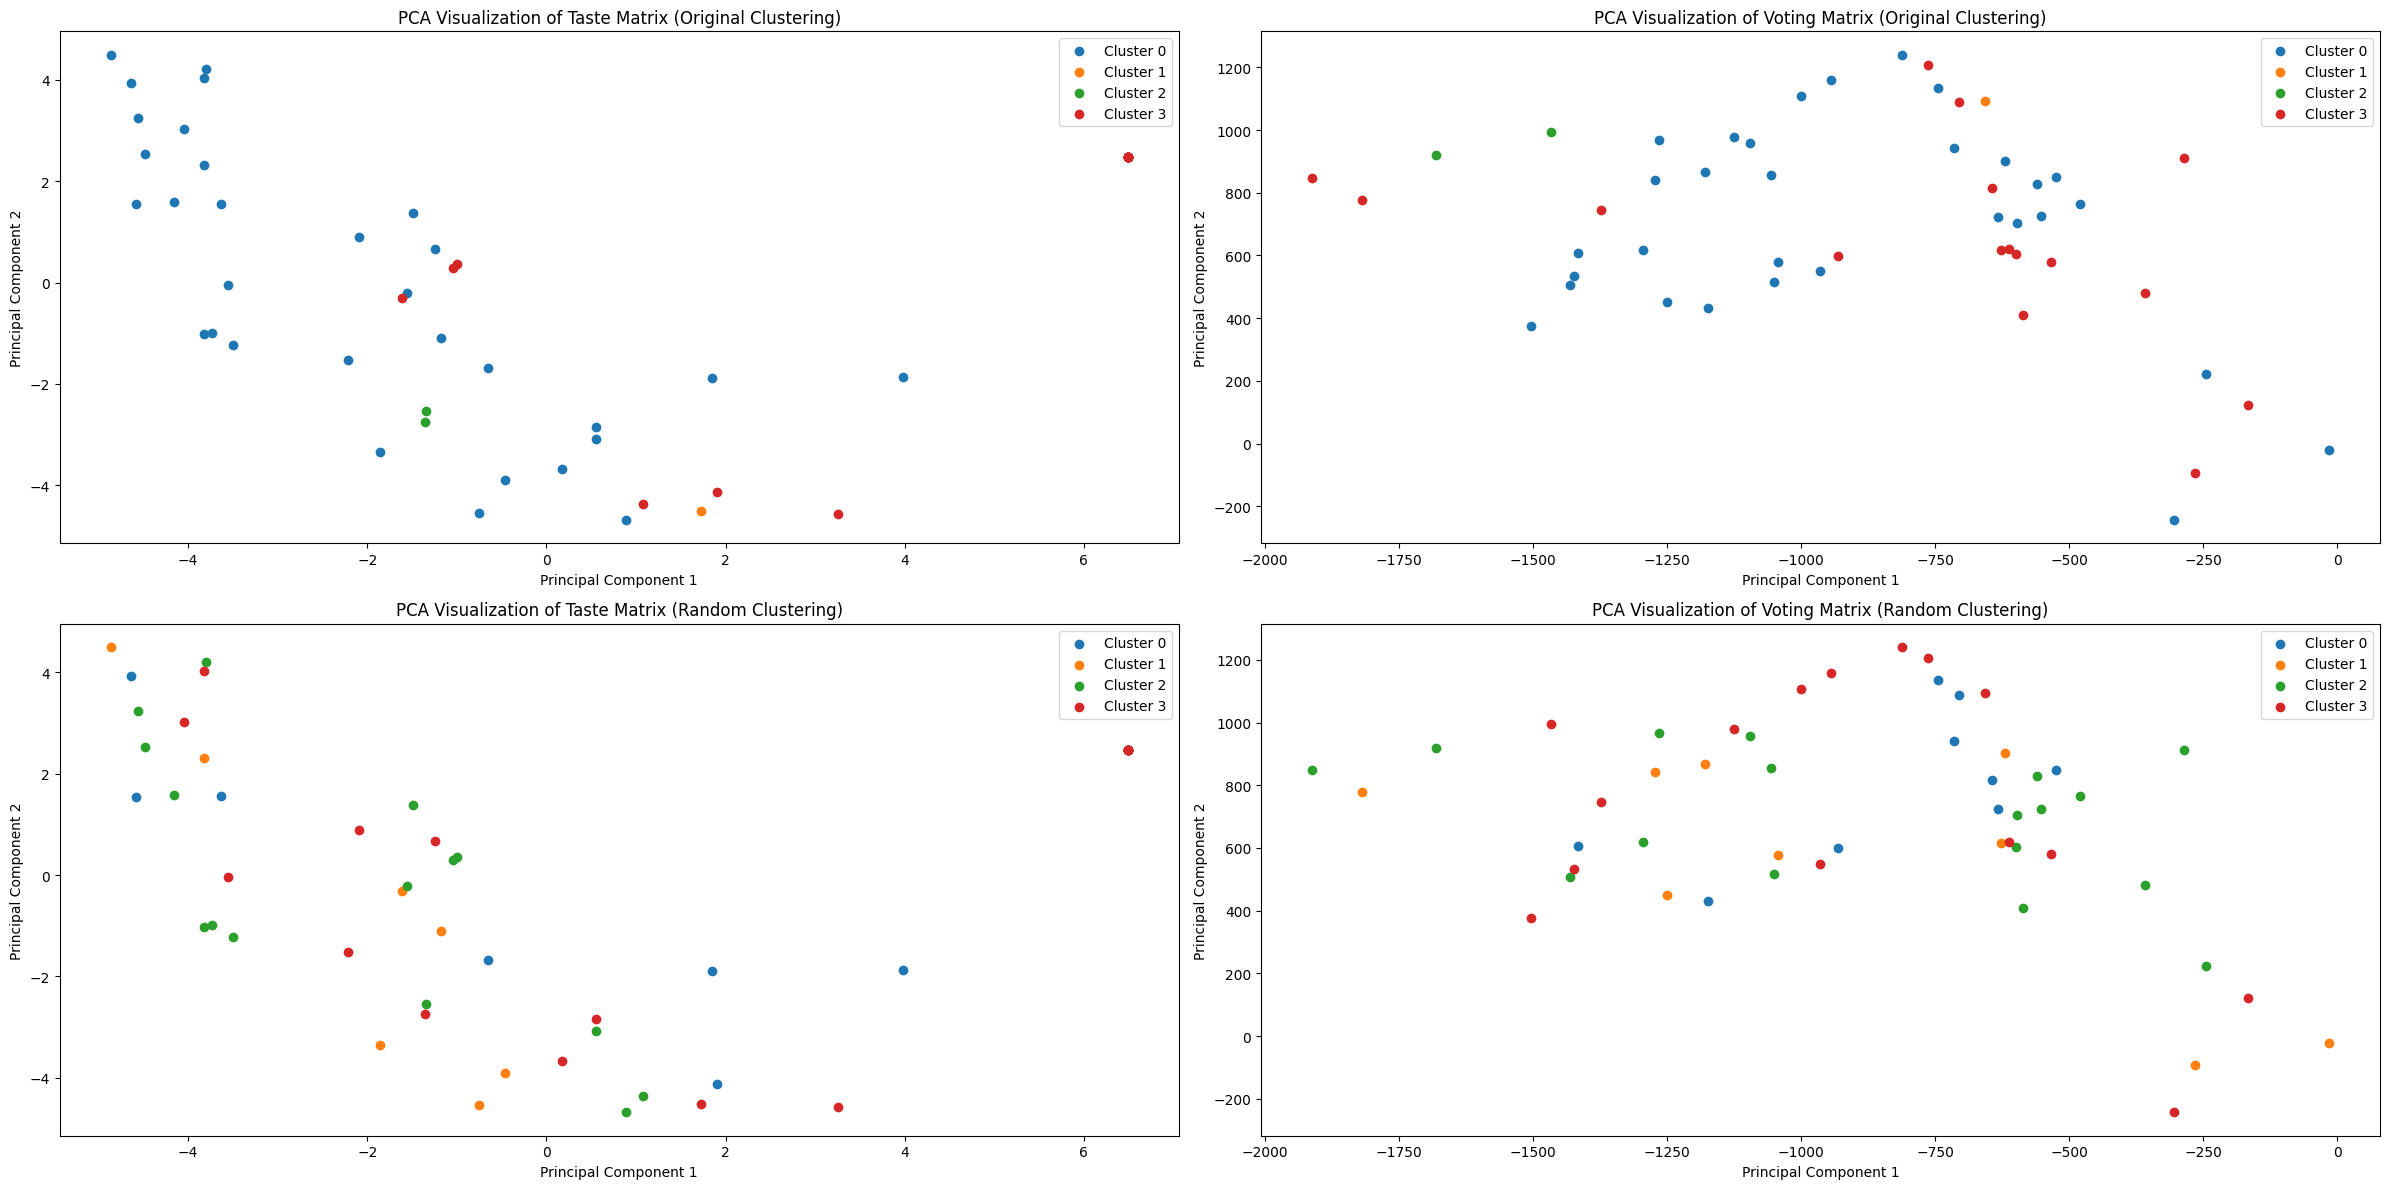

The silhouette score for Taste Matrix (Original) is: 0.16070419254348547
The silhouette score for Voting Matrix (Original) is: -0.17748496093105653
The silhouette score for Taste Matrix (Random) is: -0.058748836211135004
The silhouette score for Voting Matrix (Random) is: -0.07085617308646558


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


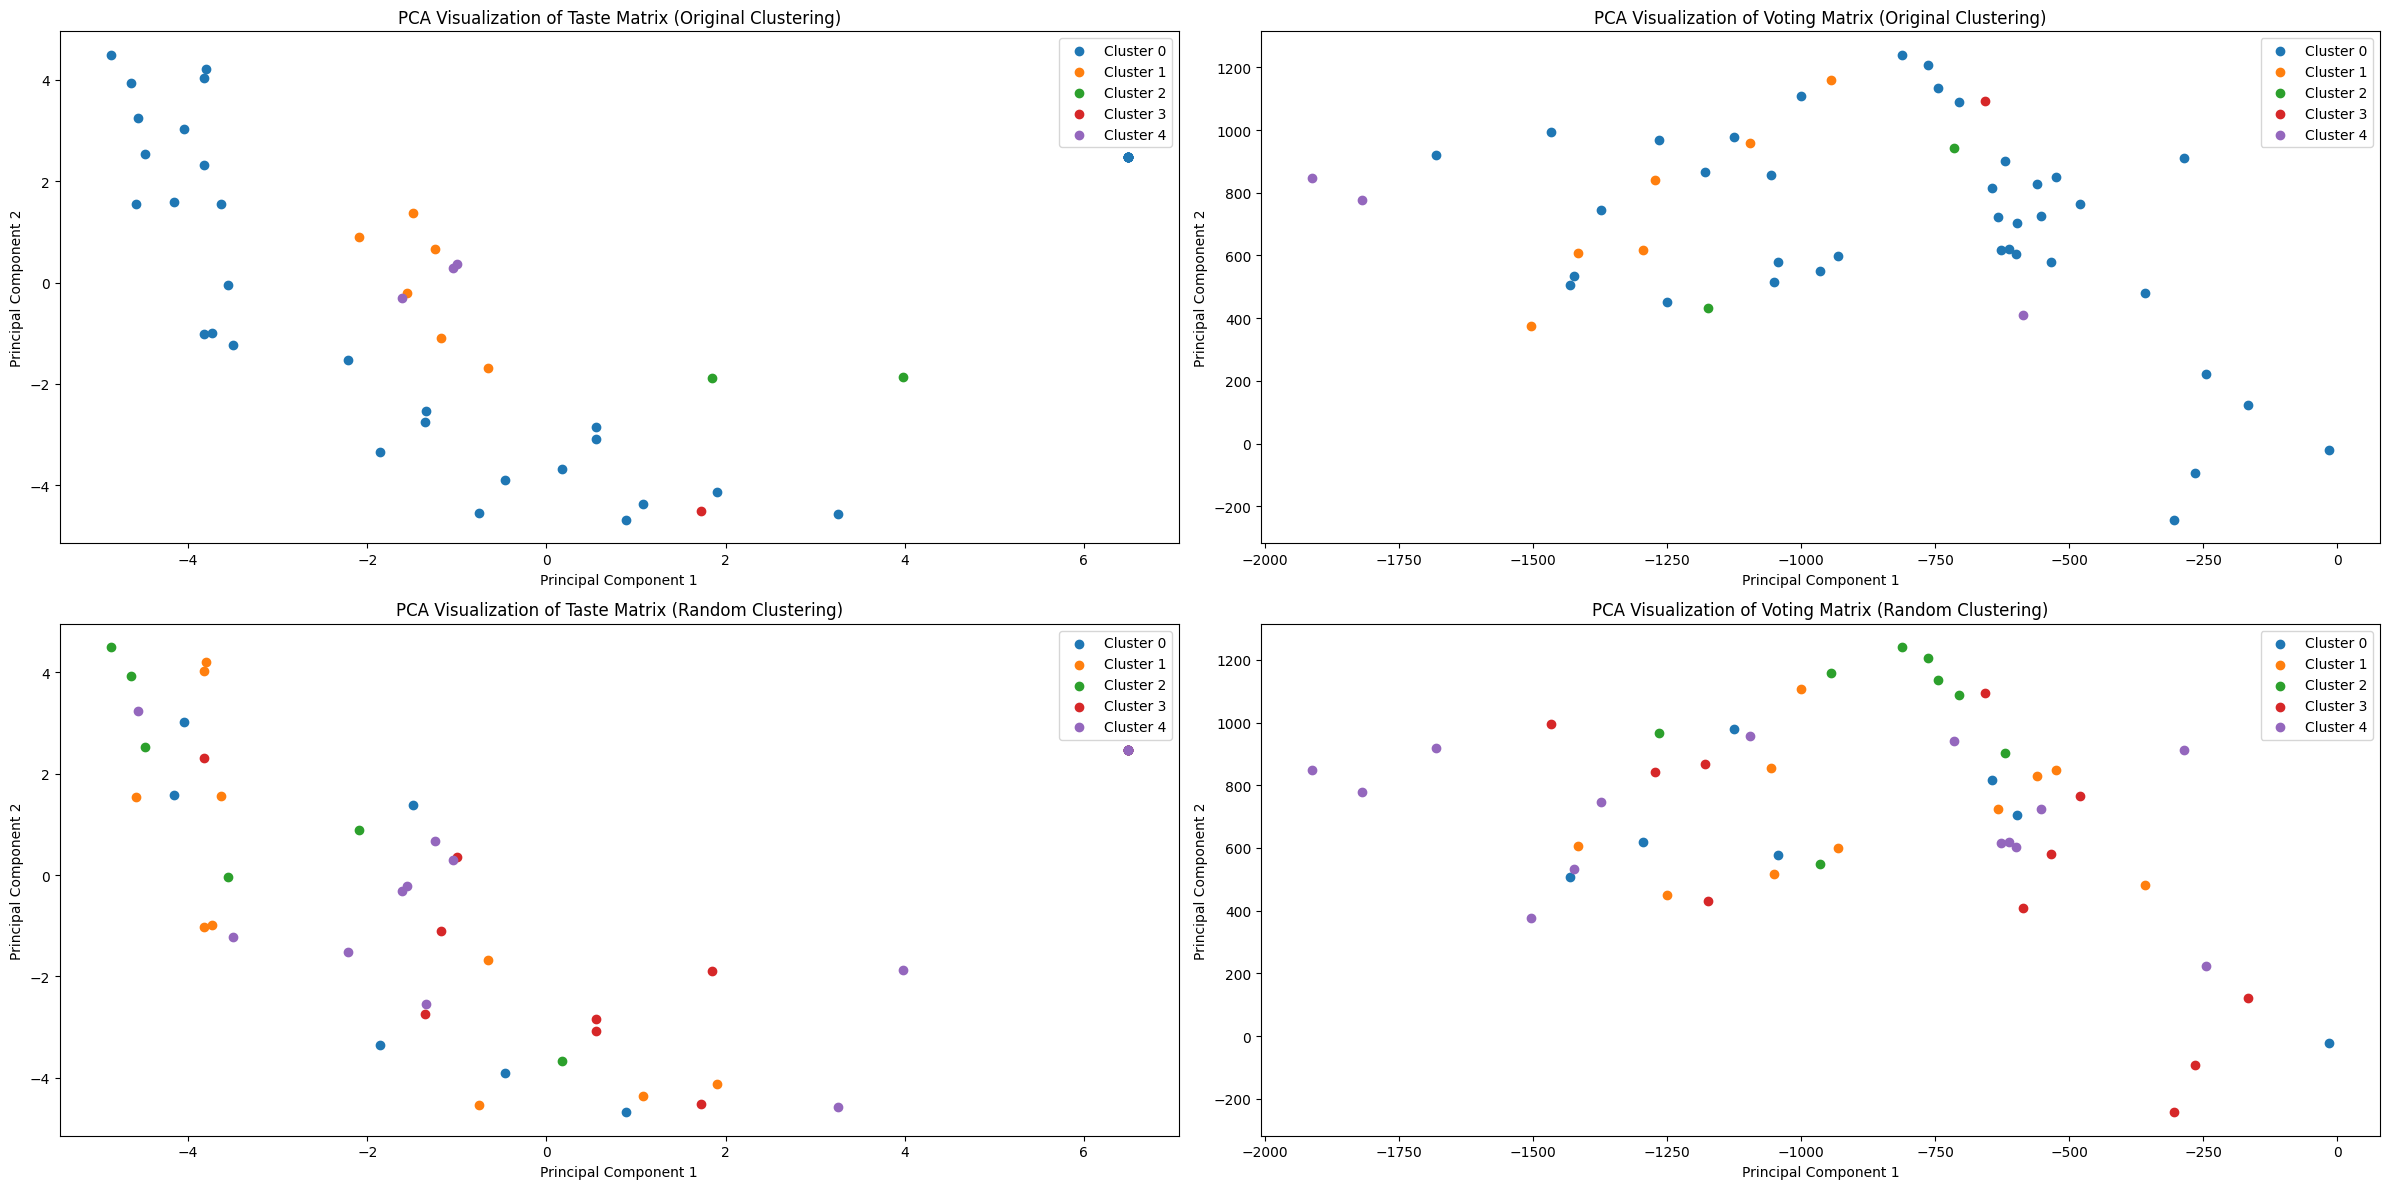

The silhouette score for Taste Matrix (Original) is: 0.05402981734882715
The silhouette score for Voting Matrix (Original) is: -0.2091916033269911
The silhouette score for Taste Matrix (Random) is: -0.07699097647668143
The silhouette score for Voting Matrix (Random) is: -0.06700248368959355


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


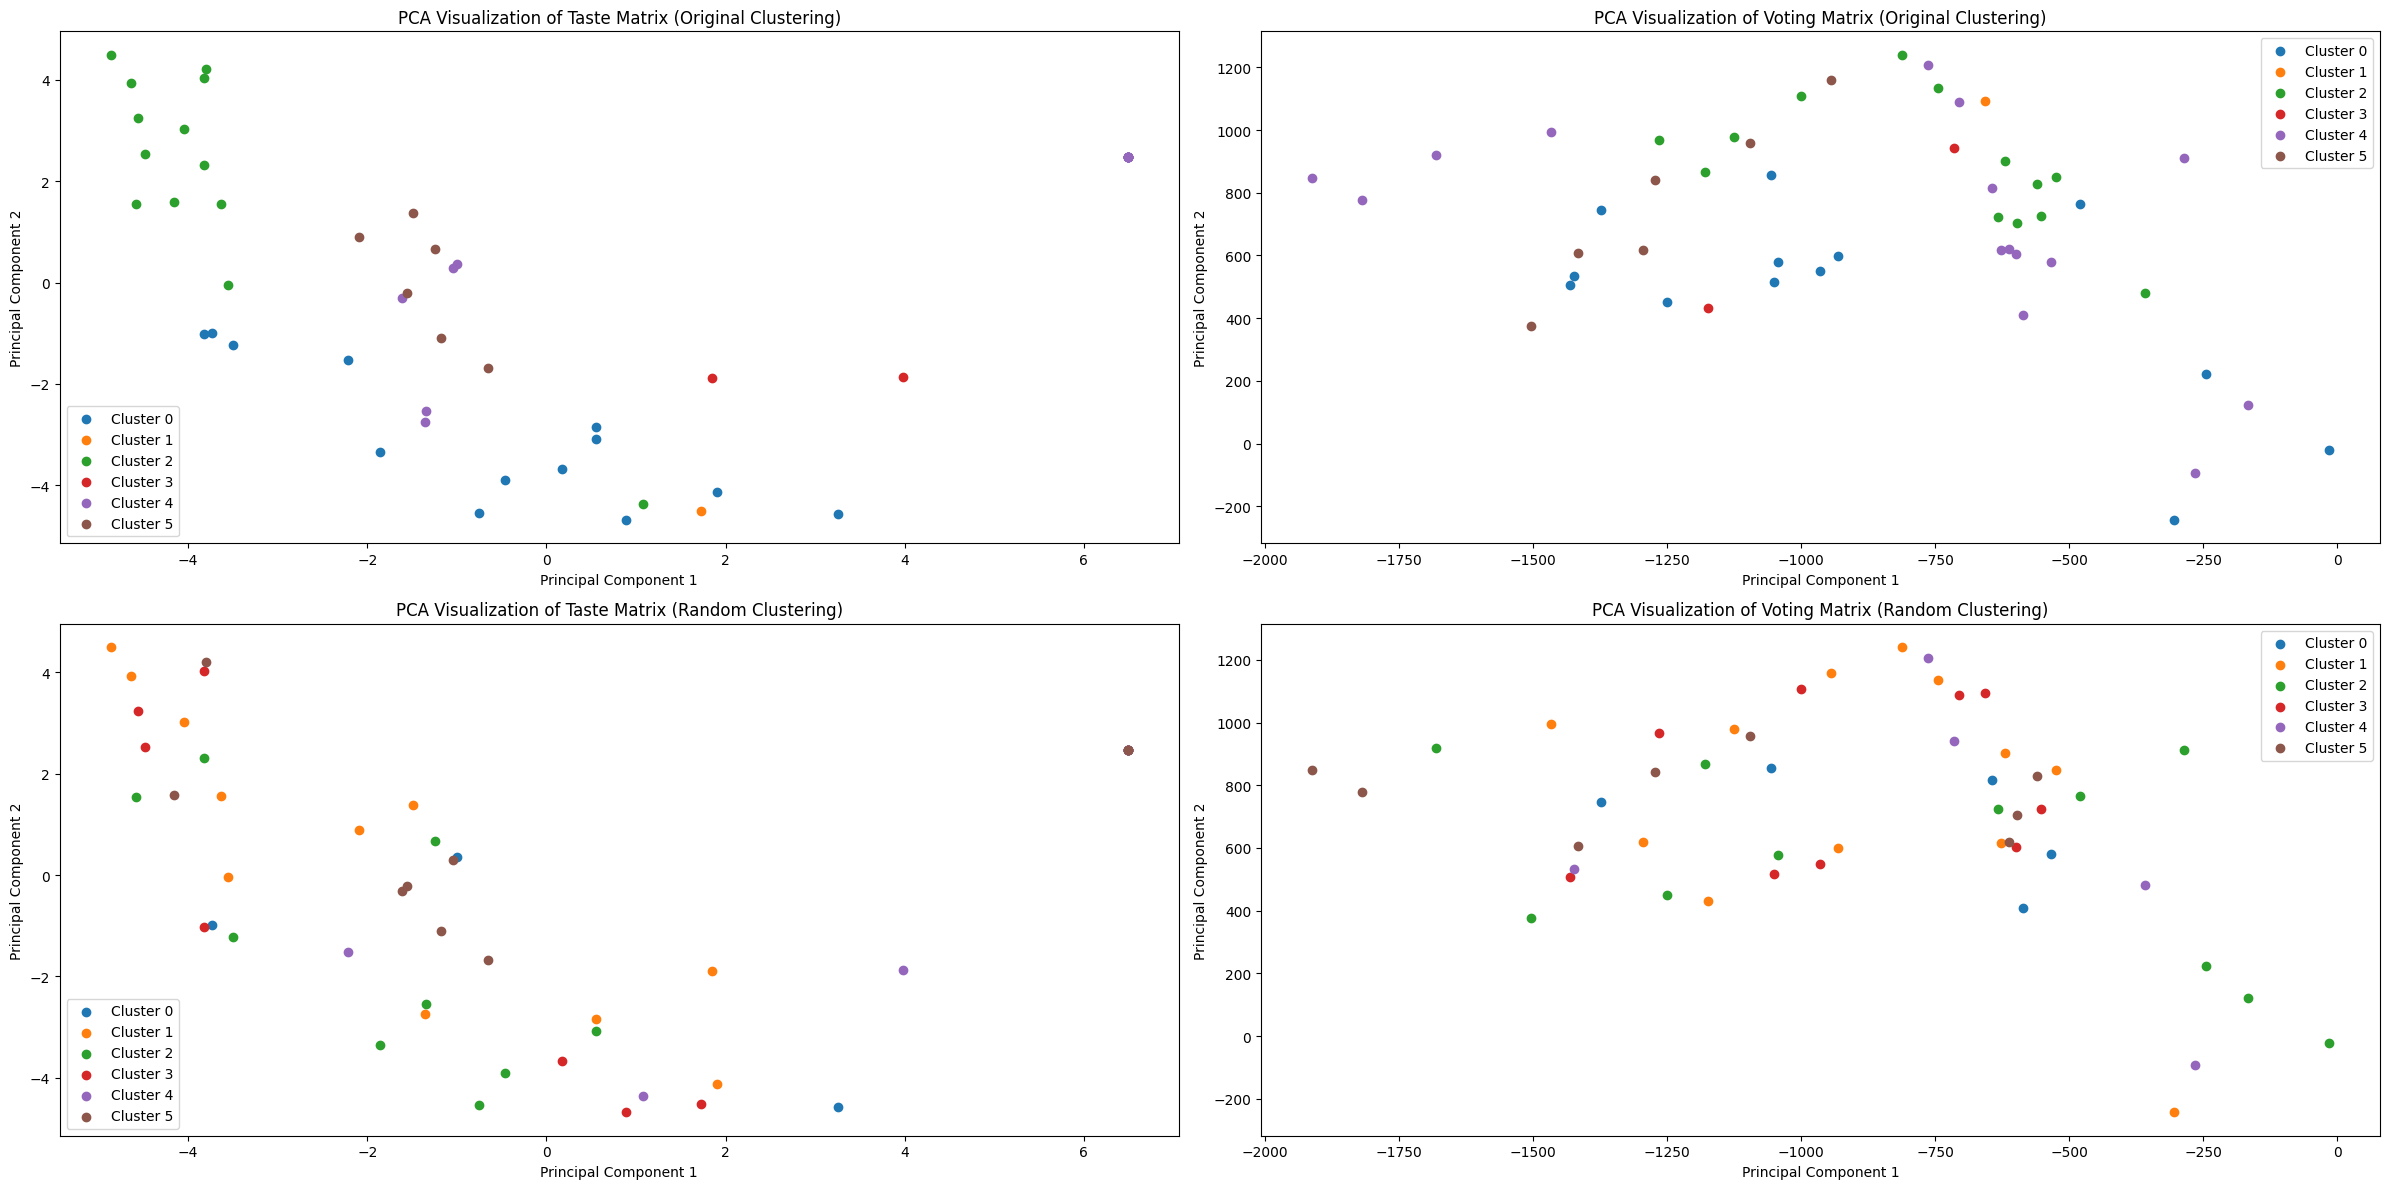

The silhouette score for Taste Matrix (Original) is: 0.23544784408658118
The silhouette score for Voting Matrix (Original) is: -0.18163105831254162
The silhouette score for Taste Matrix (Random) is: -0.11053587511924151
The silhouette score for Voting Matrix (Random) is: -0.10643237360207981


In [7]:
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 3, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 4, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 5, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 6, method='KMeans')

clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_total, 6, method='SpectralClustering')

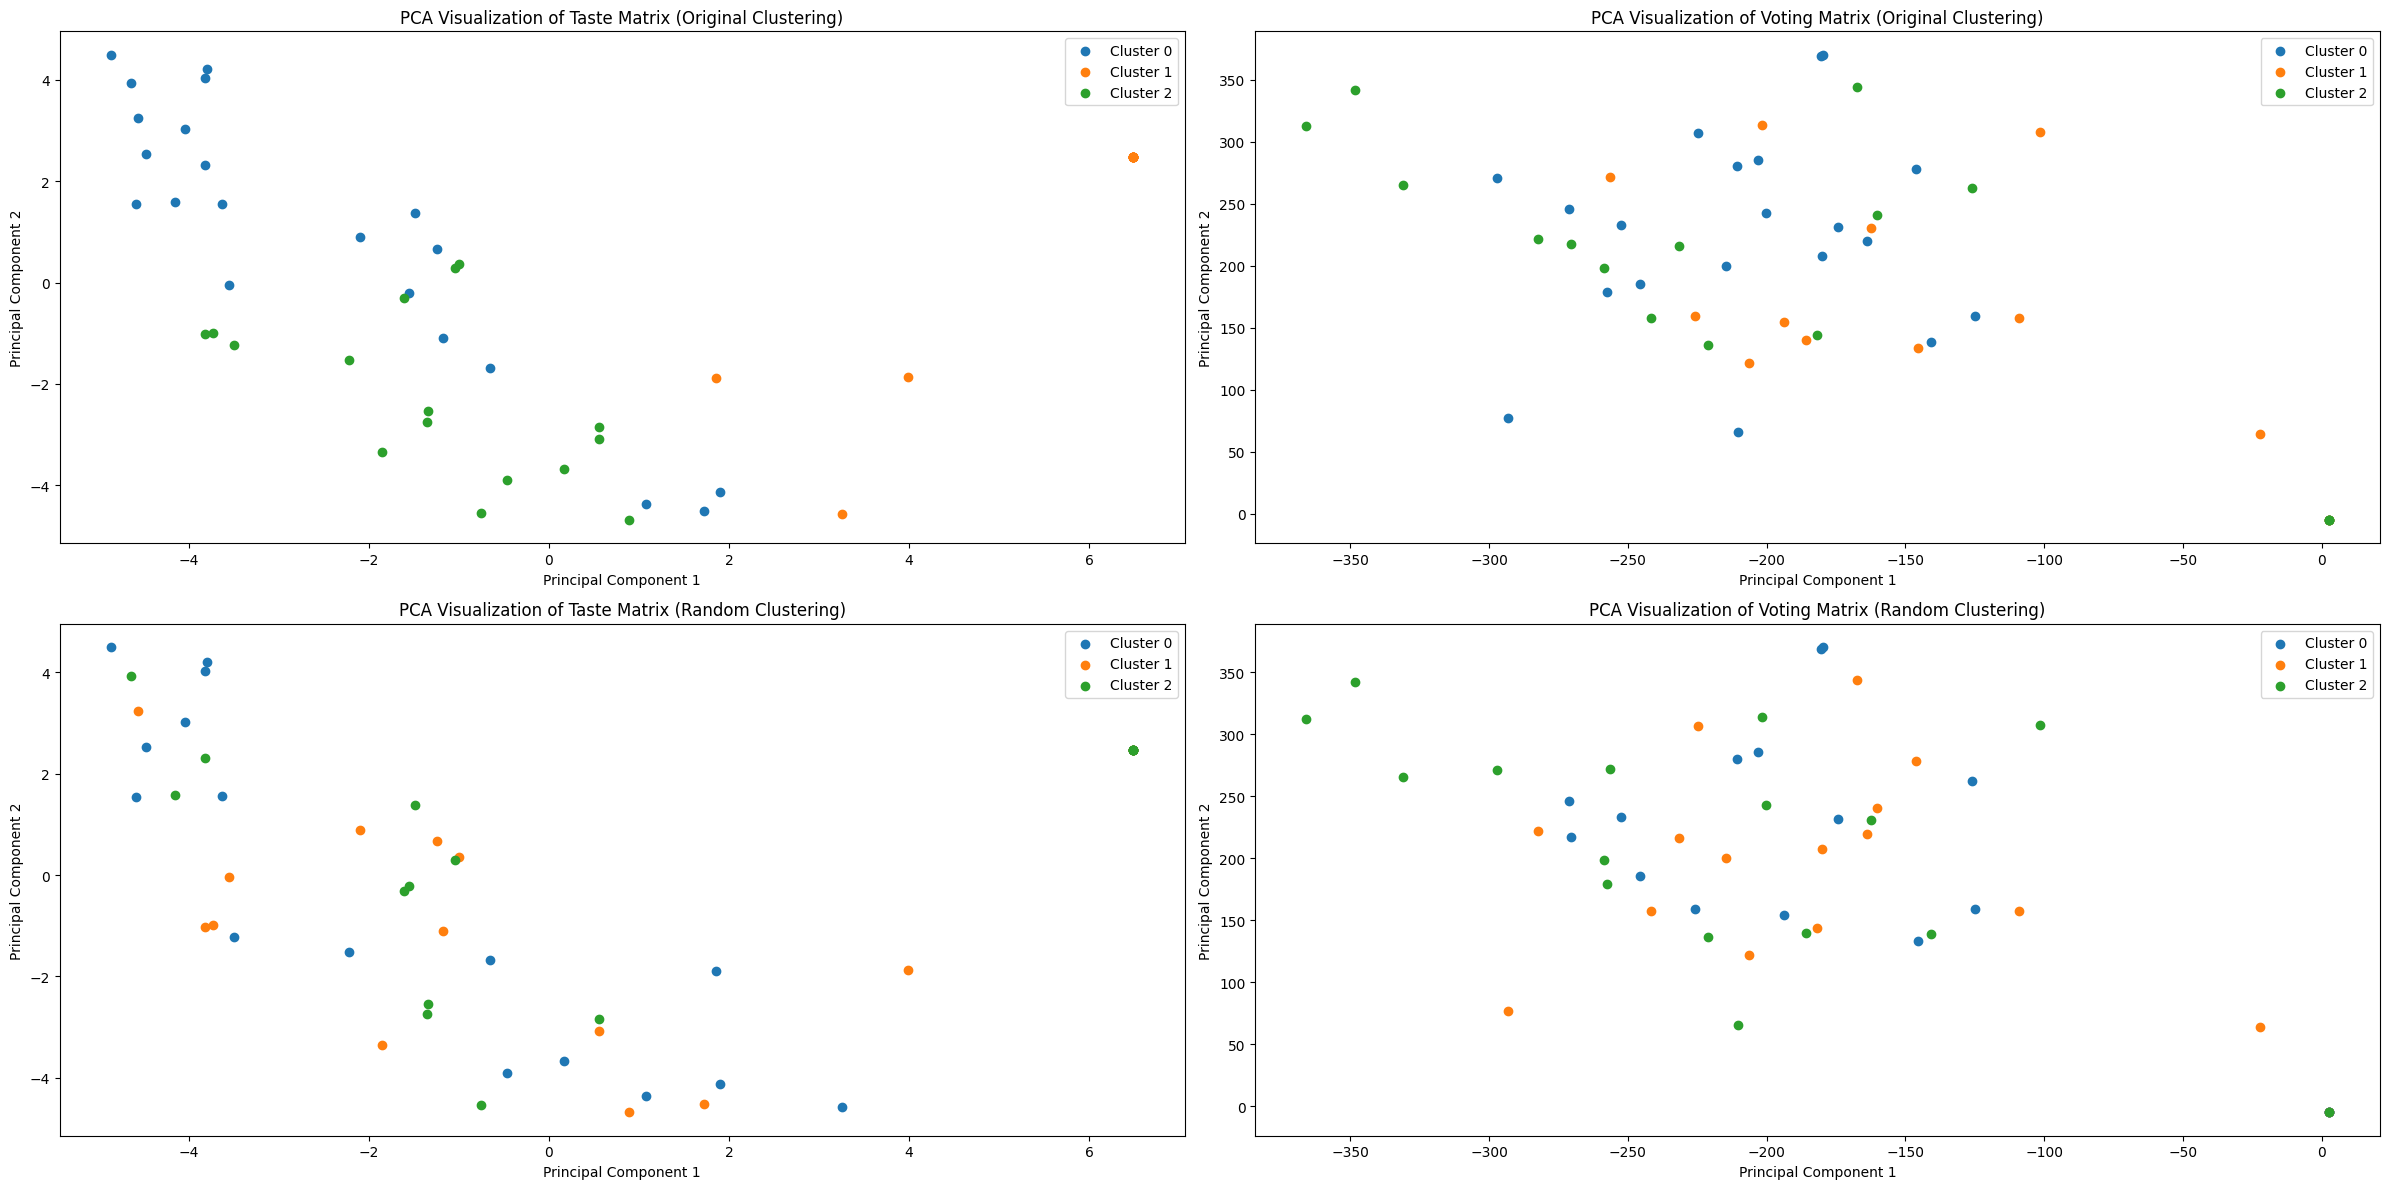

The silhouette score for Taste Matrix (Original) is: 0.27343912346199784
The silhouette score for Voting Matrix (Original) is: -0.024301368351392422
The silhouette score for Taste Matrix (Random) is: -0.03310289723858587
The silhouette score for Voting Matrix (Random) is: -0.023682935152945842


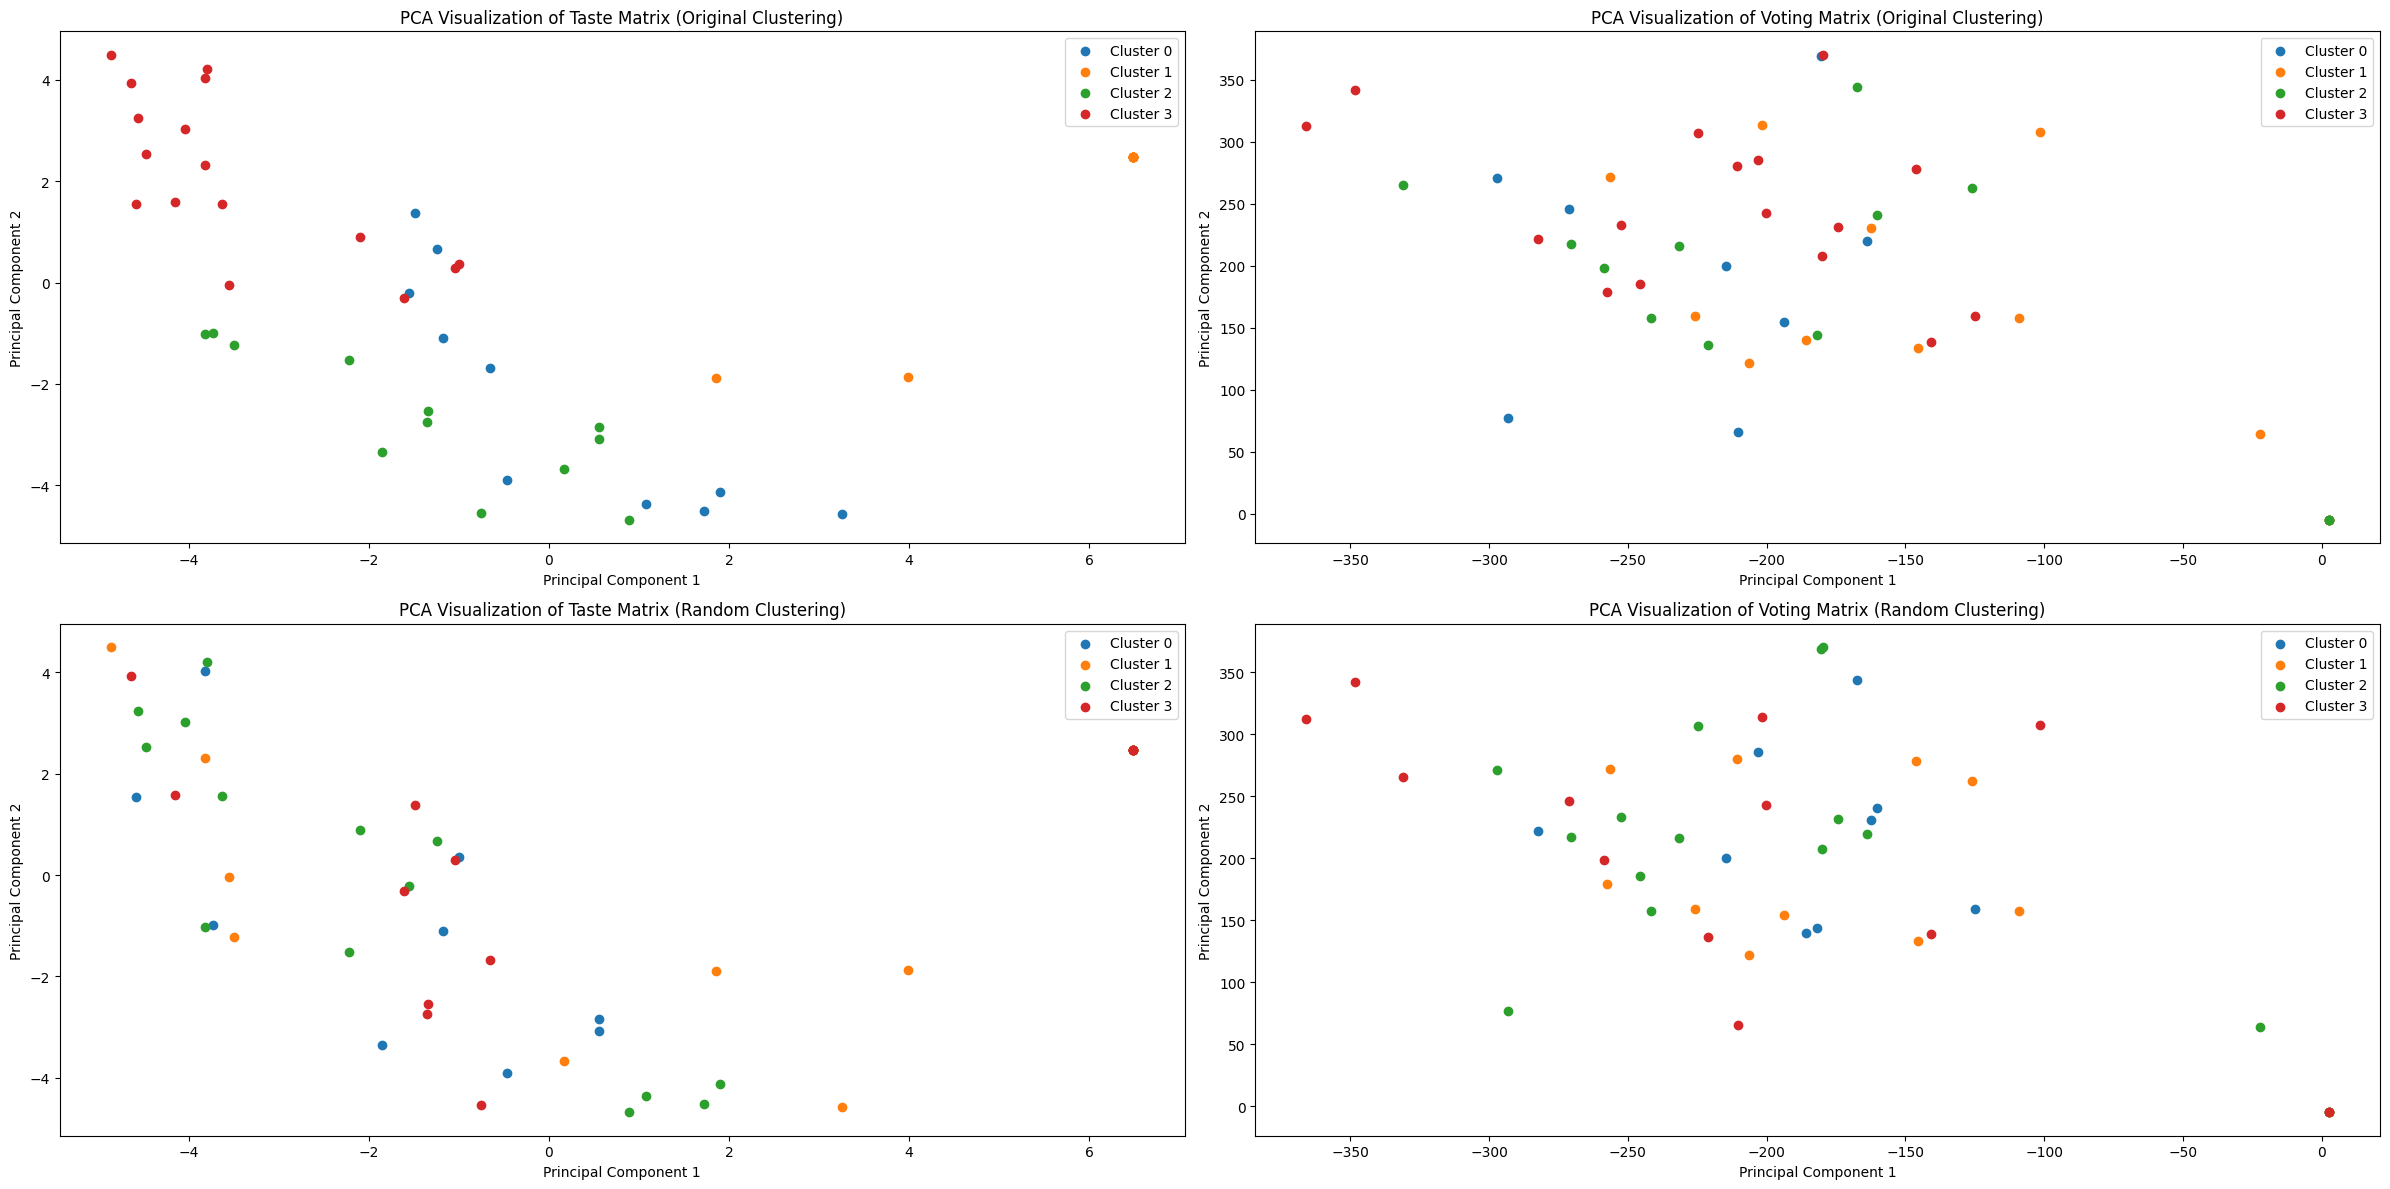

The silhouette score for Taste Matrix (Original) is: 0.3203752068939478
The silhouette score for Voting Matrix (Original) is: -0.036985969946301336
The silhouette score for Taste Matrix (Random) is: -0.05601430537584878
The silhouette score for Voting Matrix (Random) is: -0.03703708948151242


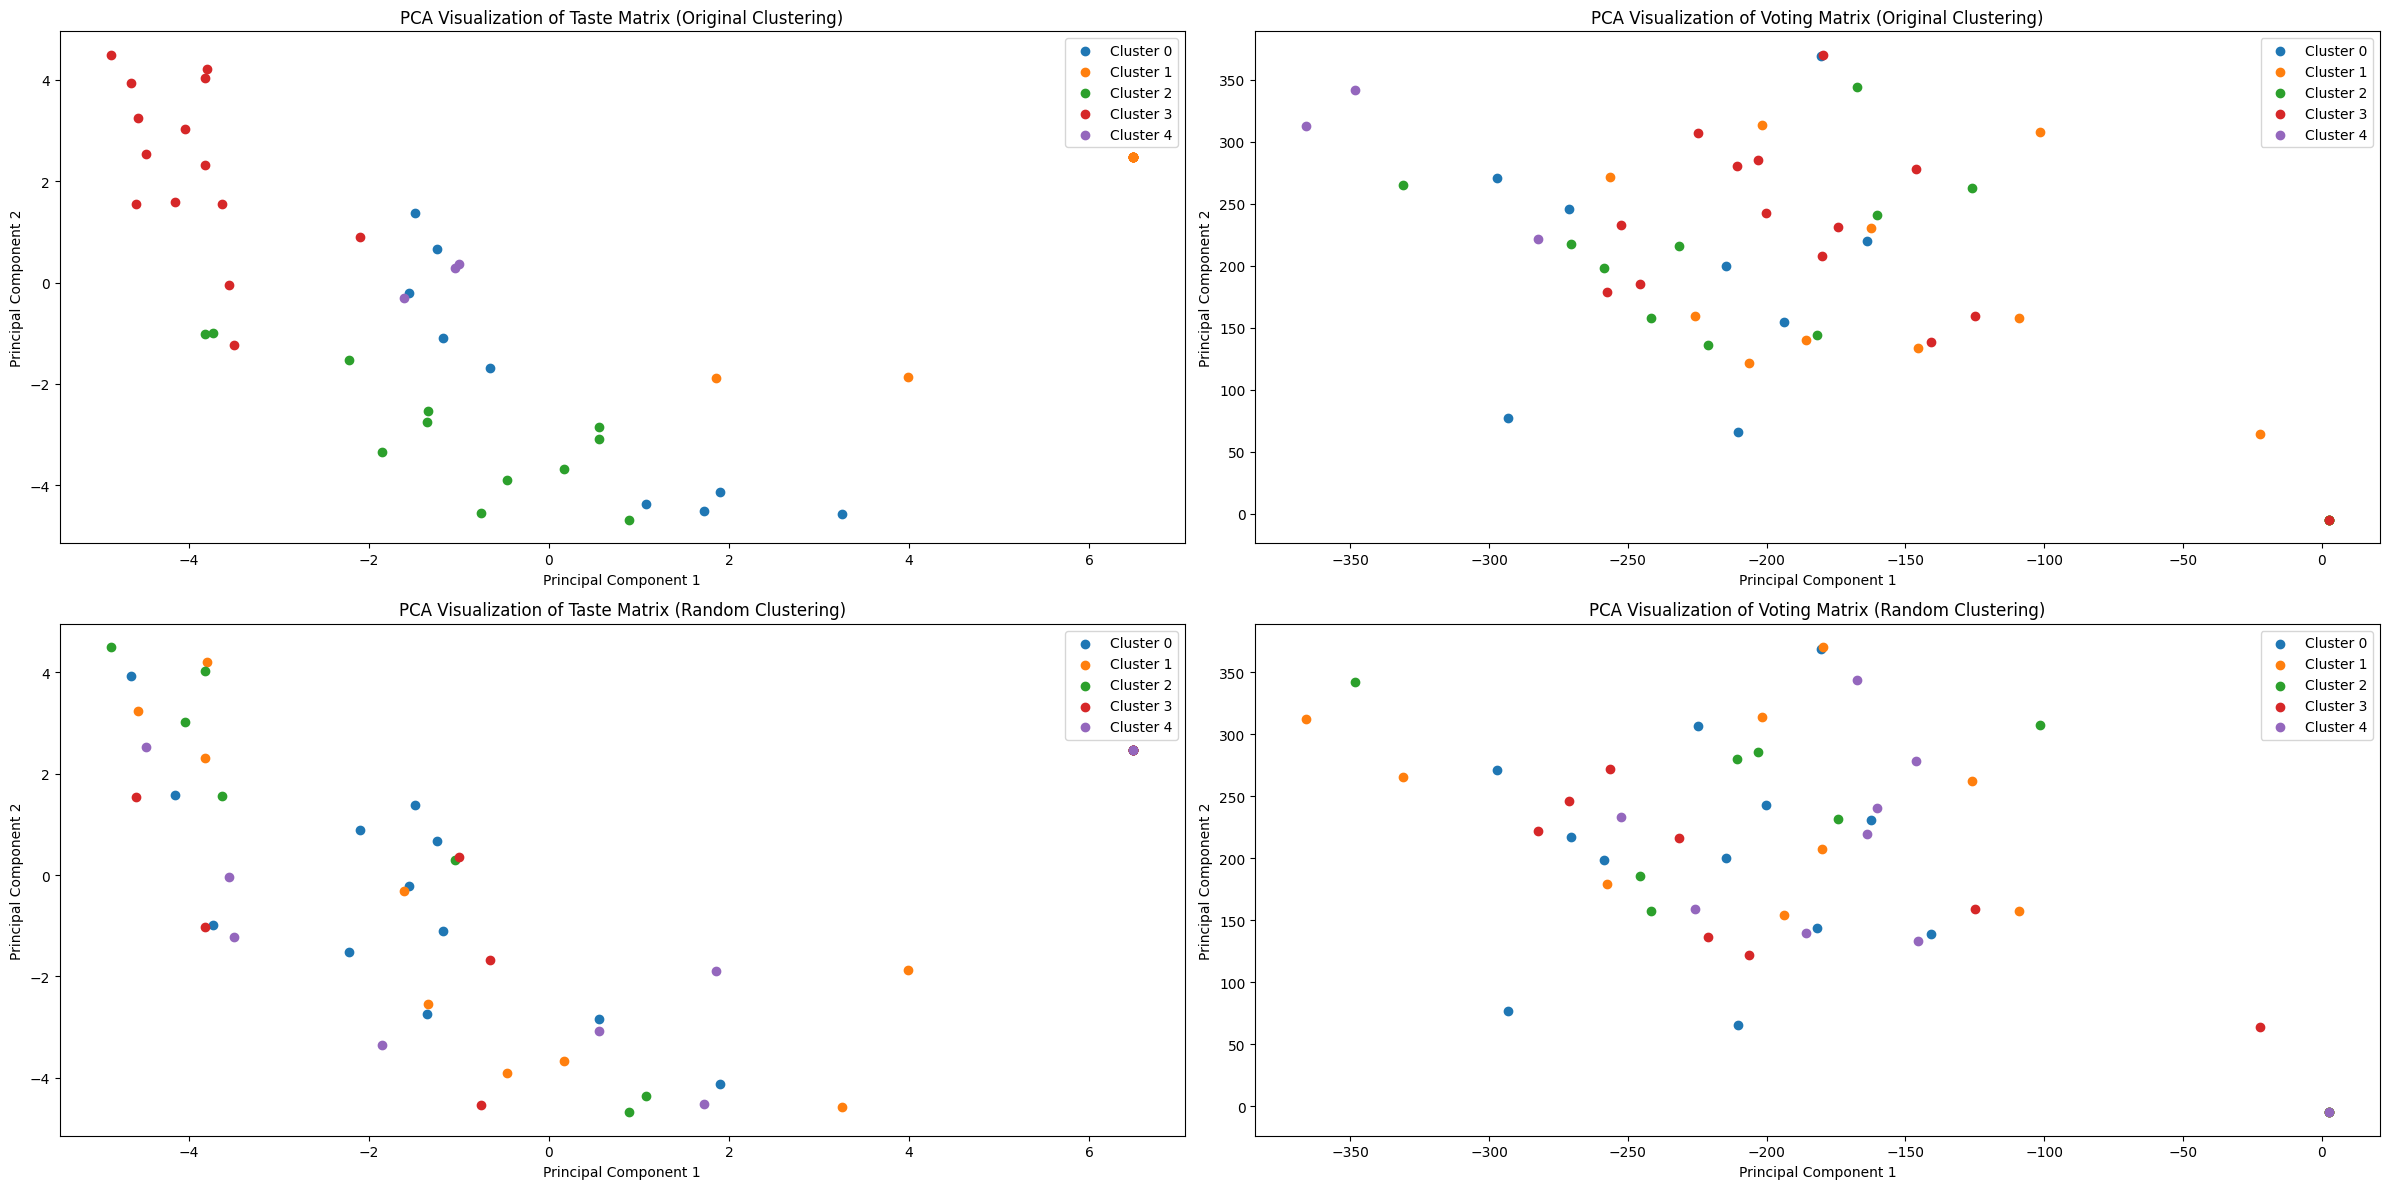

The silhouette score for Taste Matrix (Original) is: 0.3399109489774598
The silhouette score for Voting Matrix (Original) is: -0.046015109964091166
The silhouette score for Taste Matrix (Random) is: -0.07997866306055916
The silhouette score for Voting Matrix (Random) is: -0.06246431092924748


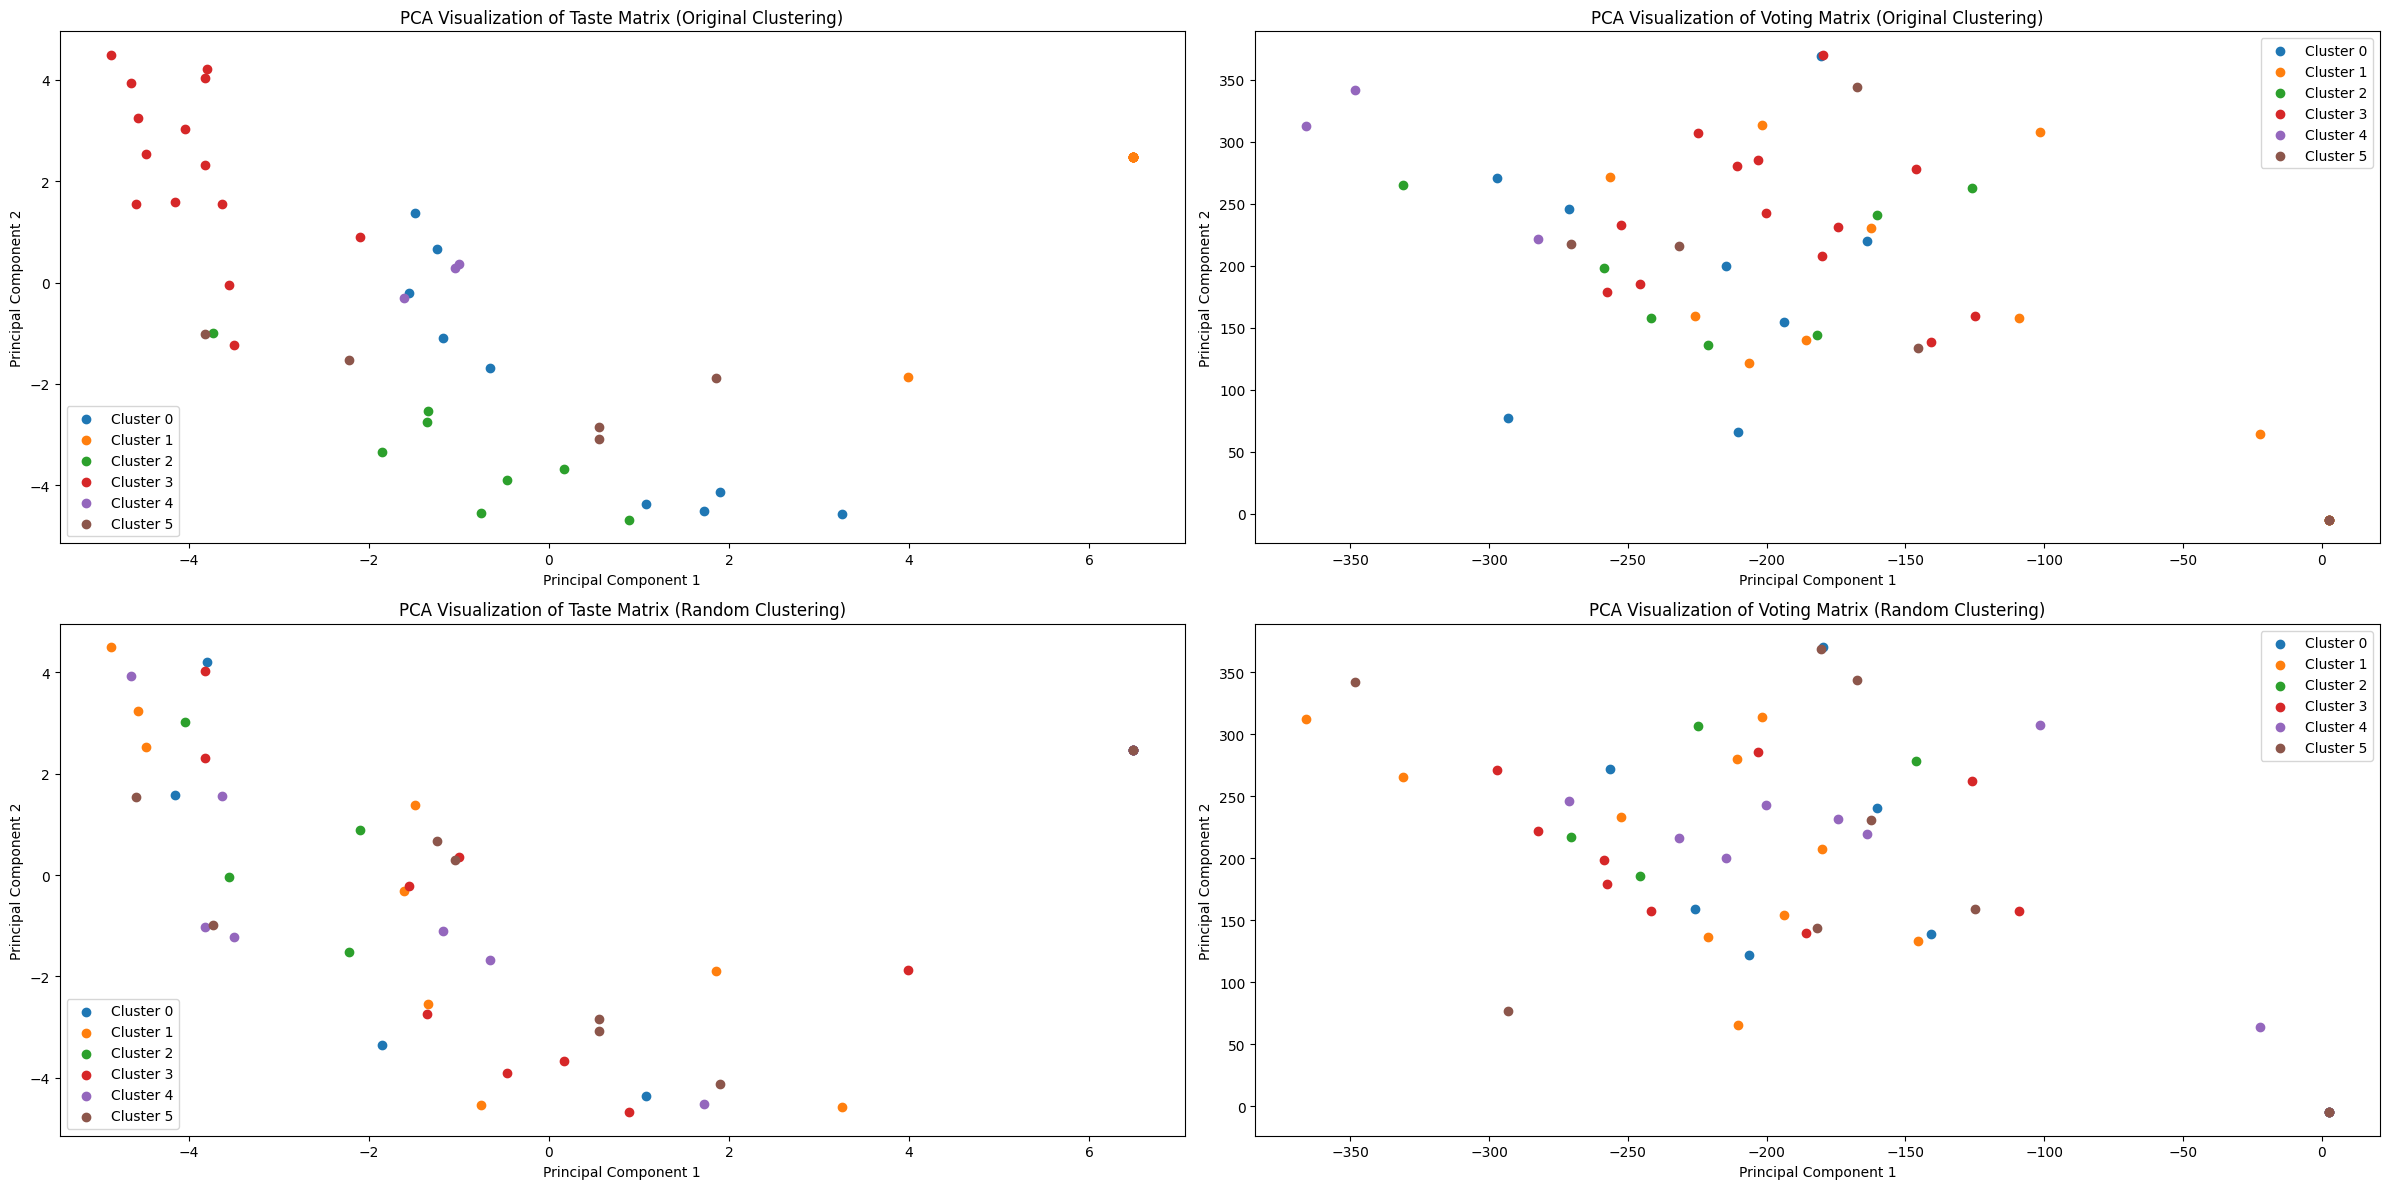

The silhouette score for Taste Matrix (Original) is: 0.3177506662858891
The silhouette score for Voting Matrix (Original) is: -0.06970794899617334
The silhouette score for Taste Matrix (Random) is: -0.10824004807481584
The silhouette score for Voting Matrix (Random) is: -0.06459807097479225


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.53575940e-13 1.17410682e-07 4.42877625e-08 2.50311259e-05]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 1714 instead with accuracy 
2.1051704250273214e-06.

  _, diffusion_map = lobpcg(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.53386652e-14 1.17510520e-07 4.27554460e-08 8.26041549e-06]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


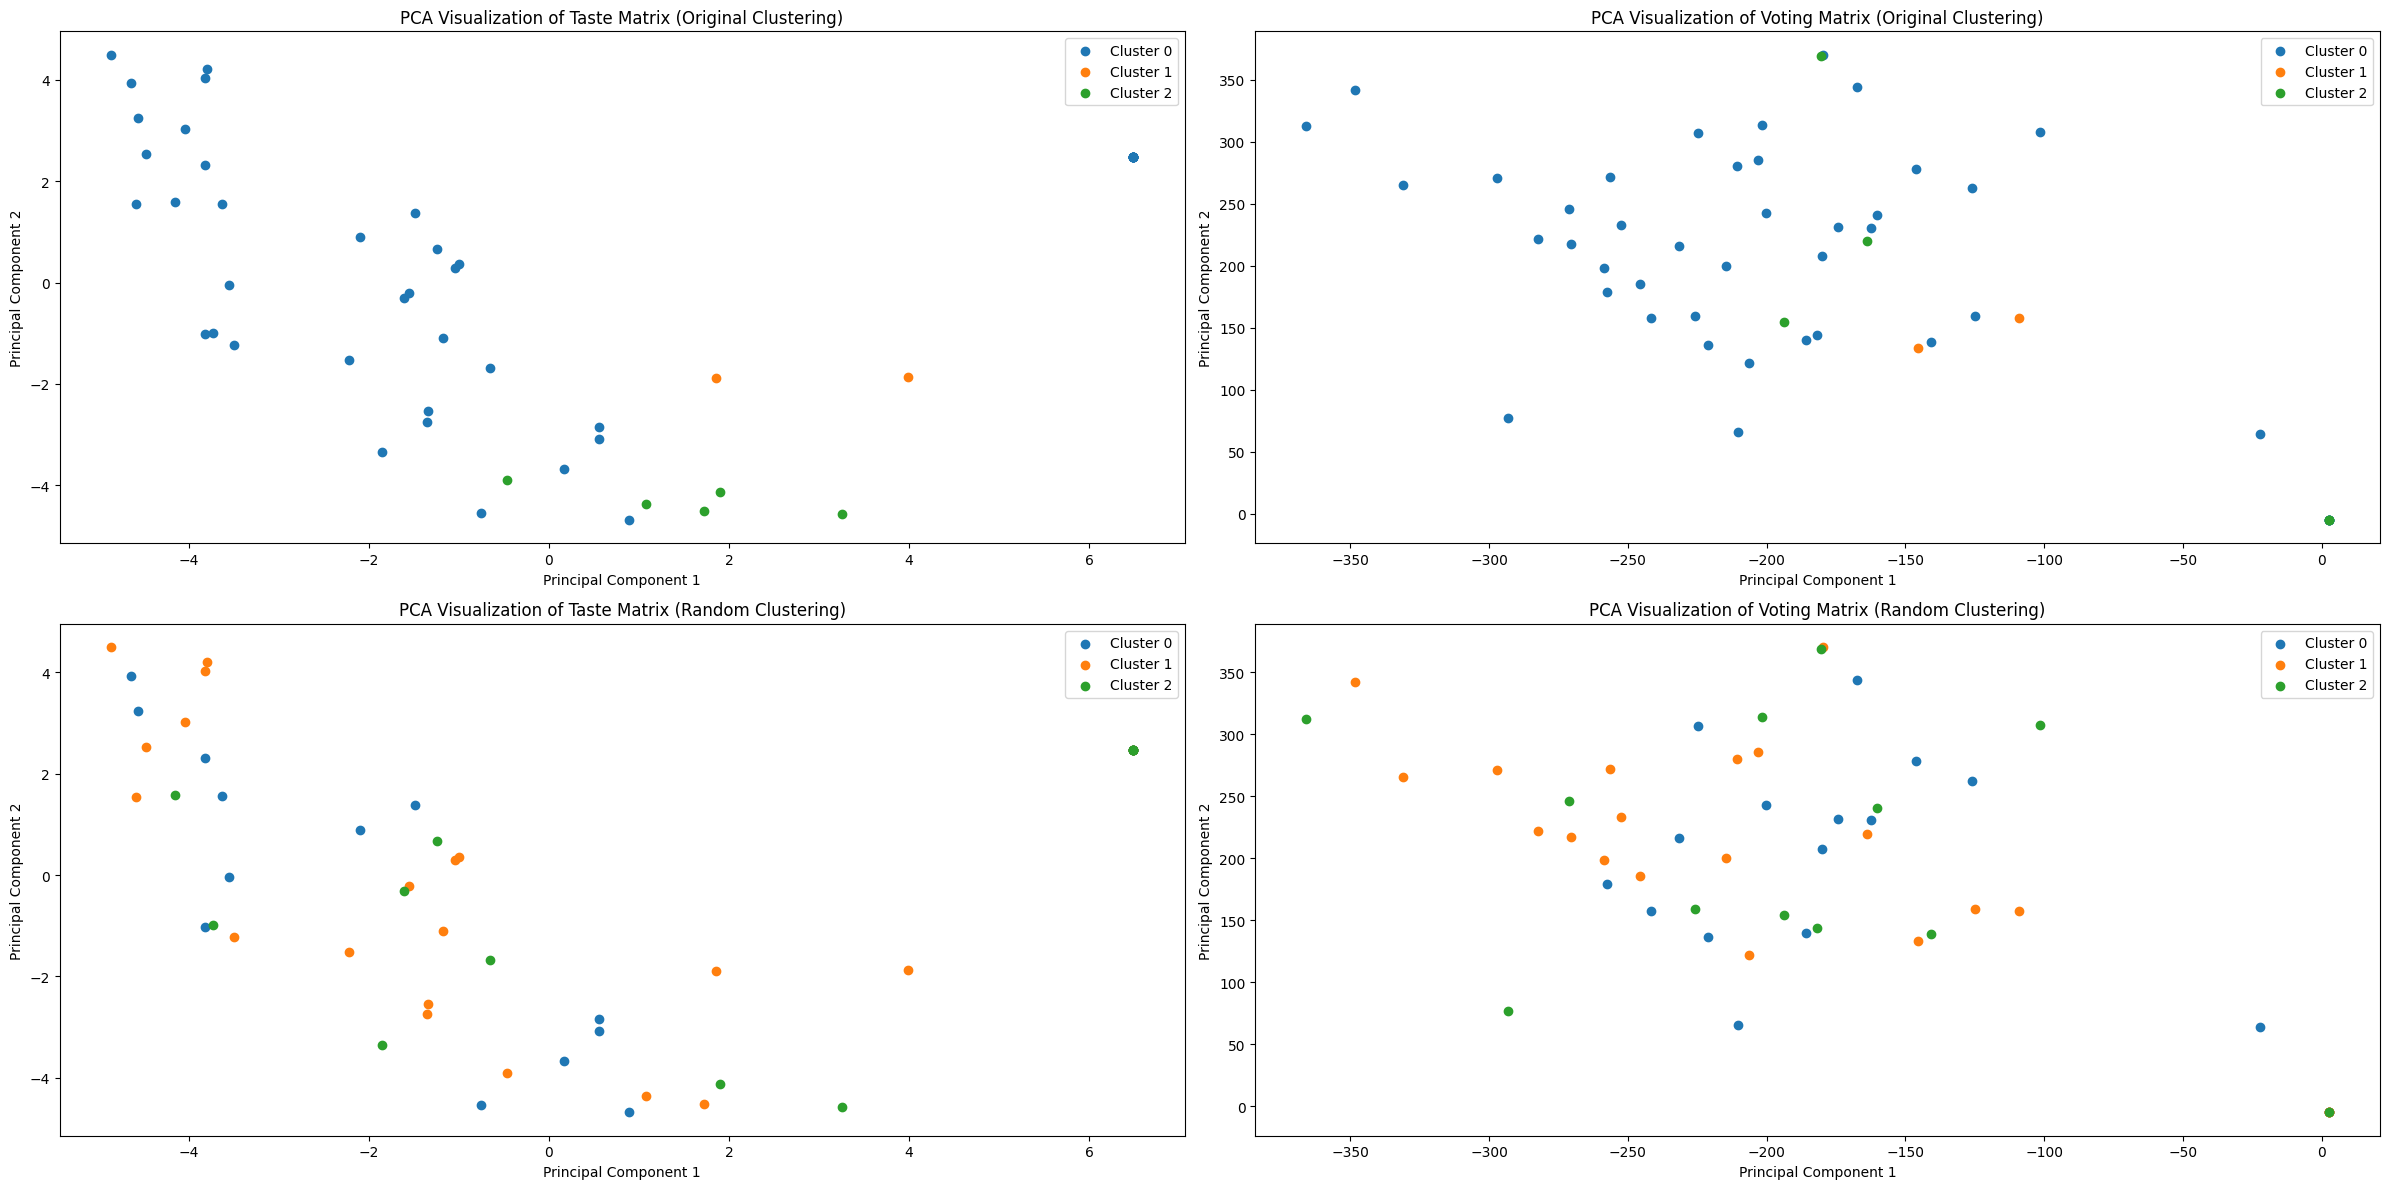

The silhouette score for Taste Matrix (Original) is: 0.09894566771759679
The silhouette score for Voting Matrix (Original) is: -0.10933257568141093
The silhouette score for Taste Matrix (Random) is: -0.04781204439262721
The silhouette score for Voting Matrix (Random) is: -0.027731858425967246


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


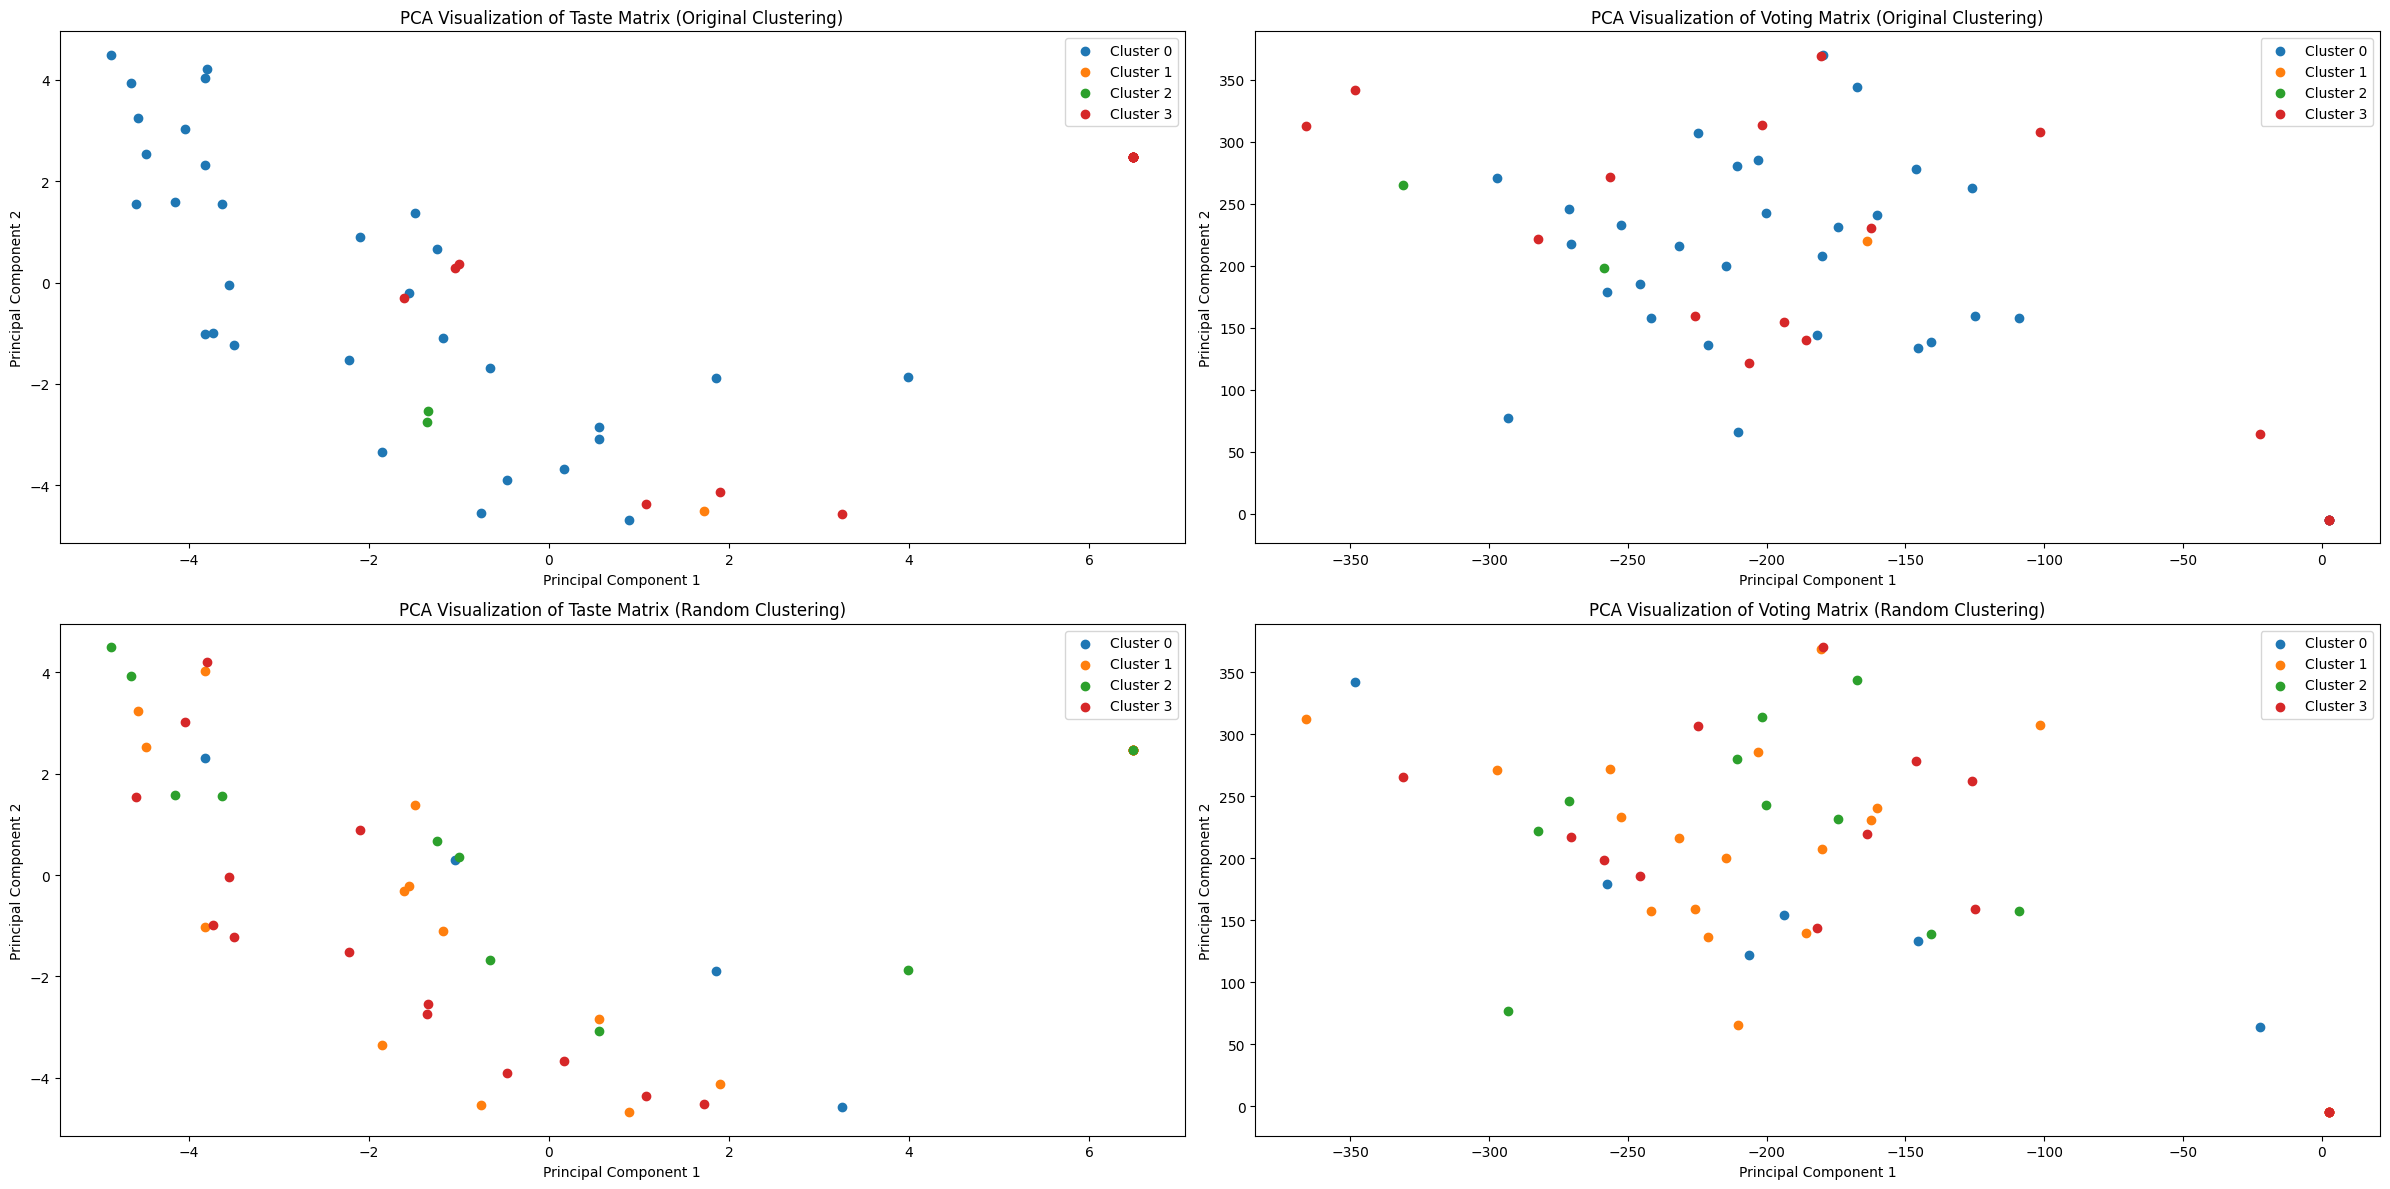

The silhouette score for Taste Matrix (Original) is: 0.16070419254348547
The silhouette score for Voting Matrix (Original) is: -0.16311001806429407
The silhouette score for Taste Matrix (Random) is: -0.05631872643117734
The silhouette score for Voting Matrix (Random) is: -0.04642043693962243


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


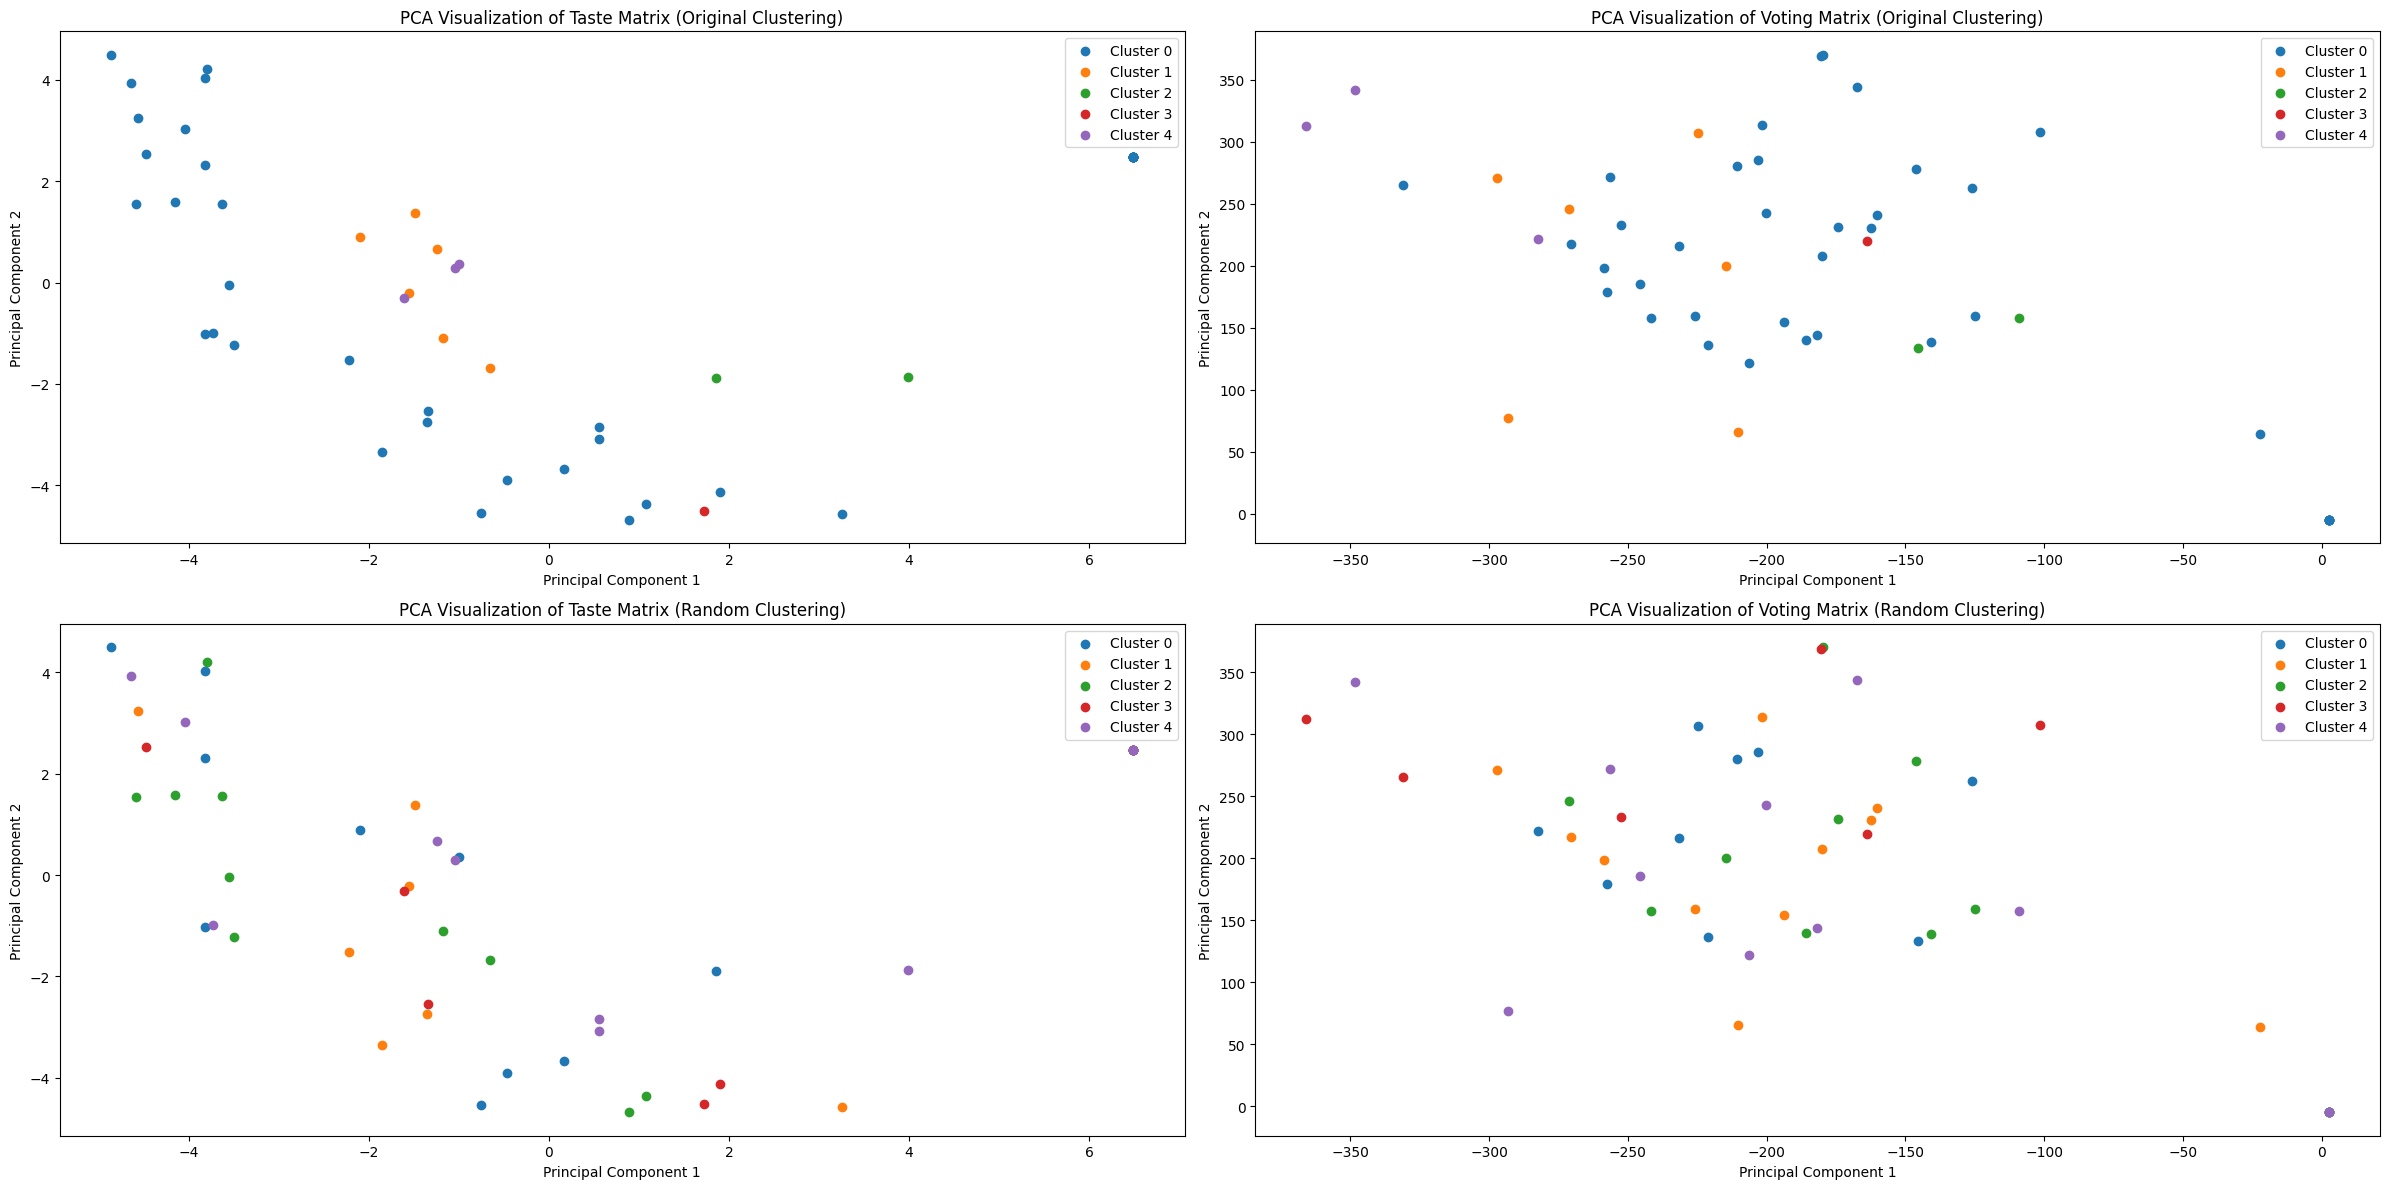

The silhouette score for Taste Matrix (Original) is: 0.05402981734882715
The silhouette score for Voting Matrix (Original) is: -0.1480600650926881
The silhouette score for Taste Matrix (Random) is: -0.0702524466541034
The silhouette score for Voting Matrix (Random) is: -0.05942960610633221


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


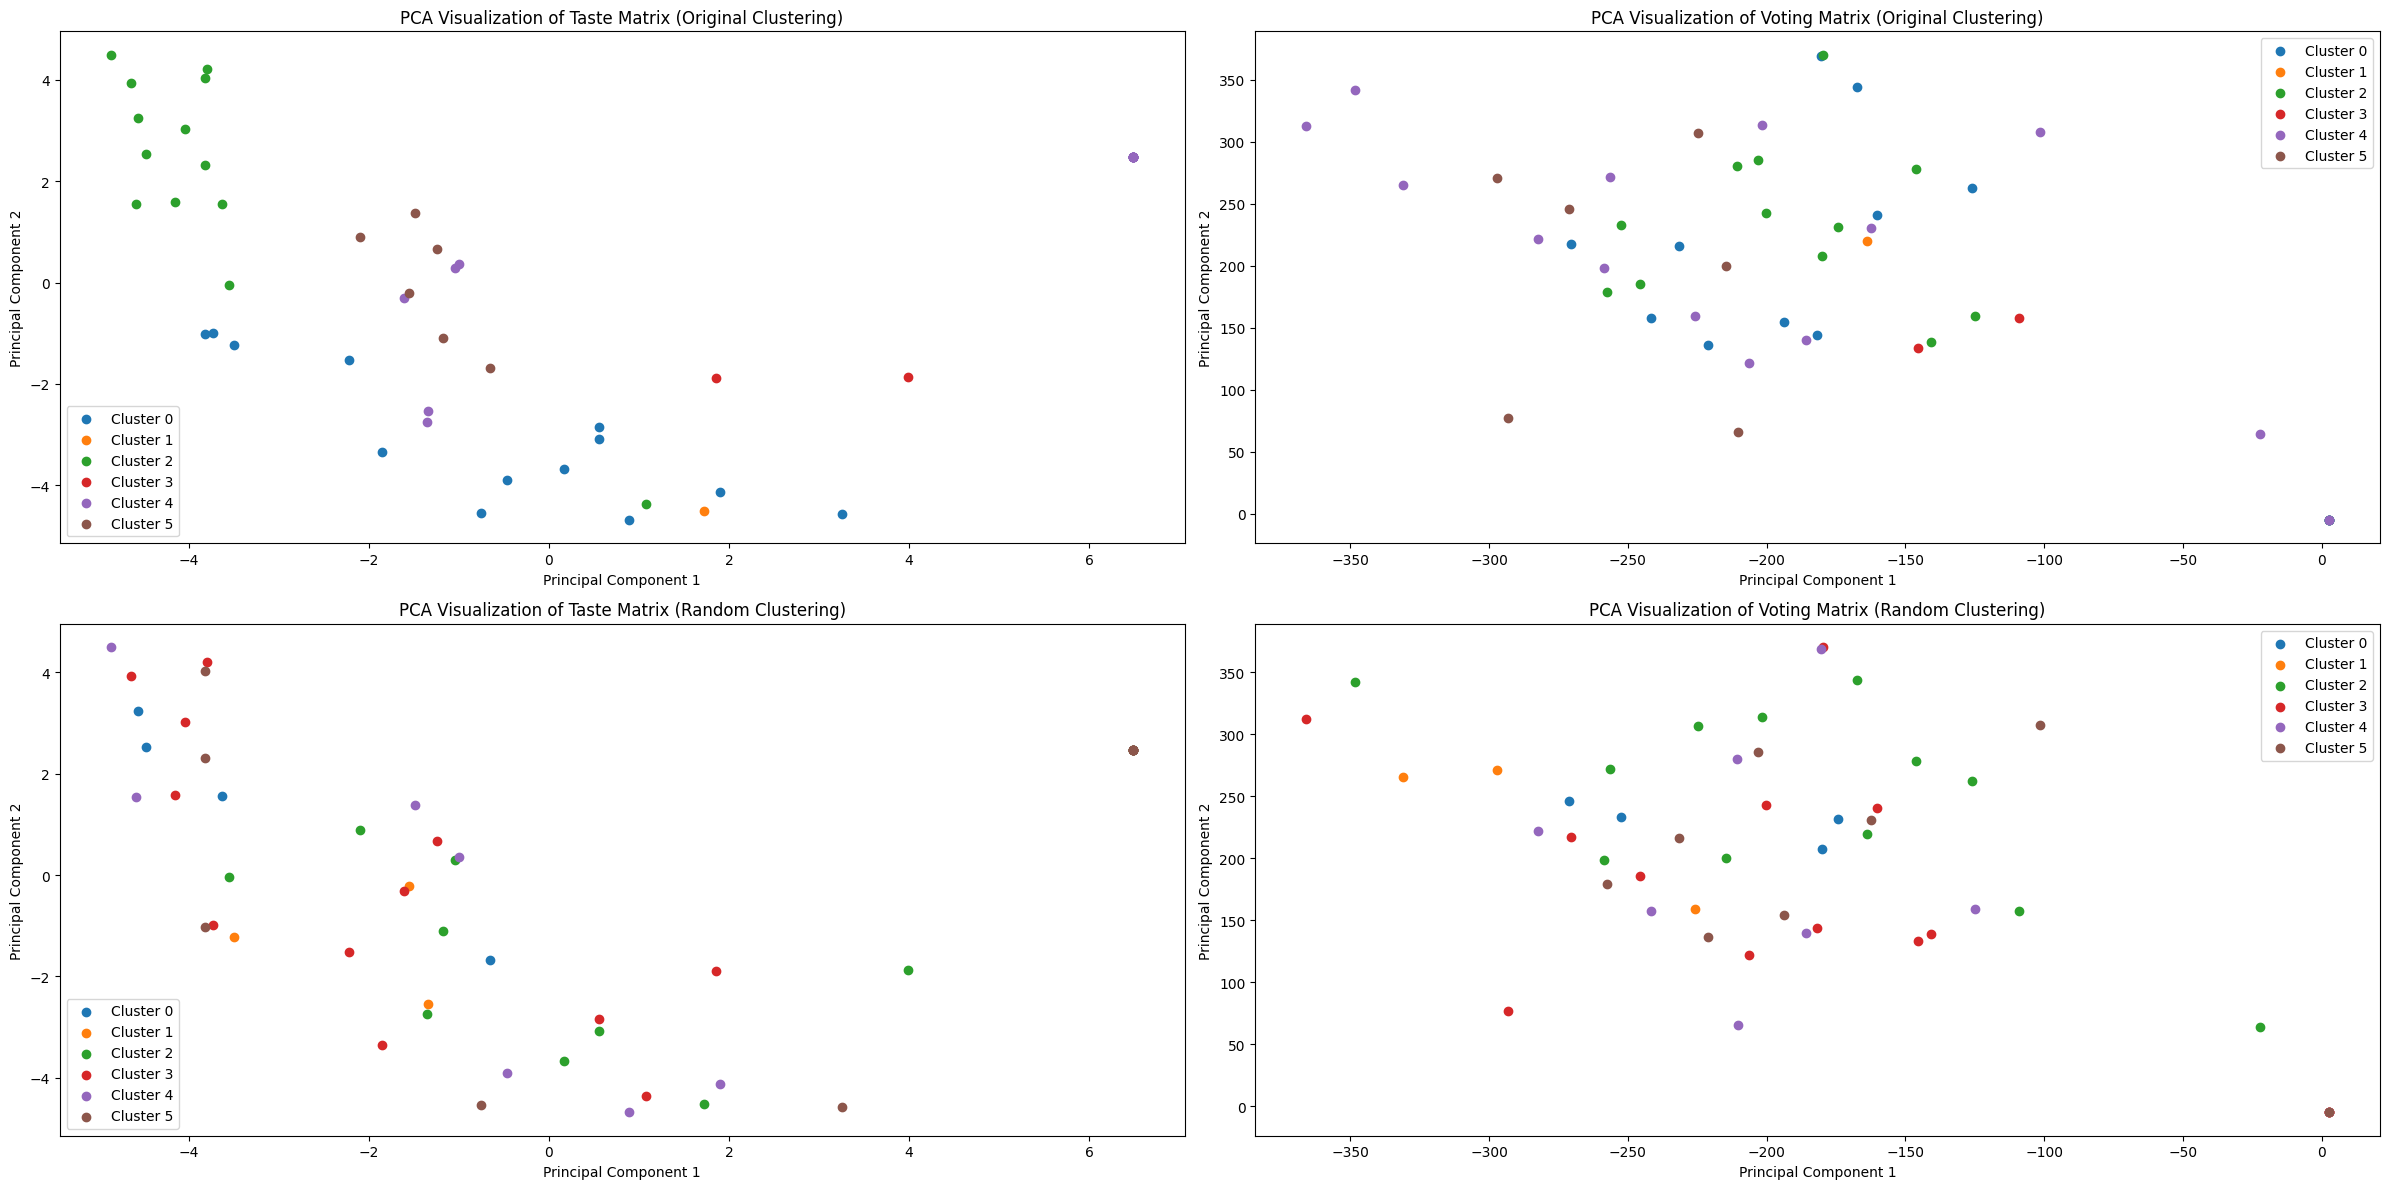

The silhouette score for Taste Matrix (Original) is: 0.23544784408658118
The silhouette score for Voting Matrix (Original) is: -0.15855417033257016
The silhouette score for Taste Matrix (Random) is: -0.13115139367795814
The silhouette score for Voting Matrix (Random) is: -0.07633390874384444


In [8]:
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 3, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 4, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 5, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 6, method='KMeans')

clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_tele, 6, method='SpectralClustering')

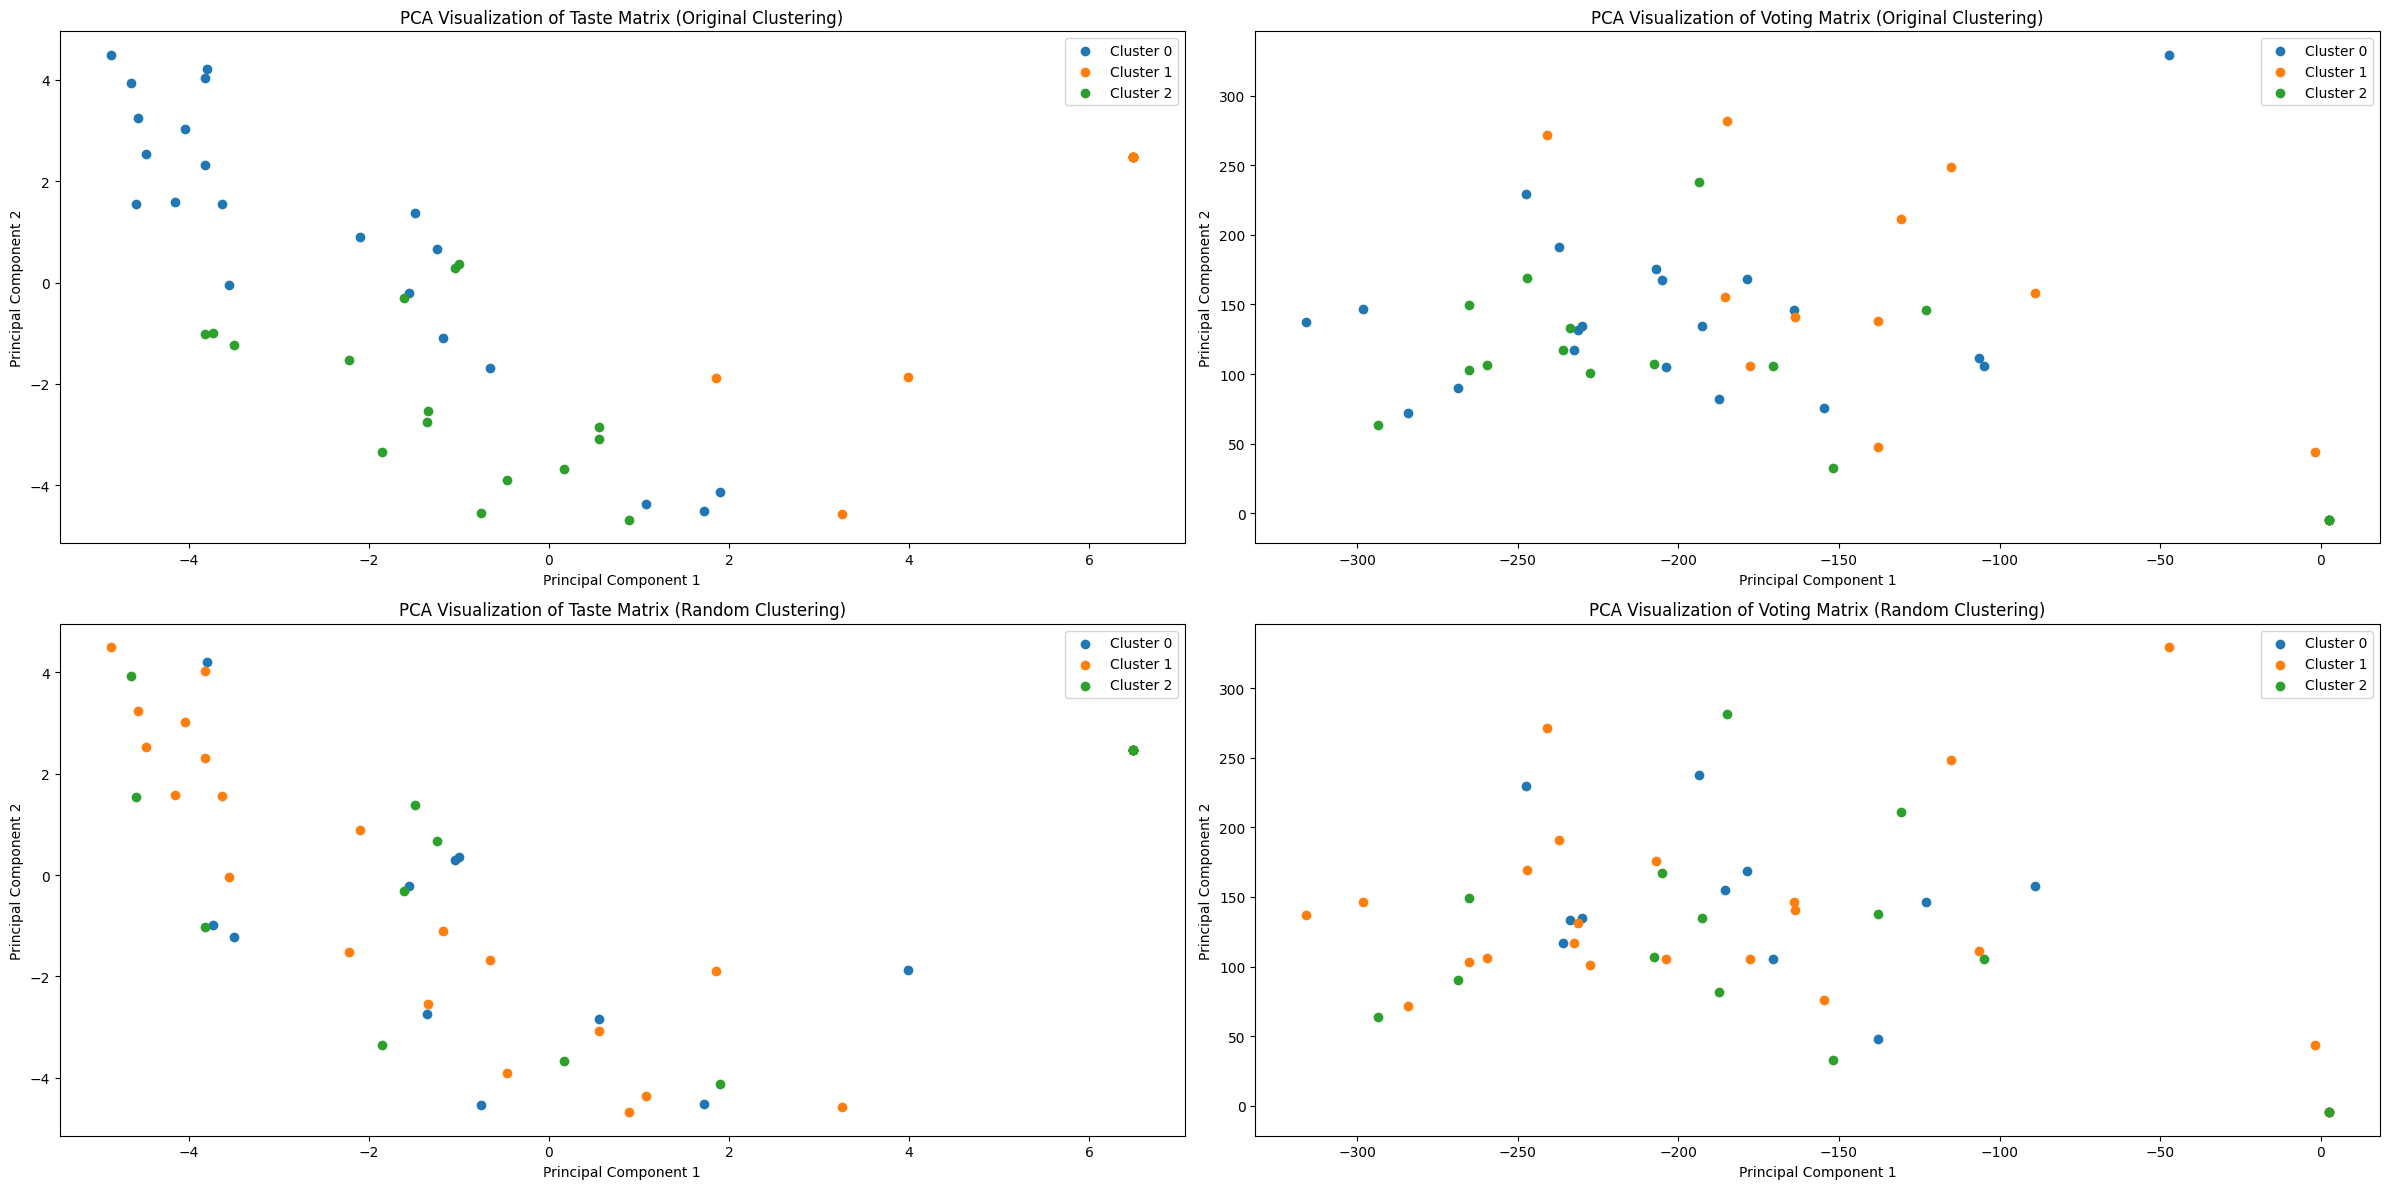

The silhouette score for Taste Matrix (Original) is: 0.27343912346199784
The silhouette score for Voting Matrix (Original) is: -0.0162914134437871
The silhouette score for Taste Matrix (Random) is: -0.0351074954319158
The silhouette score for Voting Matrix (Random) is: -0.02894862170639589


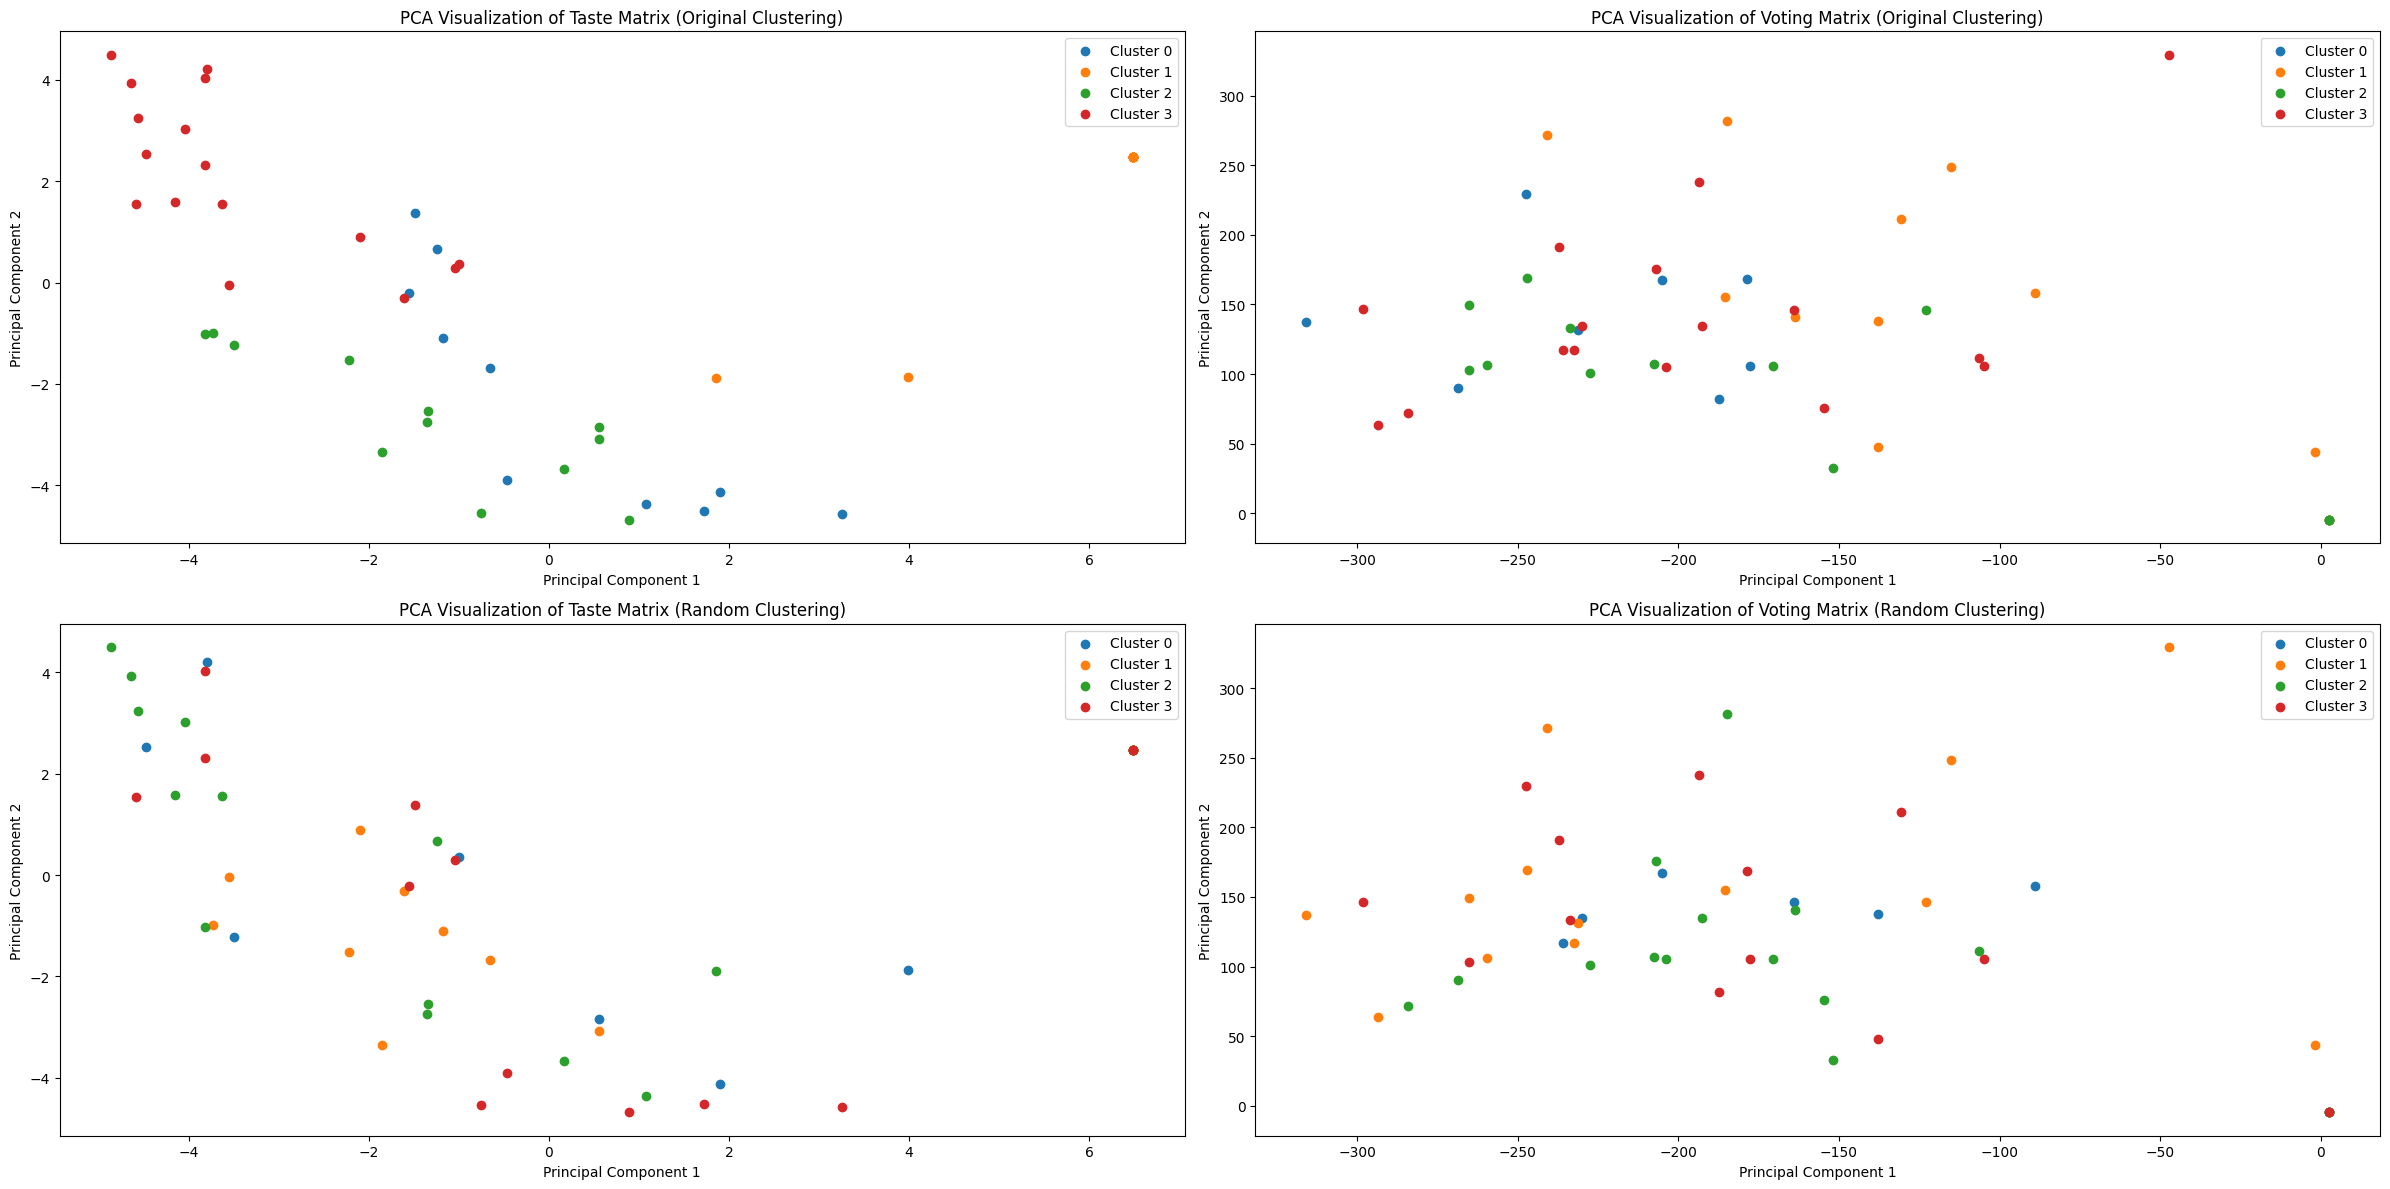

The silhouette score for Taste Matrix (Original) is: 0.3203752068939478
The silhouette score for Voting Matrix (Original) is: -0.03901030040899128
The silhouette score for Taste Matrix (Random) is: -0.053618081436595494
The silhouette score for Voting Matrix (Random) is: -0.04247954078142218


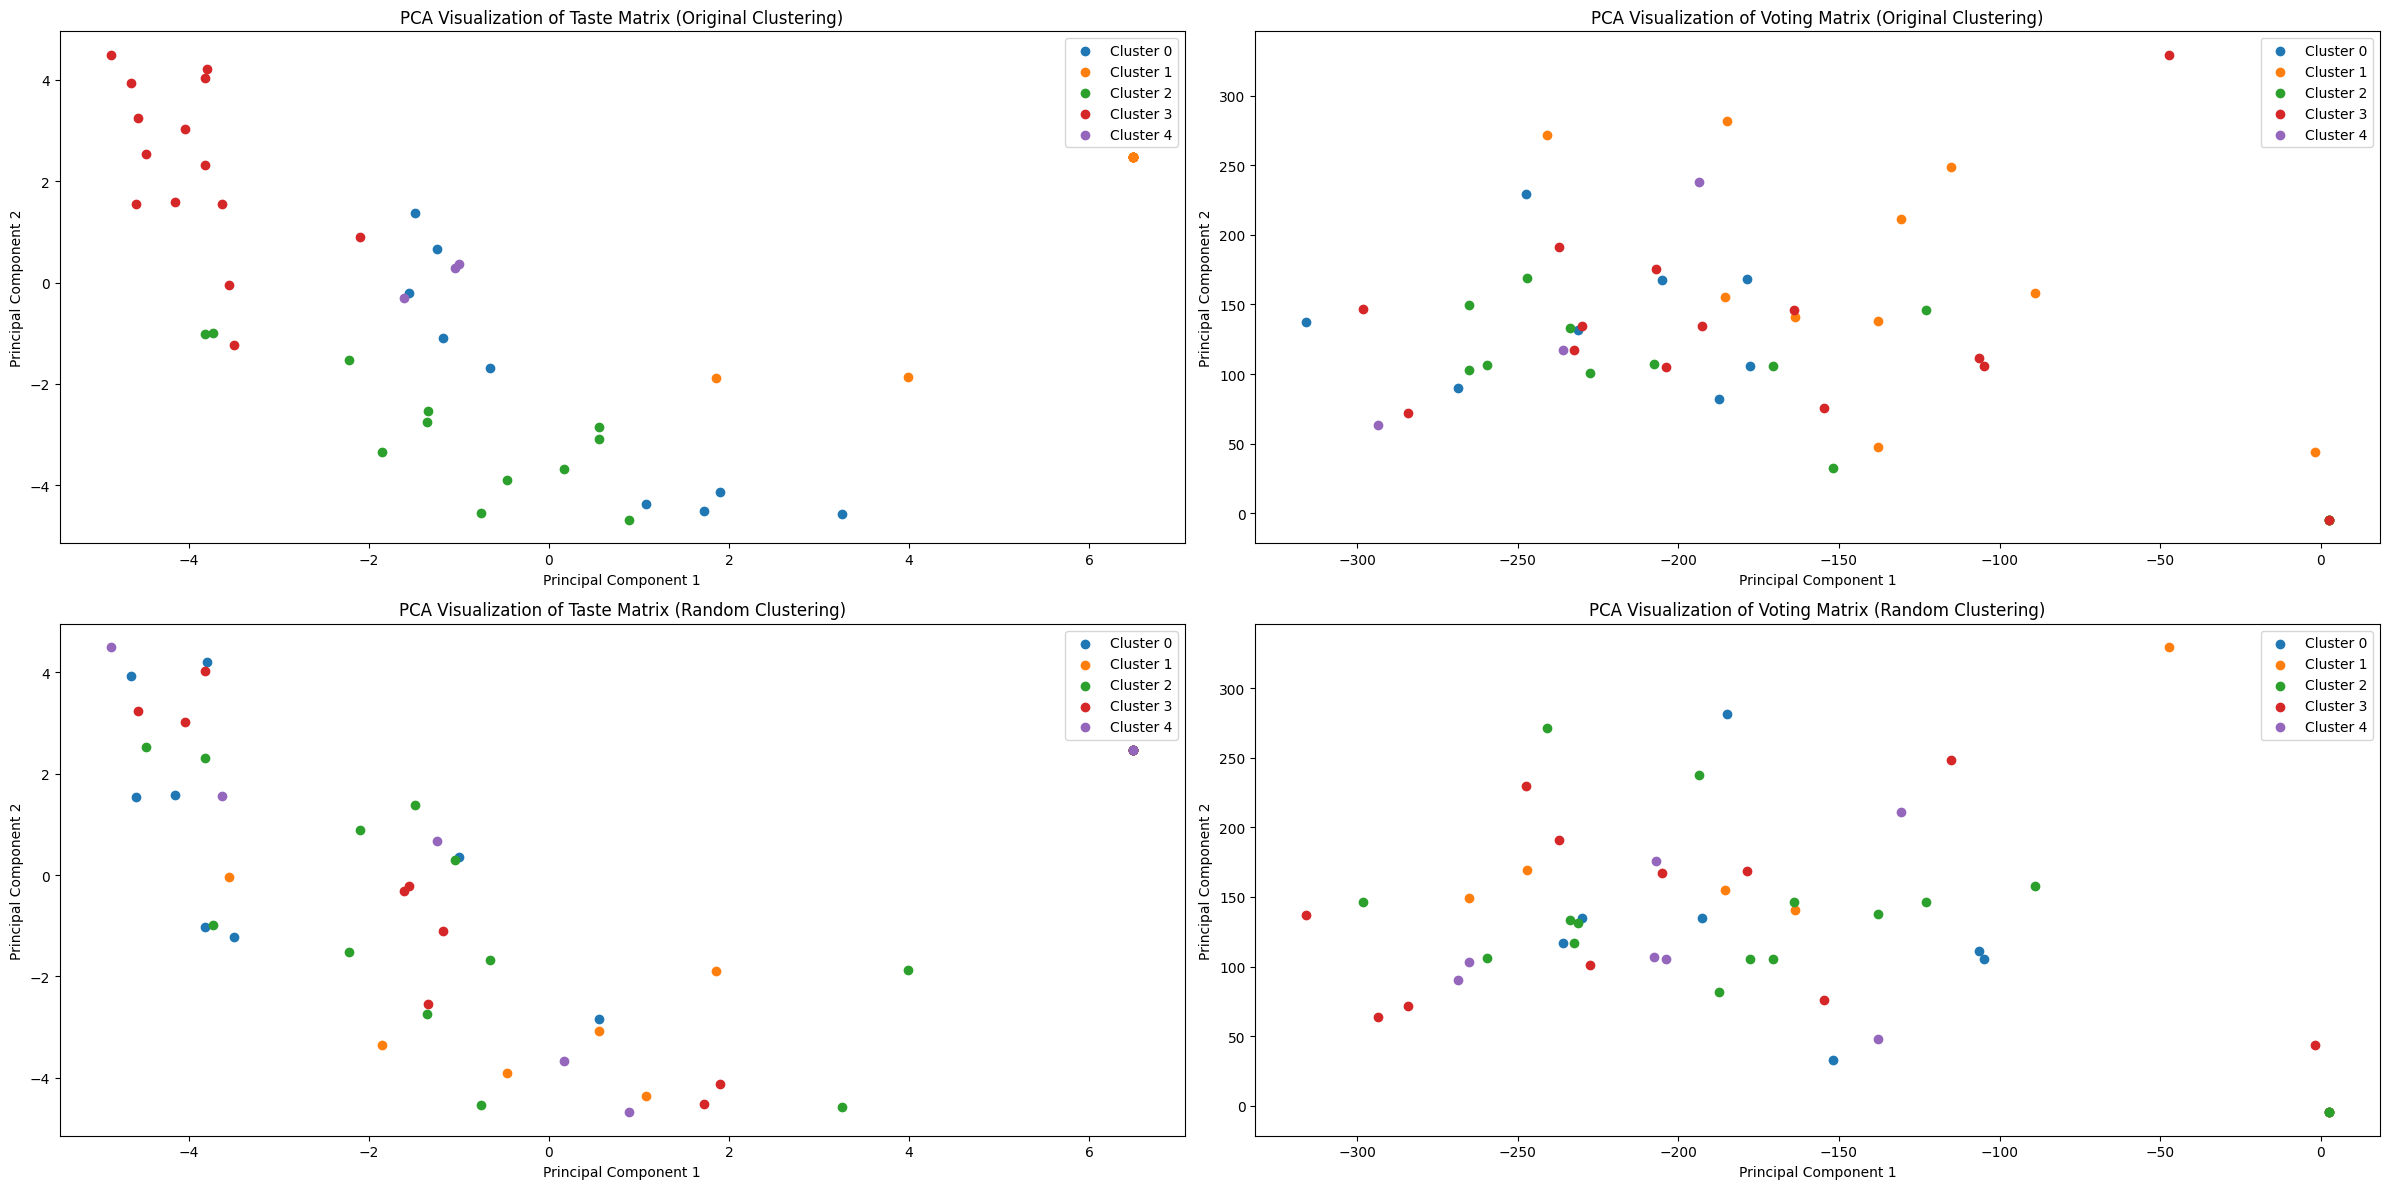

The silhouette score for Taste Matrix (Original) is: 0.3399109489774598
The silhouette score for Voting Matrix (Original) is: -0.053542774094768576
The silhouette score for Taste Matrix (Random) is: -0.0923441378518412
The silhouette score for Voting Matrix (Random) is: -0.07718165957195426


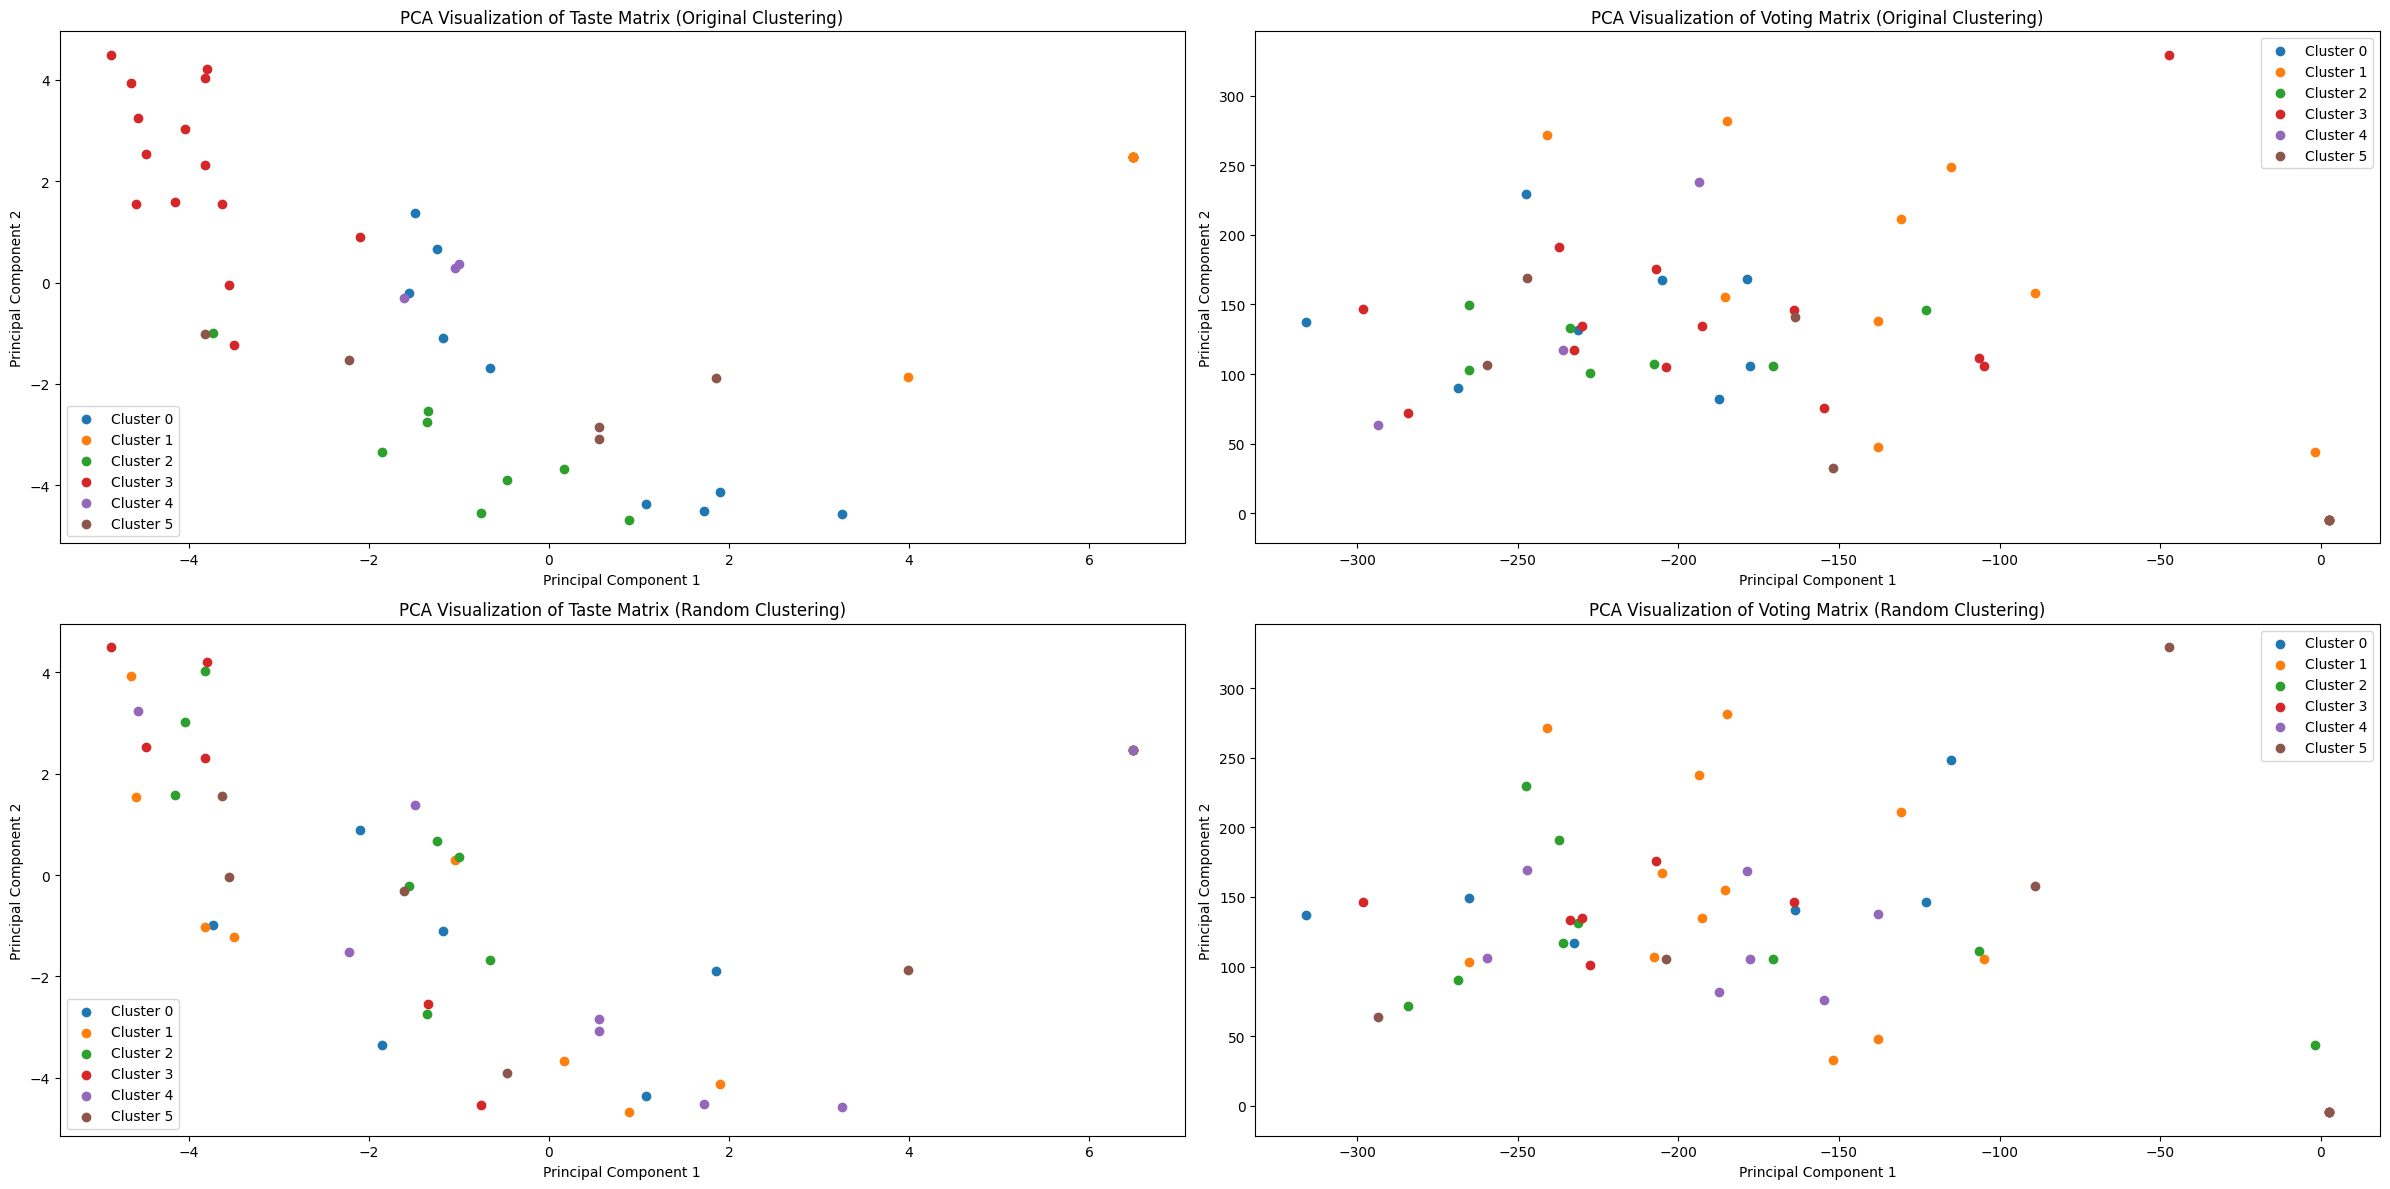

The silhouette score for Taste Matrix (Original) is: 0.3177506662858891
The silhouette score for Voting Matrix (Original) is: -0.06262385487787843
The silhouette score for Taste Matrix (Random) is: -0.09687246552965165
The silhouette score for Voting Matrix (Random) is: -0.09956717685430054


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.53575940e-13 1.17410682e-07 4.42877625e-08 2.50311259e-05]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 1714 instead with accuracy 
2.1051704250273214e-06.

  _, diffusion_map = lobpcg(
/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.53386652e-14 1.17510520e-07 4.27554460e-08 8.26041549e-06]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


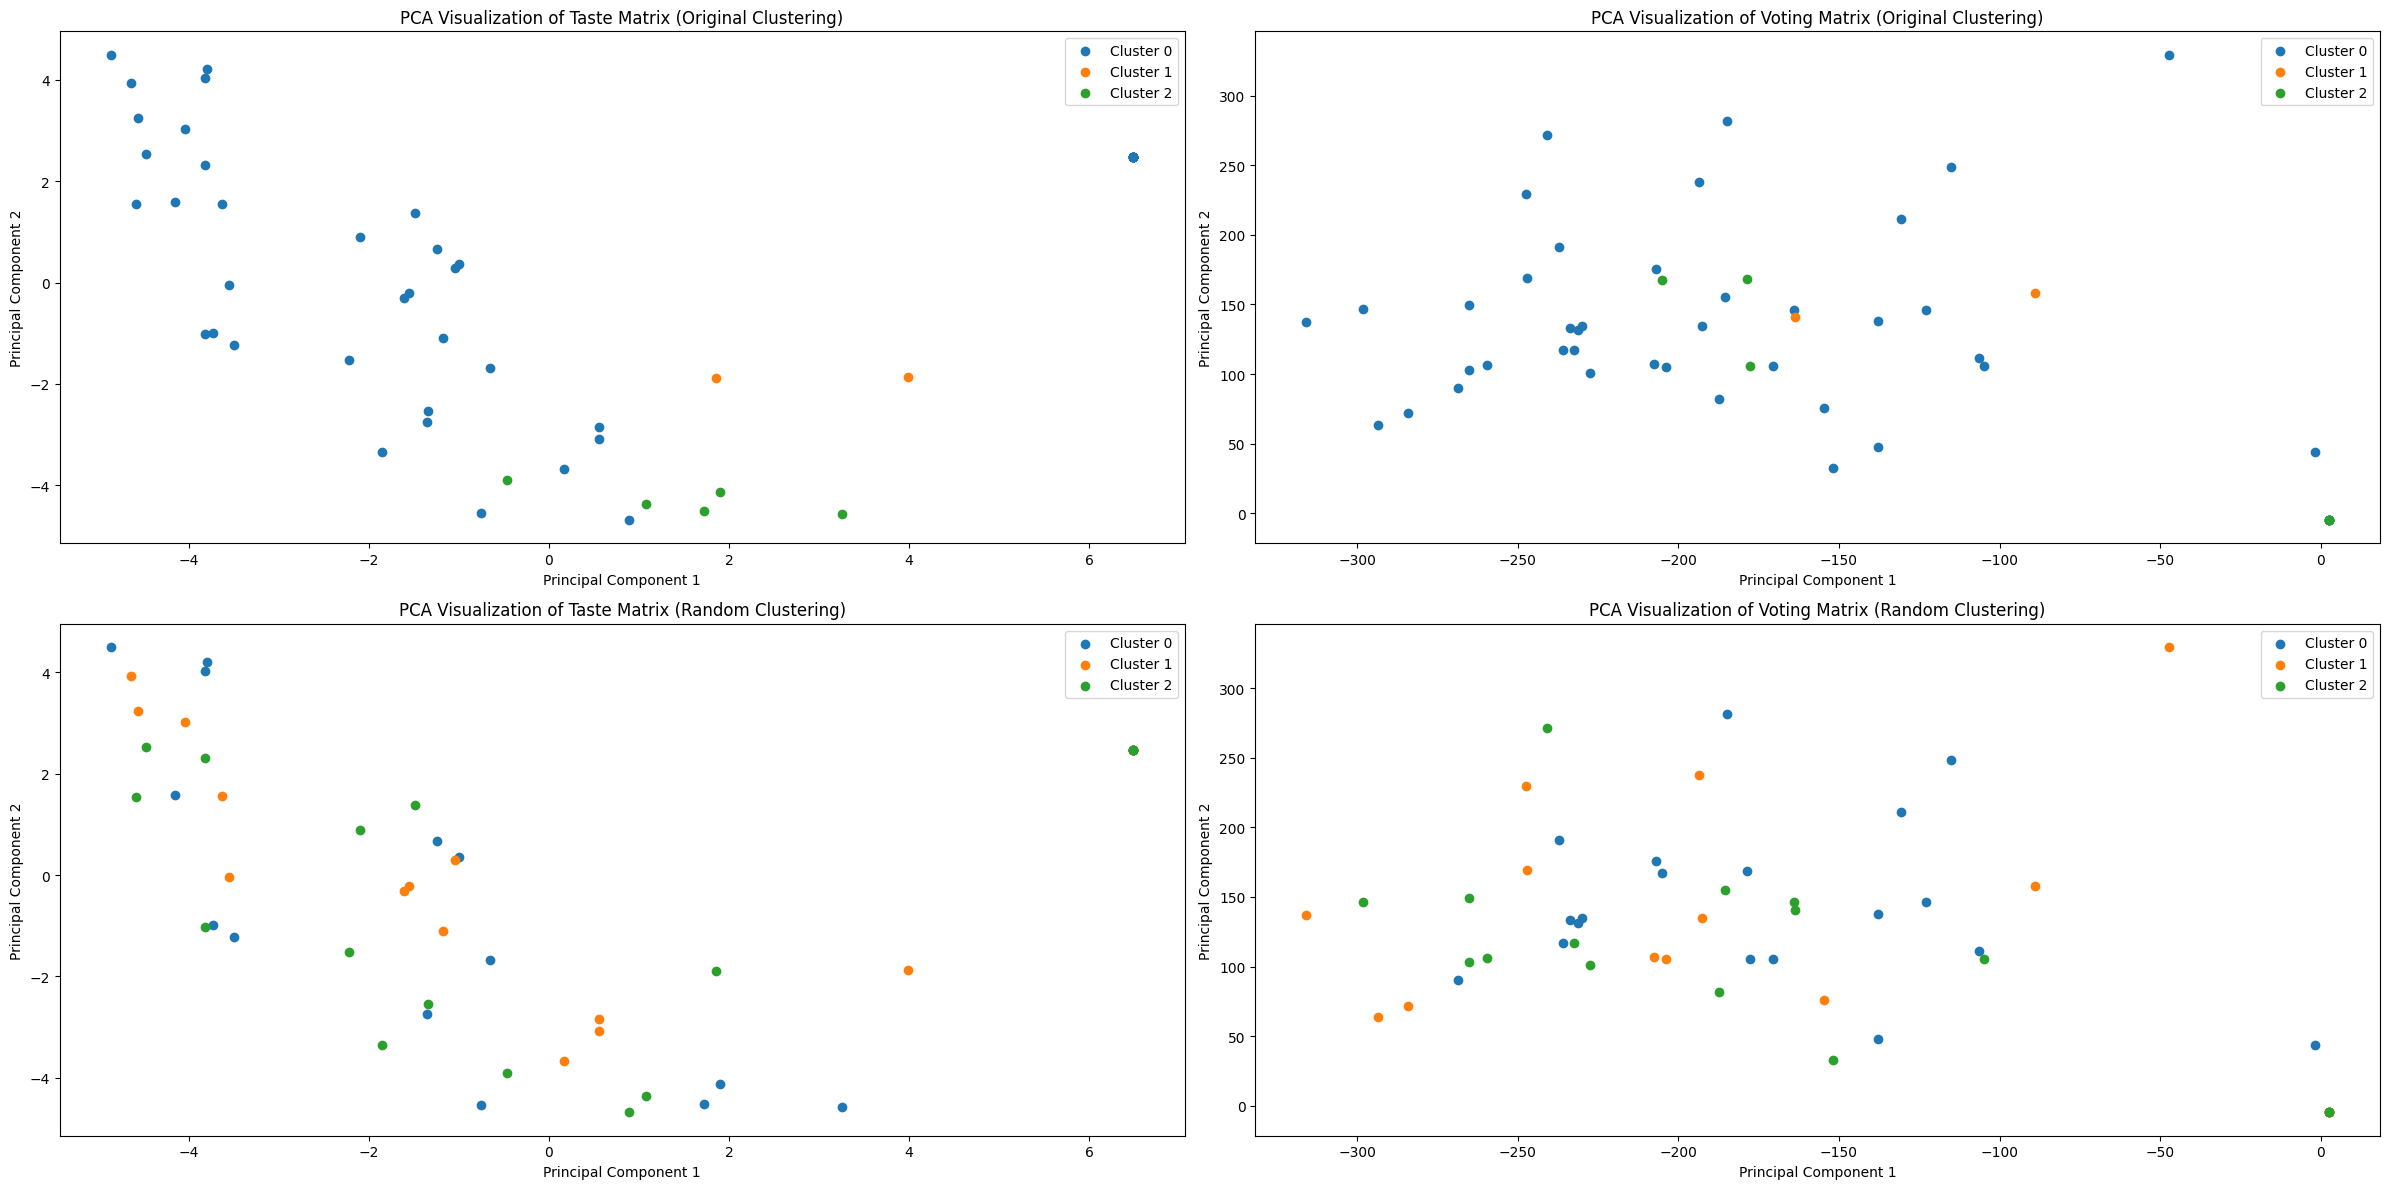

The silhouette score for Taste Matrix (Original) is: 0.09894566771759679
The silhouette score for Voting Matrix (Original) is: -0.029923079493397228
The silhouette score for Taste Matrix (Random) is: -0.036868812593828196
The silhouette score for Voting Matrix (Random) is: -0.028210488817318753


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


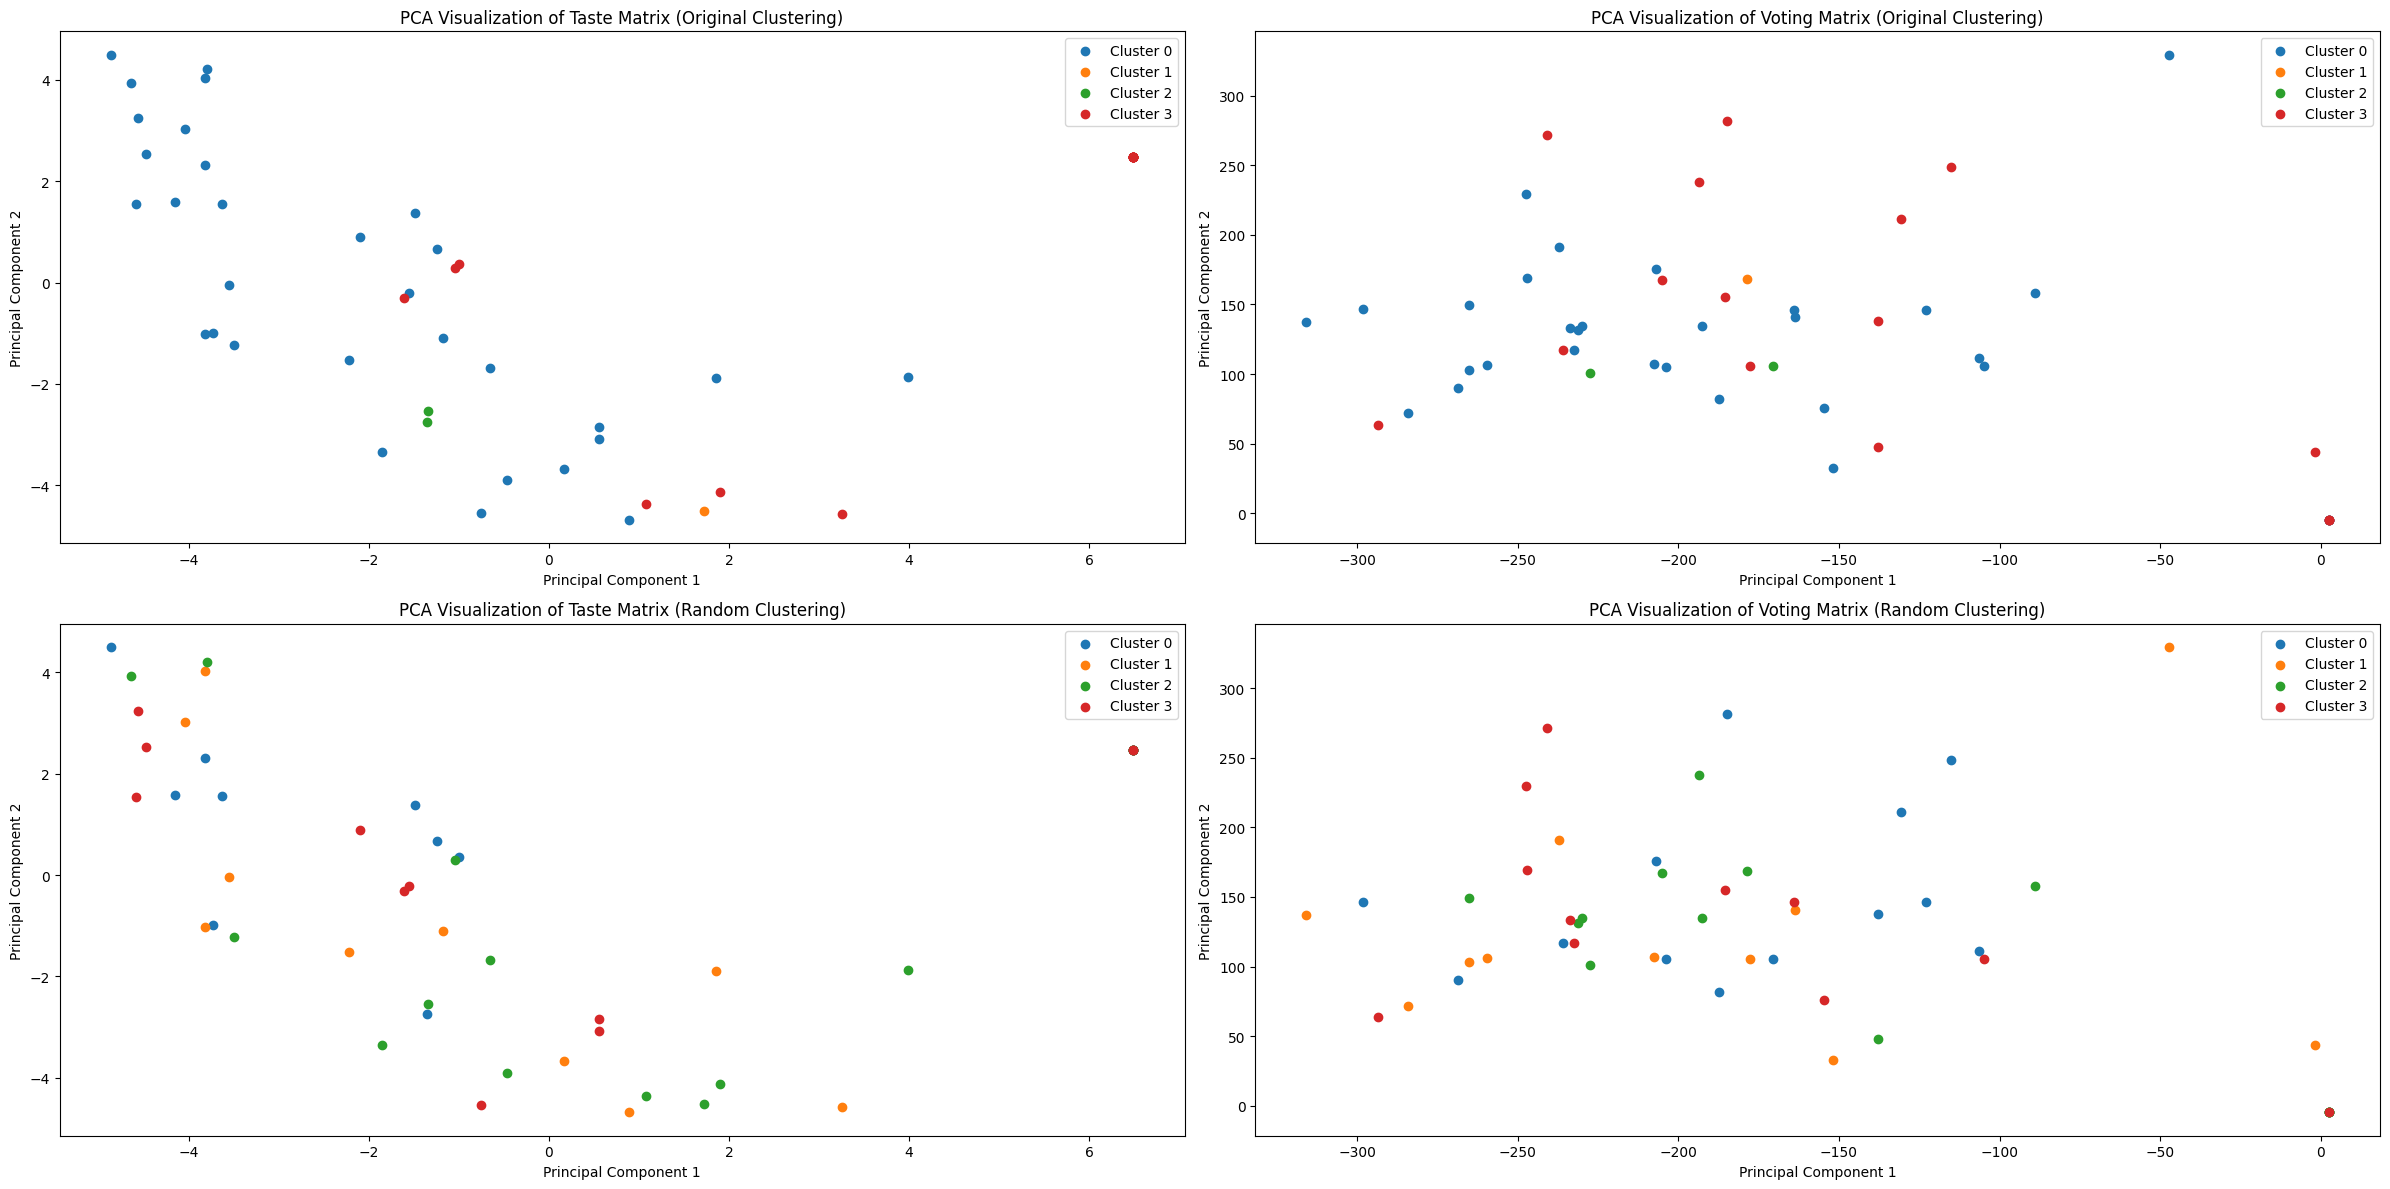

The silhouette score for Taste Matrix (Original) is: 0.16070419254348547
The silhouette score for Voting Matrix (Original) is: -0.13177954791723537
The silhouette score for Taste Matrix (Random) is: -0.05628829588083493
The silhouette score for Voting Matrix (Random) is: -0.043818574063456114


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


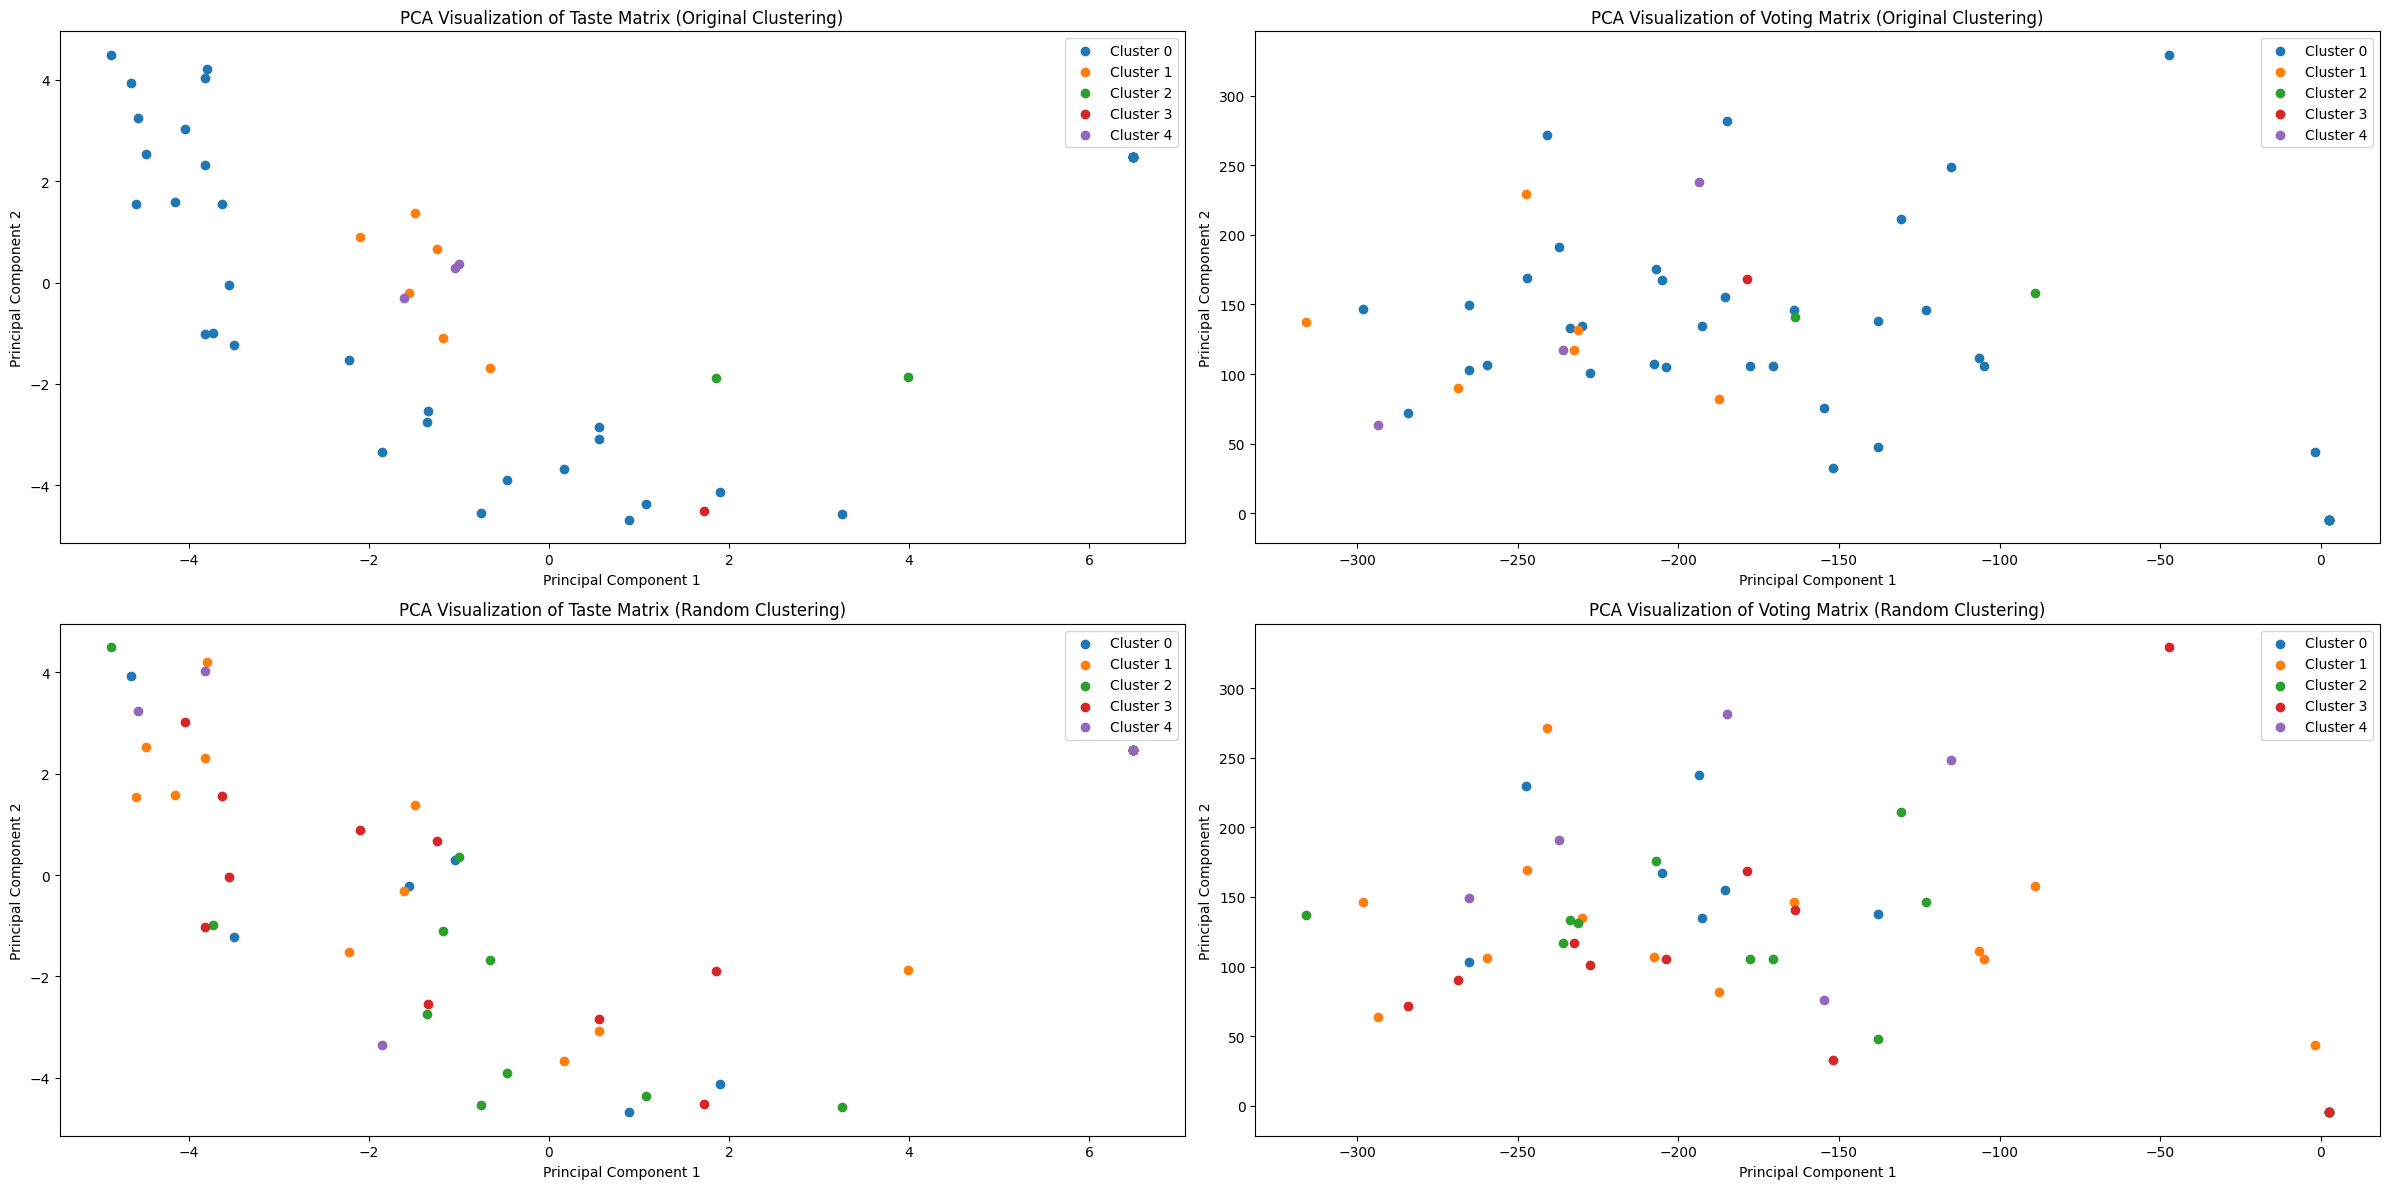

The silhouette score for Taste Matrix (Original) is: 0.05402981734882715
The silhouette score for Voting Matrix (Original) is: -0.1419804426821549
The silhouette score for Taste Matrix (Random) is: -0.10247572240741752
The silhouette score for Voting Matrix (Random) is: -0.05207434000007097


/Users/keyu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


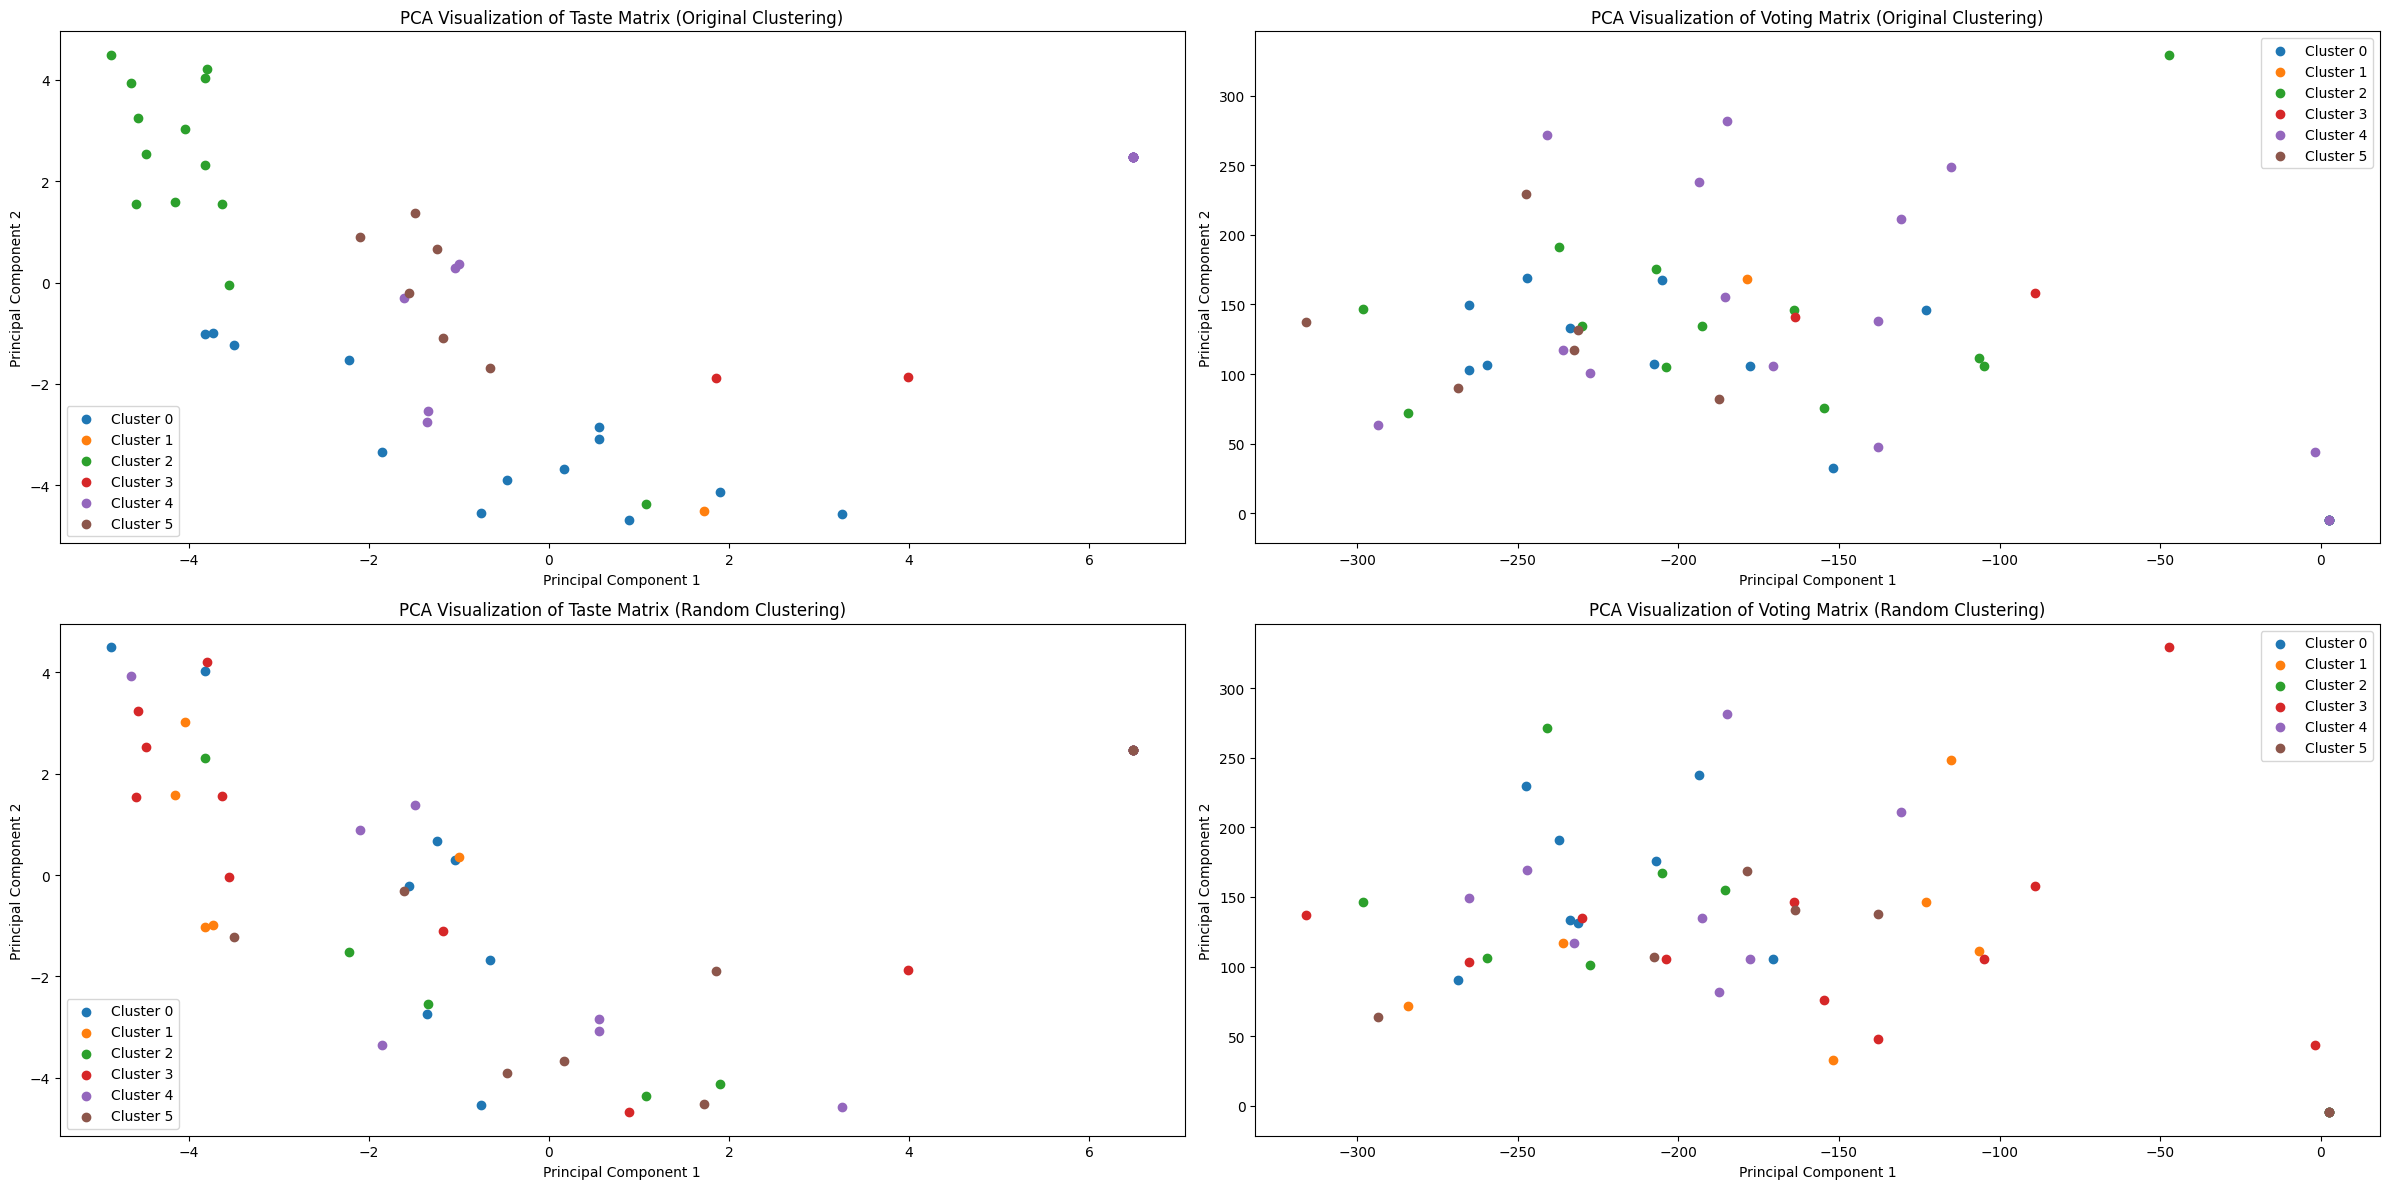

The silhouette score for Taste Matrix (Original) is: 0.23544784408658118
The silhouette score for Voting Matrix (Original) is: -0.15181183081678215
The silhouette score for Taste Matrix (Random) is: -0.09400640851116177
The silhouette score for Voting Matrix (Random) is: -0.0782053193214487


In [9]:
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 3, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 4, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 5, method='KMeans')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 6, method='KMeans')

clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 3, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 4, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 5, method='SpectralClustering')
clustering_one_and_visualize_by_pca(genres_similarity_matrix, votes_matrix_jury, 6, method='SpectralClustering')